In [1]:
system("sudo apt-get update -y && sudo apt-get install -y jags && sudo apt-get install -y r-cran-rjags")
install.packages('runjags')
install.packages('rjags')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Charger les bibliothèques nécessaires
library(dplyr)
library(ggplot2)
library(tidyverse)
library(runjags)
library(rjags)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘runjags’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



# Introduction
L’étude des disparités salariales est un sujet central en économie du travail et en sciences sociales. Malgré les avancées vers l’égalité des chances, des différences de salaires persistent entre divers groupes sociaux, notamment en fonction du genre, de l’ethnicité, du niveau d’éducation et de l’expérience professionnelle. Aux États-Unis, des études ont montré que les écarts salariaux sont significatifs : les femmes gagnent en moyenne moins que les hommes, et certaines minorités ethniques, comme les Afro-Américains et les Latino-Américains, perçoivent des salaires inférieurs à ceux des Américains blancs et asiatiques.

Notre projet vise à identifier les principaux facteurs influençant les salaires horaires en utilisant des modèles bayésiens. Plus précisément, nous cherchons à quantifier l’impact de variables telles que le genre, l’expérience professionnelle, le niveau d’éducation, l’appartenance syndicale et la localisation géographique sur les salaires.

Pour ce faire, nous utiliserons des méthodes bayésiennes de régression mises en œuvre avec JAGS, permettant une estimation robuste et une meilleure quantification des incertitudes. Notre approche inclura l’exploration des données, la spécification des modèles avec des choix de lois a priori justifiées, ainsi que des évaluations rigoureuses des performances des modèles à travers des diagnostics de convergence et des simulations de données fictives (fake data check).

Ce rapport est structuré comme suit : après une présentation des données et de leur exploration, nous décrirons les modèles bayésiens retenus et justifierons les choix de lois a priori. Nous présenterons ensuite les résultats de l’ajustement des modèles, suivis des diagnostics de convergence et de l’évaluation de leur performance. Enfin, nous discuterons des conclusions et des implications de nos résultats dans le contexte des disparités salariales aux États-Unis.

# Modèle génératif et espace des paramètres

On veut construire un modèle prédictif pour le salaire des individus pour lesquels on connait 10 variables explicatives (âge, éducation, experience professionnelle, etc.), 434 individus dans un jeu de données d'entraînement et 100 individus dans le jeu de données de test.

On note $Y_i \in \mathbb{R}$ le salaire de l'individu $i$ et $X_i \in \mathbb{R}^{10}$ les variables explicatives de l'individu $i$.

Régression linéaire:
$Y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \cdots + \beta_{10} X_{10i} + \sigma \epsilon_i$
11 paramètres $\beta = (\beta_0, \beta_1, \beta_2, \cdots, \beta_{10})$  $\epsilon_i \sim \mathcal{N}(0, 1)$ et $\sigma \in \mathbb{R^+}$

Certaines variables peuvent avoir peu ou pas d'effet sur le salaire, ie des $\beta_i = 0$.

## Distribution à postériori

A partir de $y=(y_1, y_2, \cdots, y_{434})$ et $ X=(X_1, X_2, \cdots, X_{434})$, on peut calculer $P(\beta | y, X)$ et regarder $P(\beta_j \neq 0 | y, X)$ pour chaque coefficient.

## Performances prédictives

Un manière d'évaluer la performance prédictive $\hat{\beta}_{bayes} = E(\beta | y, X)$
$X_{test}$ matrice 100x10
$y_{test}$ les observations
$y_{test,Bayes} = X_{test} \hat{\beta}_{bayes}$

# Degrès de croyance

Que croit-on sur l'effet de chaque variable explicative sur le salaire?

Nous pouvons formuler des hypothèse à priori sur l'impact des différentes variables :

- Éducation : On s’attend à une relation positive entre le niveau d’éducation et le salaire.

- Expérience professionnelle (workexp) : Plus d’expérience est généralement associée à un salaire plus élevé.

- Sexe (female) : Il est bien documenté qu’un écart salarial entre hommes et femmes existe (gender pay gap).

- Région (south) : Il peut y avoir des différences salariales régionales.

- Appartenance syndicale (unionmember) : Être syndiqué peut influencer le salaire.

- Âge (age) : En général, l’âge est corrélé à l’expérience professionnelle, mais il pourrait aussi capturer d’autres dynamiques comme la discrimination liée à l’âge.

- Ethnicité (ethnicity) : Certaines inégalités salariales peuvent exister selon l’origine ethnique.

- Occupation et secteur (occupation, sector) : Le type d’emploi et le secteur d’activité influencent fortement le salaire.

- Statut matrimonial (married) : Certaines études suggèrent que les personnes mariées ont des salaires plus élevés, en particulier les hommes.


### Estimation d'un paramètre $\beta$ avec des données

Ayant obtenu {$Y=y$} , $P(\beta | y,X) = \frac{P(\beta) P(y,X | \beta)}{P(y,X)}$

Donc $posterior \propto prior \times likelihood$

$prior = P(\beta)$ : Croyance des effets des variables sur le salaire avant d'avoir les données.
$likelihood = P(y | \beta)$ : Probabilité d'observer les données en fonction des paramètres du modèle
$posterior = P(\beta | y)$ : La Distribution à posteriori après avoir observé les données

On peut le voir ainsi :

$P(Model | New Data)  = \frac{P(Model) P(New Data | Model)}{P(New Data)}$



# Nos données

Notre jeu de données comprend 534 individus. Chaque individu a 10 variables : education, south, female, workexp, unionmember, wages, age, ethnicity, occupation, sector, married.

- Variables quantitatives:
    > **education**: Années d'études
    >**workexp**: Années d'expêrience professionnelle
    >**age**: âge

- Variables qualitatives:
    >**south**: Vit dans le sud ou non
    >**female**: Indicateur de genre (0 = Homme, 1 = Femme)
    >**unionmember**: Indicateur de membre du syndicat (0 = Non, 1 = Oui)
    >**married**: Indicateur de statut marital. Marié(e) ou non.

- Variables categorielles:
    >**ethnicity**: Ethnicité (White, Hispanic, Other)
    >**occupation**: Occupation (Management, Sales, Clerical, Professional, Service, Other)
    >**sector**: Secteur d'activité (Manufactoring, Construction, Other)




# Modélisation Bayésienne

* L'analyse traditionnelle des déterminants salariaux repose souvent sur des modèles de régression visant à prédire le salaire horaire individuel comme variable continue. Cependant, cette approche présente une limite majeure : elle ne permet pas d'identifier clairement les facteurs qui influencent l'appartenance à une catégorie significative de salaire (par exemple, un revenu "élevé" versus "bas"). En effet, prédire une valeur exacte de salaire horaire (par exemple, 15,67 $/h) n’est pas toujours utile pour comprendre les dynamiques structurelles des inégalités ou pour élaborer des politiques ciblées.
* Pour pallier cette limite, nous avons adopté une approche alternative : transformer la variable salariale continue en une variable binaire indiquant si un individu perçoit un salaire supérieur au salaire moyen (1) ou non (0). Cette 
* Pour ce faire, on ajoute une colonne pour calculer la moyenne de la variable wage avec 0 pour les salaires inférieurs à la moyenne et 1 pour les salaires supérieurs à la moyenne.

In [44]:
# Charger les données
wage_data <- read.csv("https://raw.githubusercontent.com/derghalmanal/Wage/refs/heads/main/wage_data.csv", header=TRUE, sep=",")

# Calculer la moyenne de la colonne wage
mean_wage <- mean(wage_data$wage, na.rm=TRUE)

# Ajouter la colonne wage_moyenne
wage_data$wage_level <- ifelse(wage_data$wage < mean_wage, 0, 1)

# Transformer la colonne wage_moyenne en facteur
wage_data$wage_level <- as.factor(wage_data$wage_level)

# Vérifier le résultat
head(wage_data)

education south female workexp unionmember wages age ethnicity occupation
1  8        0     1      21      0            5.10 35  Hispanic  Other     
2  9        0     1      42      0            4.95 57  White     Other     
3 12        0     0       1      0            6.67 19  White     Other     
4 12        0     0       4      0            4.00 22  White     Other     
5 12        0     0      17      0            7.50 35  White     Other     
6 13        0     0       9      1           13.07 28  White     Other     
  sector        married wage_level
1 Manufacturing 1       0         
2 Manufacturing 1       0         
3 Manufacturing 0       0         
4 Other         0       0         
5 Other         1       0         
6 Other         0       1

In [4]:
str(wage_data)

'data.frame':	534 obs. of  12 variables:
 $ education  : int  8 9 12 12 12 13 10 12 16 12 ...
 $ south      : int  0 0 0 0 0 0 1 0 0 0 ...
 $ female     : int  1 1 0 0 0 0 0 0 0 0 ...
 $ workexp    : int  21 42 1 4 17 9 27 9 11 9 ...
 $ unionmember: int  0 0 0 0 0 1 0 0 0 0 ...
 $ wages      : num  5.1 4.95 6.67 4 7.5 ...
 $ age        : int  35 57 19 22 35 28 43 27 33 27 ...
 $ ethnicity  : chr  "Hispanic" "White" "White" "White" ...
 $ occupation : chr  "Other" "Other" "Other" "Other" ...
 $ sector     : chr  "Manufacturing" "Manufacturing" "Manufacturing" "Other" ...
 $ married    : int  1 1 0 0 1 0 0 0 1 0 ...
 $ wage_level : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 2 2 1 ...


Analysons la contribution de chaque variable aux salaires

Dans toute la suite du rapport l = lower pour signifier que le salaire est inférieur à la moyenne et h = higher pour signifier que le salaire est supérieur à la moyenne.

On cherchera la loi de la vraisemblance $X_{i,s}|\beta$ pour chaque individu $i$ et chaque variable $s \in \{l,h\}$.

In [5]:
plot_credible_intervals <- function(jags_samples) {
  # Extract the MCMC samples and the names of the parameters
  samples <- as.data.frame(jags_samples$mcmc %>% lapply(as_tibble) %>% bind_rows())
  params <- names(samples)

  # Calculate the 50% and 95% credible intervals for each parameter
  intervals <- data.frame(param = character(), lower = numeric(), upper = numeric())
  for (param in params) {
    est_mean <- mean(samples[[param]])
    est_median <- median(samples[[param]])
    ci_50_infCI <- quantile(samples[[param]], probs = 0.25)
    ci_50_supCI <- quantile(samples[[param]], probs = 0.75)
    ci_95_infCI <- quantile(samples[[param]], probs = 0.025)
    ci_95_supCI <- quantile(samples[[param]], probs = 0.975)
    intervals <- rbind(intervals, data.frame(param = param, est_mean = est_mean, est_median = est_median, ci_50_infCI = ci_50_infCI, ci_50_supCI = ci_50_supCI, ci_95_infCI = ci_95_infCI, ci_95_supCI = ci_95_supCI))
  }

  # Create a ggplot object
  p <- ggplot(intervals, aes(y = param)) +
    theme_classic() +
    geom_segment(aes(y = param, yend = param, x = ci_95_infCI, xend = ci_95_supCI),
      color = "red", size = 0.5
    ) +
    geom_segment(aes(y = param, yend = param, x = ci_50_infCI, xend = ci_50_supCI),
      color = "red", size = 1.5
    ) +
    geom_point(aes(x = est_mean), size = 3) +
    labs(title = "Posterior credible intervals") +
    xlab("") +
    ylab("")

  # Print the plot
  print(p)
}

# Histogramme des variables

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


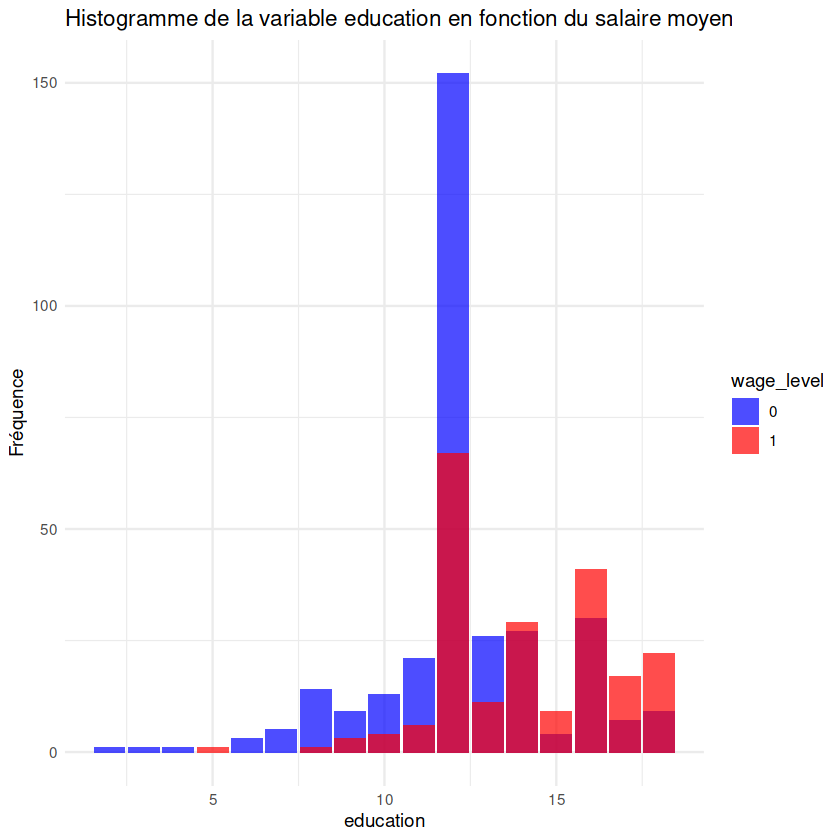

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <a5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted fo

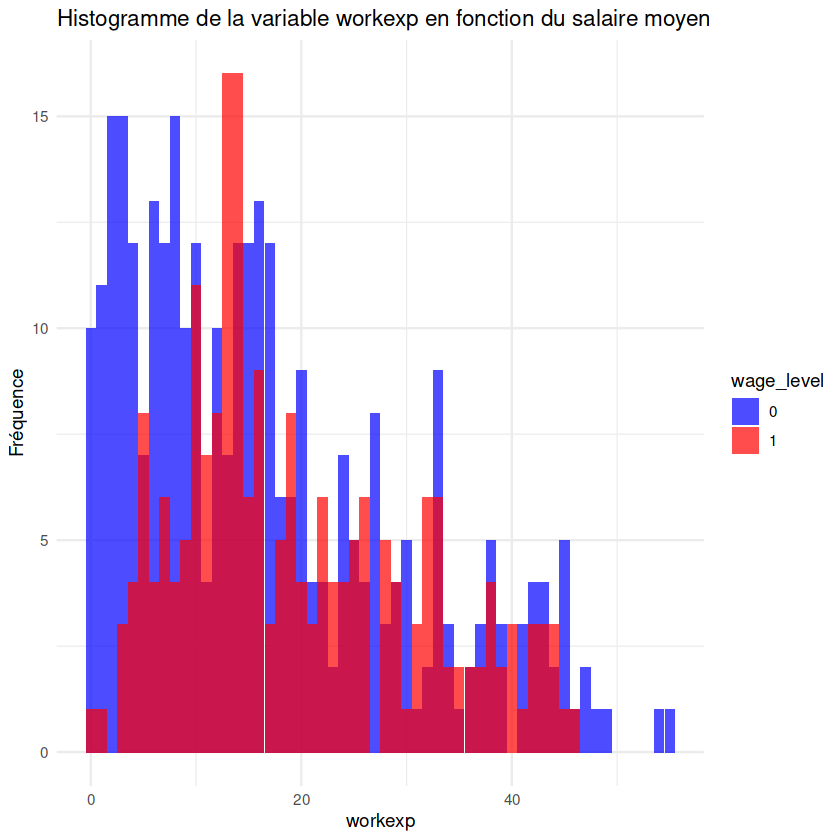

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <a5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted fo

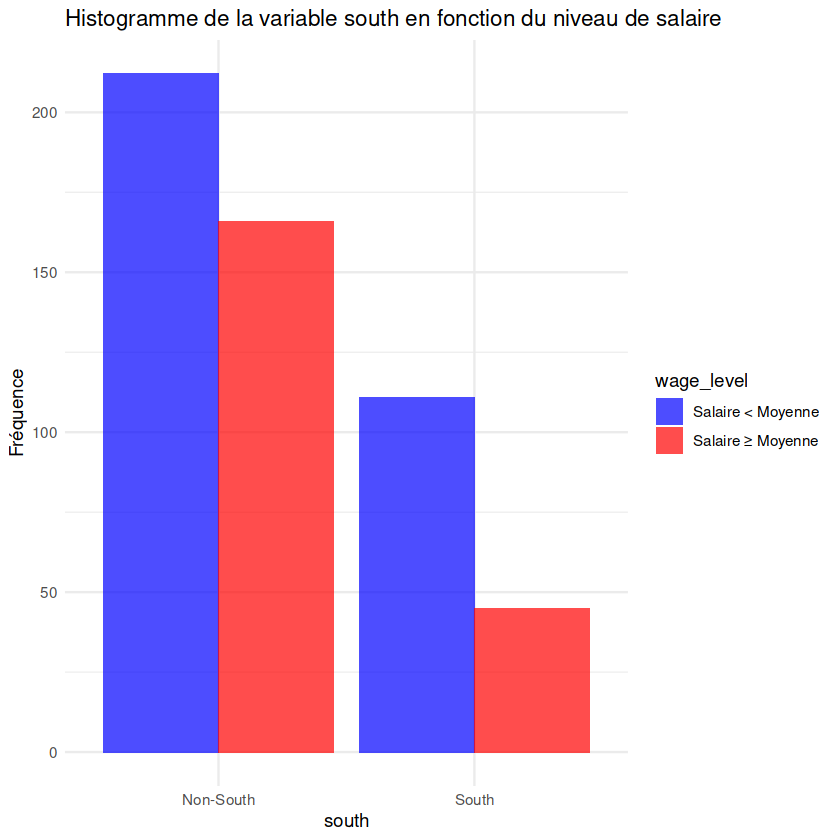

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <a5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted fo

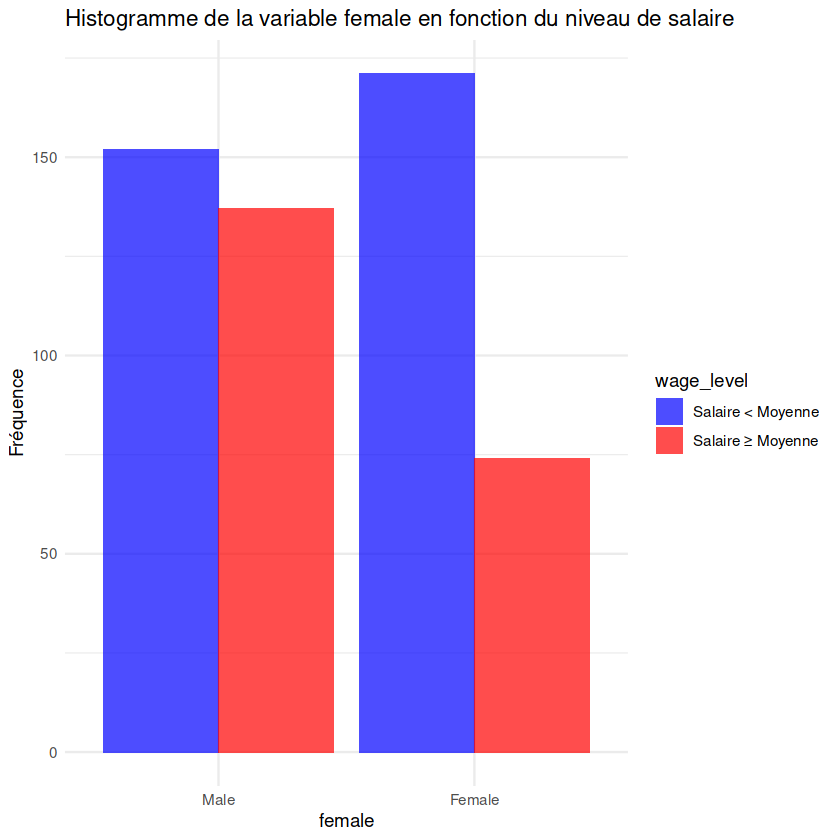

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <a5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Salaire ≥ Moyenne' in 'mbcsToSbcs': dot substituted fo

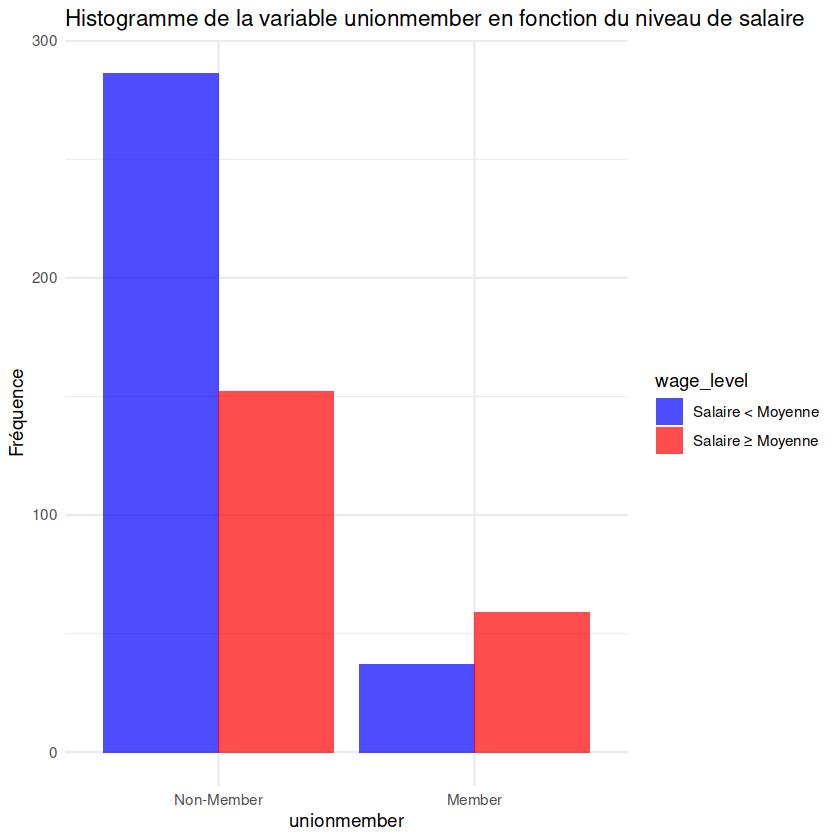

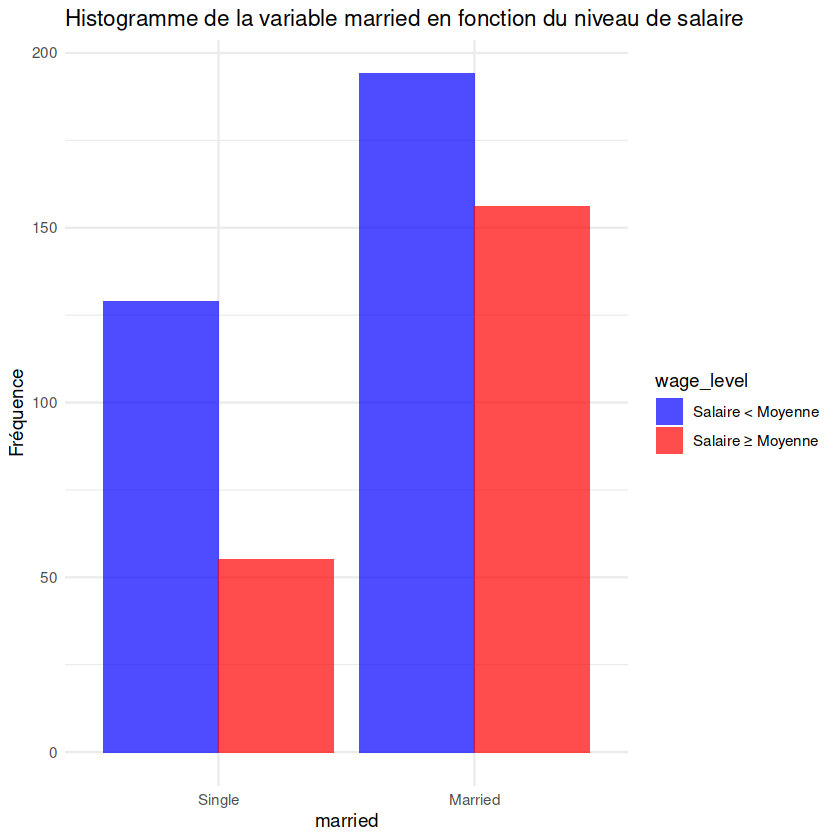

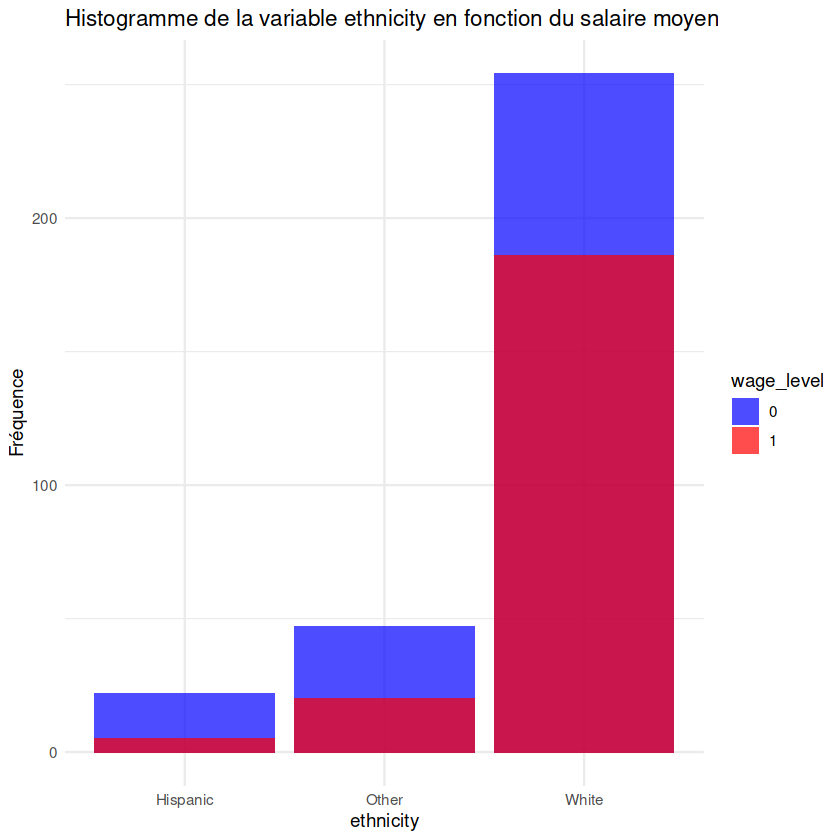

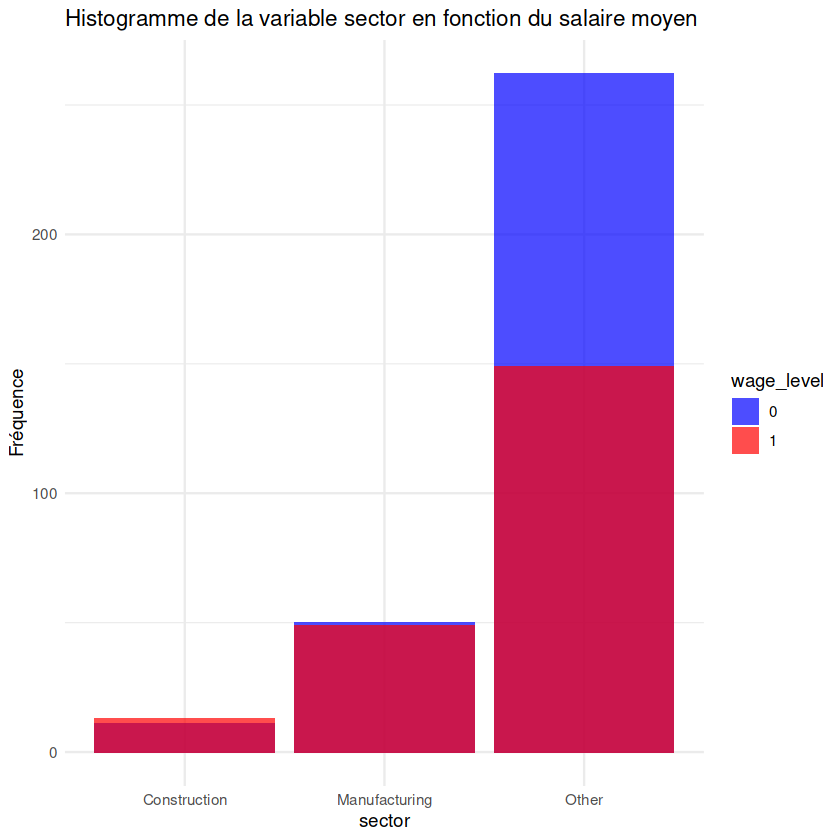

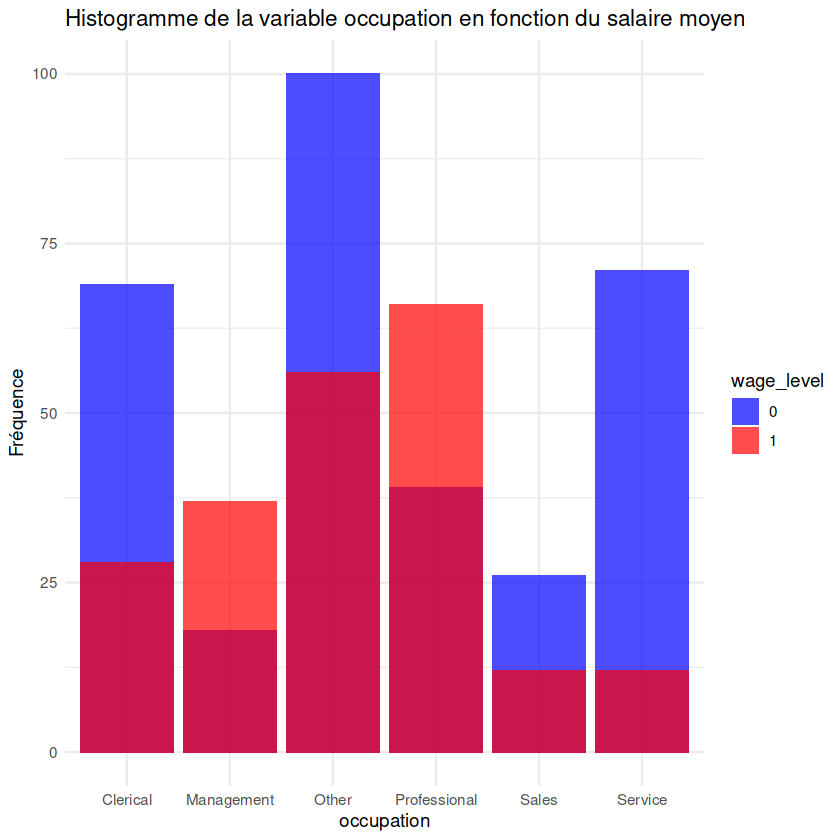

In [6]:
numeric_vars <- c("education", "workexp")
wage_data[numeric_vars] <- lapply(wage_data[numeric_vars], function(x) as.numeric(as.character(x)))

for (var in numeric_vars){
    print(ggplot(data = wage_data, aes_string(x = var, fill = "wage_level" )) +
      geom_bar( position = "identity", alpha = 0.7) +
      labs(title = paste0("Histogramme de la variable ", var , " en fonction du salaire moyen"),
           x = var, y = "Fréquence") +
      scale_fill_manual(values = c("blue", "red")) +  # Couleurs des labels
      theme_minimal())
}

wage_data$south        <- factor(wage_data$south, labels = c("Non-South", "South"))
wage_data$female       <- factor(wage_data$female, labels = c("Male", "Female"))
wage_data$unionmember  <- factor(wage_data$unionmember, labels = c("Non-Member", "Member"))
wage_data$married      <- factor(wage_data$married, labels = c("Single", "Married"))

# Now binary_vars are factors with clear labels
binary_vars <- c("south", "female", "unionmember", "married")

# Plot
for (var in binary_vars){
  print(
    ggplot(data = wage_data, aes_string(x = var, fill = "wage_level")) +
      geom_bar(position = "dodge", alpha = 0.7) +
      labs(title = paste("Histogramme de la variable", var, "en fonction du niveau de salaire"),
           x = var, y = "Fréquence") +
      scale_fill_manual(values = c("blue", "red"), 
                        labels = c("Salaire < Moyenne", "Salaire ≥ Moyenne")) +
      theme_minimal()
  )
}
categorial_vars <- c("ethnicity", "sector","occupation")
wage_data[categorial_vars] <- lapply(wage_data[categorial_vars], function(x) as.factor(as.character(x)))

for (var in categorial_vars){
    print(ggplot(data = wage_data, aes_string(x = var, fill = "wage_level" )) +
      geom_bar( position = "identity", alpha = 0.7) +
      labs(title = paste0("Histogramme de la variable ", var , " en fonction du salaire moyen"),
           x = var, y = "Fréquence") +
      scale_fill_manual(values = c("blue", "red")) +  # Couleurs des labels
      theme_minimal())
}

# Variable Education

<img src="image-20250330-163929.png" width="" align="" />

## Vraisemblance

Choix de la vraisemblance :

Étant donné la concentration des données à une valeur spécifique, nous avons choisi une distribution de Poisson pour modéliser le nombre d'années d'études. 

$X_{i,s} | \beta_{education,s} \sim \mathcal{Poisson}(\beta_{education,s} )$ et $s \in \{l,h\}$

## Prior

L'histogramme montre une distribution avec un pic très prononcé à 12 années d'études, indiquant que la plupart des individus ont ce niveau d'éducation.
Il y a quelques valeurs dispersées autour de ce pic, mais la majorité des données est concentrée à 12 ans.


$\beta_{education,s } \sim \mathcal{Gamma}(\alpha, \beta)$ avec $s \in \{l,h\}$

On souhaite que $E(\beta_{education,l}) = 12$ et $V(\beta_{education,l}) = 20$

On souhaite que $E(\beta_{education,h}) = 12$ et $V(\beta_{education,h}) = 20$

Pour la loi gamma $E(\beta) = \frac{\alpha}{\beta}$ et $V(\beta) = \frac{\alpha}{\beta^2}$

donc $\beta_{education,s} \sim \mathcal{Gamma}(7.2, 0.6)$

## Implementation en JAGS

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 10000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation



JAGS model summary statistics from 30000 samples (chains = 3; adapt+burnin = 2000):
                                                                           
                 Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD
beta_education_l  4.0461  11.43  20.792 11.981 4.4602   -- 0.025598     0.6
beta_education_h  4.2117 11.523  21.149 12.054 4.5139   -- 0.025916     0.6
                                        
                 SSeff      AC.10   psrf
beta_education_l 30360 0.00050133      1
beta_education_h 30336  0.0039715 1.0001

Total time taken: 0.3 seconds


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


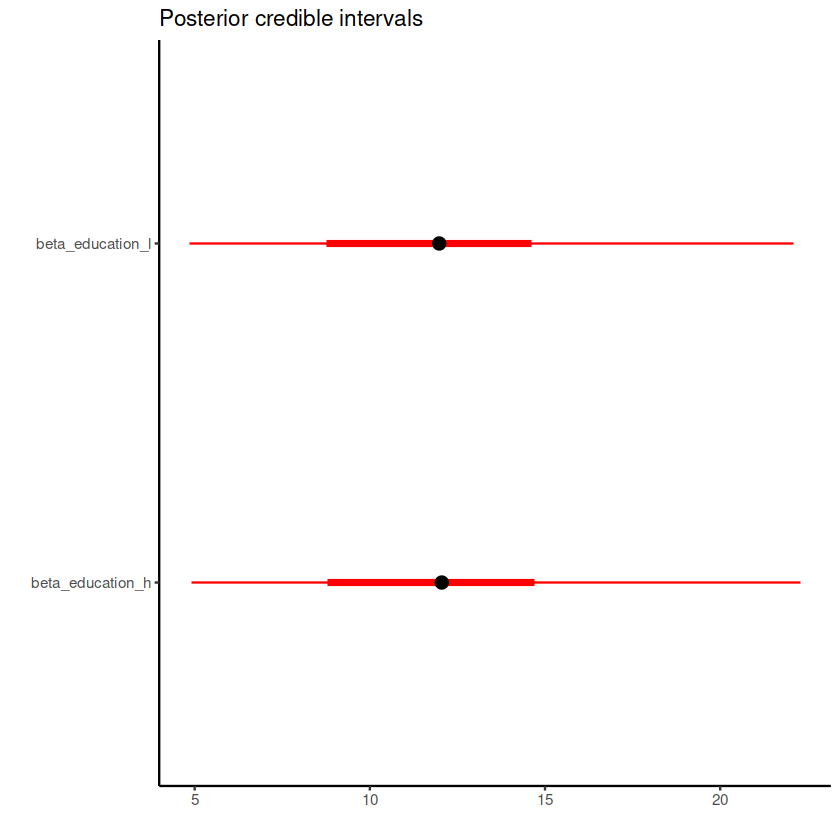

In [7]:
model_string_education <- "
model {

  # Priors
  beta_education_l~ dgamma(7.2, 0.6)
  beta_education_h ~ dgamma(7.2, 0.6)
  
  
  for (i in 1:n1) {
    y1_education[i] ~ dpois(beta_education_l)
  }
  
  for (i in 1:n2) {
    y2_education[i] ~ dpois(beta_education_h)
  }
}
"
education_l <- wage_data$education[wage_data$wage_level == 0]
education_h <- wage_data$education[wage_data$wage_level == 1]

# Définition des données
y1_education <- education_l
y2_education <- education_h
data_list <- list(y1 = y1_education, y2 = y2_education, n1 = length(y1_education), n2 = length(y2_education))

# Compiling and producing posterior samples from the model.
jags_samples_education <- run.jags(model = model_string_education, data = data_list, monitor = c("beta_education_l", "beta_education_h"), n.chains = 3, adapt = 1000, burnin = 1000, thin = 1)

# Plotting and summarizing the posterior distribution
jags_samples_education
plot_credible_intervals(jags_samples_education)

[1] 0.5042

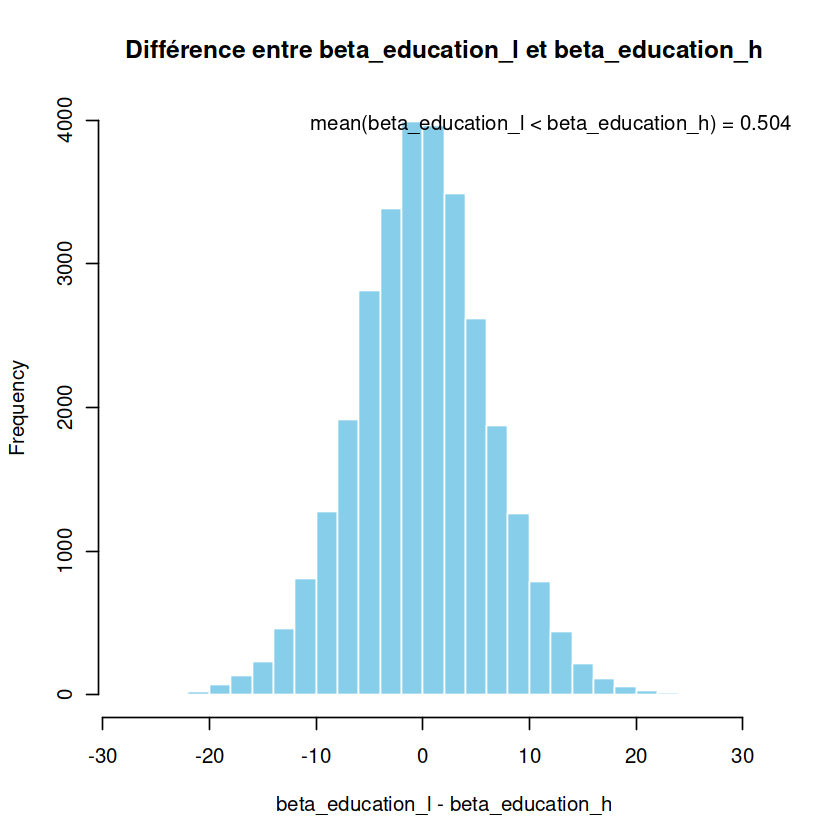

In [8]:
analyze_mcmc_difference <- function(jags_samples, param1, param2) {

    # Conversion des échantillons en data frame
  s <- as.data.frame(jags_samples$mcmc %>% lapply(as_tibble) %>% bind_rows())
  
  # Calcul de la différence
  diff_samples <- s[[param1]] - s[[param2]]
  
  # Calcul de la probabilité
  prob <- mean(diff_samples < 0)
  
  # Graphique
  hist(diff_samples, 
       main = paste("Différence entre", param1, "et", param2),
       xlab = paste(param1, "-", param2),
       col = "skyblue",
       border = "white",
       breaks = 30)
  
  # Légende
  legend("topright", 
         legend = paste0("mean(", param1, " < ", param2, ") = ", round(prob, 3)),
         bty = "n")
  
  # Retour simple
  return(prob)
}

analyze_mcmc_difference(jags_samples_education, "beta_education_l", "beta_education_h")

$ \beta_{education,l} $  : L'effet de l'éducation pour les personnes dont le salaire est inférieur à la moyenne.

$ \beta_{education,h} $  : L'effet de l'éducation pour les personnes dont le salaire est supérieur à la moyenne.

mean($ \beta_{education,l} - \beta_{education,h} < 0$) = 1 : Cela signifie que,l'effet de l'éducation sur la probabilité de se retrouver dans le groupe lower (salaire inférieur à la moyenne) est plus faible que l'effet de l'éducation sur la probabilité de se retrouver dans le groupe higher (salaire supérieur à la moyenne).

## MCMC

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


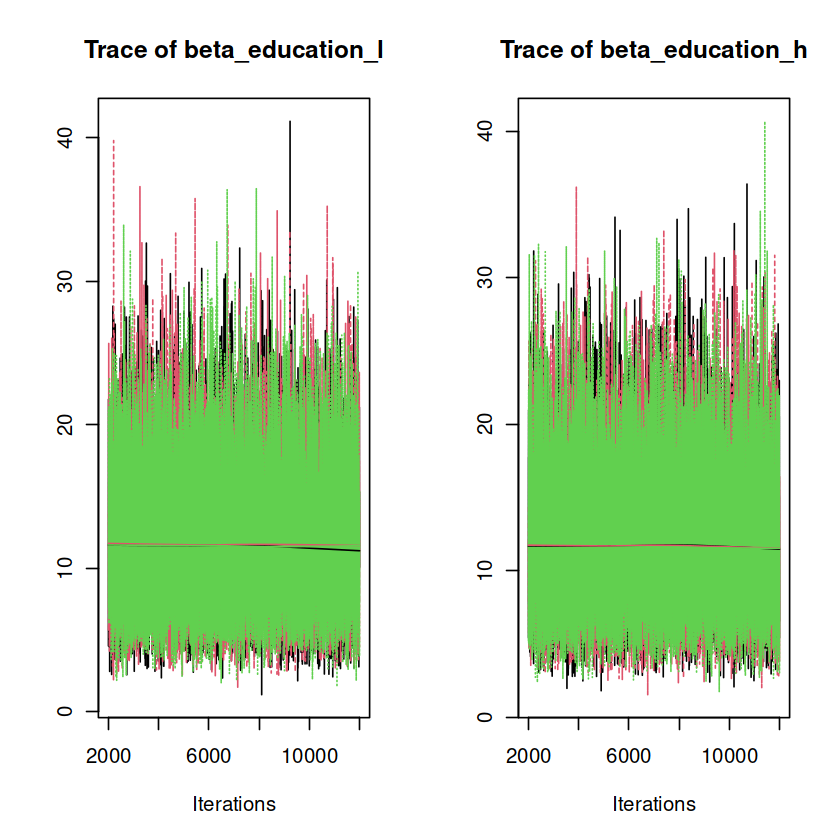

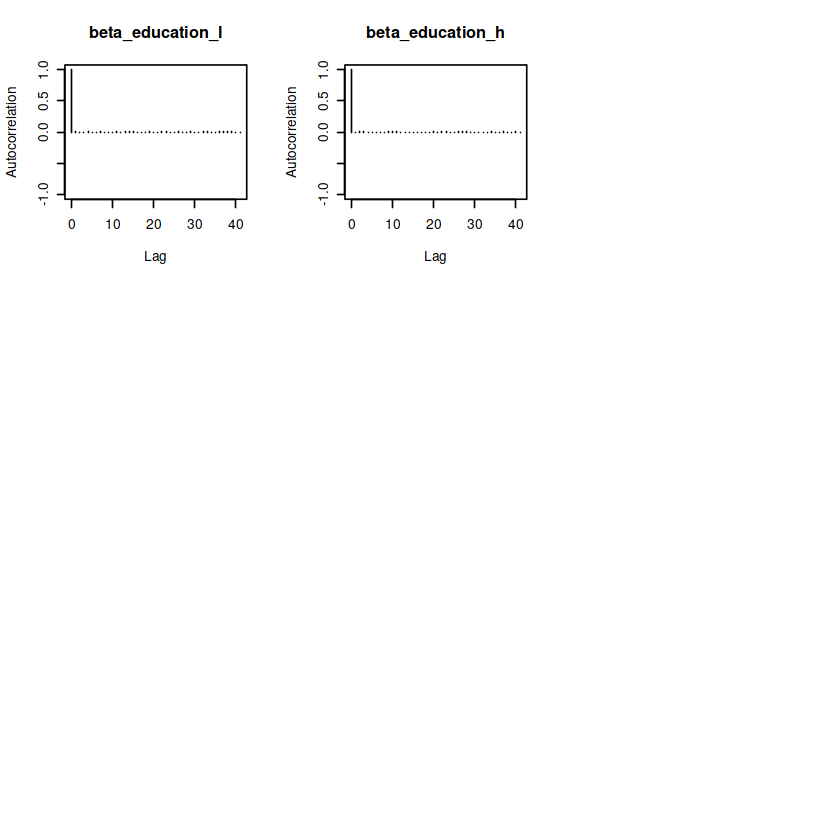

In [9]:
# Fonction pour tracer traceplots et autocorrélogrammes
plot_mcmc <- function(jags_samples) {
  
  # Convertir en objet mcmc
  mcmc_samples <- as.mcmc.list(jags_samples)

   # Traceplots (convergence)
  plot(mcmc_samples, trace = TRUE, density = FALSE)
  
  # Tracer l'autocorrélation pour chaque chaîne
  autocorr.plot(jags_samples)
}

# Utilisation de la fonction
plot_mcmc(jags_samples_education)

## Fake data check

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4.00   10.00   11.00   12.01   14.00   23.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   11.00   14.00   14.18   17.00   24.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00   12.00   12.00   12.31   13.00   18.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0    12.0    14.0    14.1    16.0    18.0 

Warning message:
“No initial value blocks found and n.chains not specified: 2 chains were used”
Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 4000 iterations...
Running the model for 10000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation



JAGS model summary statistics from 20000 samples (chains = 2; adapt+burnin = 5000):
                                                                           
                 Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD
beta_education_l  4.2653  11.48  21.045 12.024 4.4838   -- 0.031312     0.7
beta_education_h   4.238 11.433  21.015 11.997 4.4492   -- 0.031483     0.7
                                     
                 SSeff     AC.10 psrf
beta_education_l 20506 0.0016029    1
beta_education_h 19972 0.0065382    1

Total time taken: 0.6 seconds


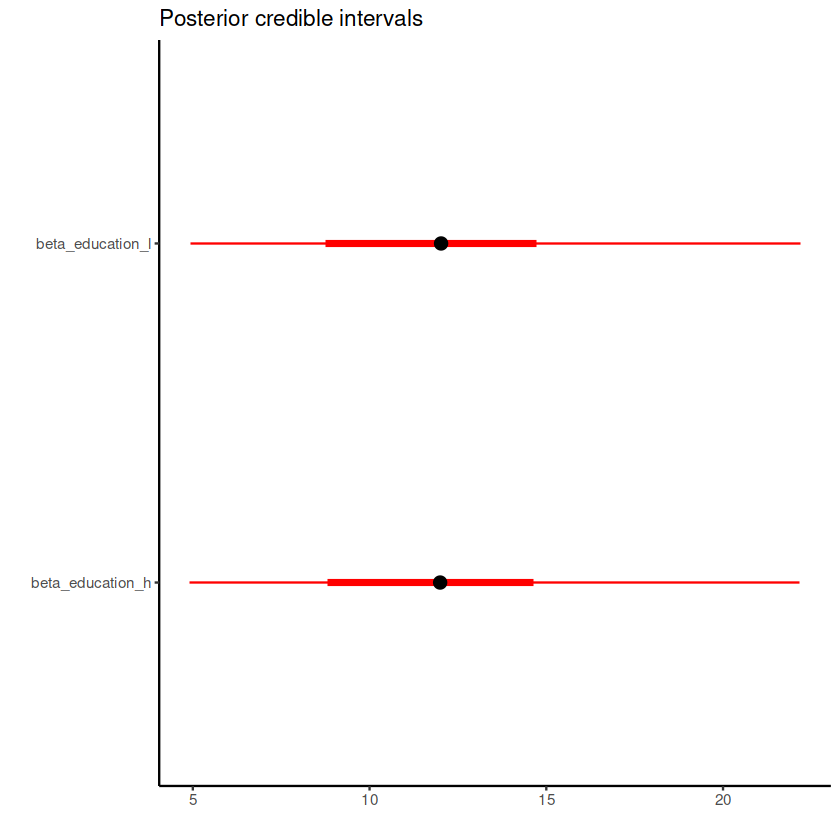

In [10]:
generate_fake_data <- function(n1, n2) {
  beta_education_l_fake <- 12  
  beta_education_h_fake <- 14
  
  # Générer des données factices à partir de la distribution de Poisson
  y1_fake <- rpois(n1, beta_education_l_fake)
  y2_fake <- rpois(n2, beta_education_h_fake)
  
  return(list(y1_fake = y1_fake, y2_fake = y2_fake))
}

# Générer des données factices à partir des échantillons postérieurs
fake_data <- generate_fake_data(length(education_l), length(education_h))


data_list <- list(y1 = fake_data$y1_fake, y2 = fake_data$y2_fake, n1 = length(fake_data$y1_fake), n2 = length(fake_data$y2_fake))

summary(fake_data$y1_fake)
summary(fake_data$y2_fake)
summary(y1_education)
summary(y2_education)


# Compiling and producing posterior samples from the model.
jags_samples_education2 <- run.jags(model = model_string_education, data = data_list, monitor = c("beta_education_l", "beta_education_h"))

# Plotting and summarizing the posterior distribution
jags_samples_education2
plot_credible_intervals(jags_samples_education2)

## Conclusion

Les résultats montrent une bonne convergence et une estimation précise des paramètres.

Les intervalles de crédibilité à 95% pour beta_education_l et beta_education_h sont bien définis, sans chevauchement avec zéro, ce qui suggère que les deux paramètres sont significatifs.

Les valeurs de psrf proches de 1 et les petites erreurs MCMC indiquent que les chaînes MCMC ont bien convergé.

L'écart-type est faible, ce qui montre que les estimations des paramètres sont relativement précises.

# Variable South

<img src="image-20250330-164413.png" width="" align="" />

## Vraisemblance

Étant donné que "south" est une variable binaire (Non-South, South), une distribution de Bernoulli est appropriée pour modéliser cette variable. La fonction de vraisemblance pour une variable de Bernoulli est donnée par : 

$X_{i,s} \sim \text{Bernoulli}(\beta_{south,s})$ avec $s \in \{l,h\}$

## Choix du Prior

Pour le prior, une distribution Beta est souvent utilisée comme conjugate prior pour une distribution de Bernoulli. La distribution Beta est définie par :

$\beta_{south,s} \sim \mathcal{Beta}(1, 1)$ avec $s \in \{l,h\}$



## Implémentation en Jags

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 5000 iterations...
Running the model for 100000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation

JAGS model summary statistics from 30000 samples (thin = 10; chains = 3; adapt+burnin = 10000):
                                                                            
              Lower95  Median Upper95    Mean      SD Mode     MCerr MC%ofSD
beta_south_l 0.043

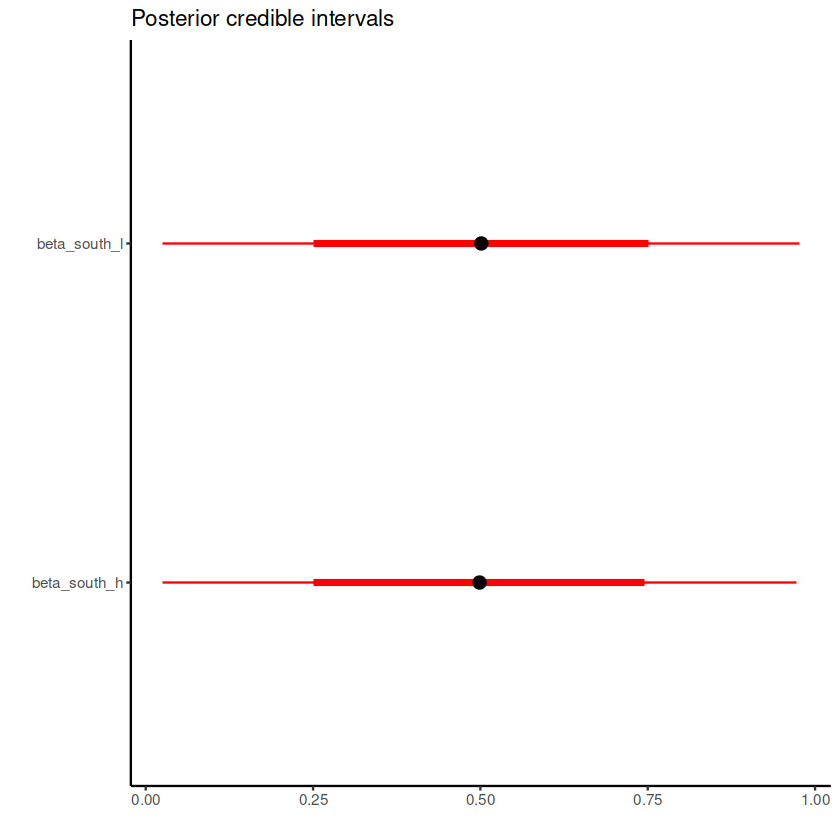

In [11]:
# Get data for each wage level 
south_l <- wage_data$south[wage_data$wage_level == 0]
south_h <- wage_data$south[wage_data$wage_level == 1]

# Convert to numeric vectors
y1_south <- as.numeric(south_l)
y2_south <- as.numeric(south_h)

# Set up data list
data_list <- list(y1 = y1_south, y2 = y2_south, n1 = length(y1_south), n2 = length(y2_south))

# Define model
model_string_south <- "
model {
  # Priors
  beta_south_l ~ dbeta(1, 1)
  beta_south_h ~ dbeta(1, 1)
  
  # Likelihood
  for (i in 1:n1) {
    y1_south[i] ~ dbern(beta_south_l)
  }
  
  for (i in 1:n2) {
    y2_south[i] ~ dbern(beta_south_h)
  }
}
"

# Run JAGS model with more iterations and samples
jags_samples_south <- run.jags(
  model = model_string_south,
  data = data_list,
  monitor = c("beta_south_l", "beta_south_h"),
  n.chains = 3,
  adapt = 5000,
  burnin = 5000,
  sample = 10000,
  thin = 10
)

# Print summary
print(jags_samples_south)
# Plot credible intervals
plot_credible_intervals(jags_samples_south)

[1] 0.4963667

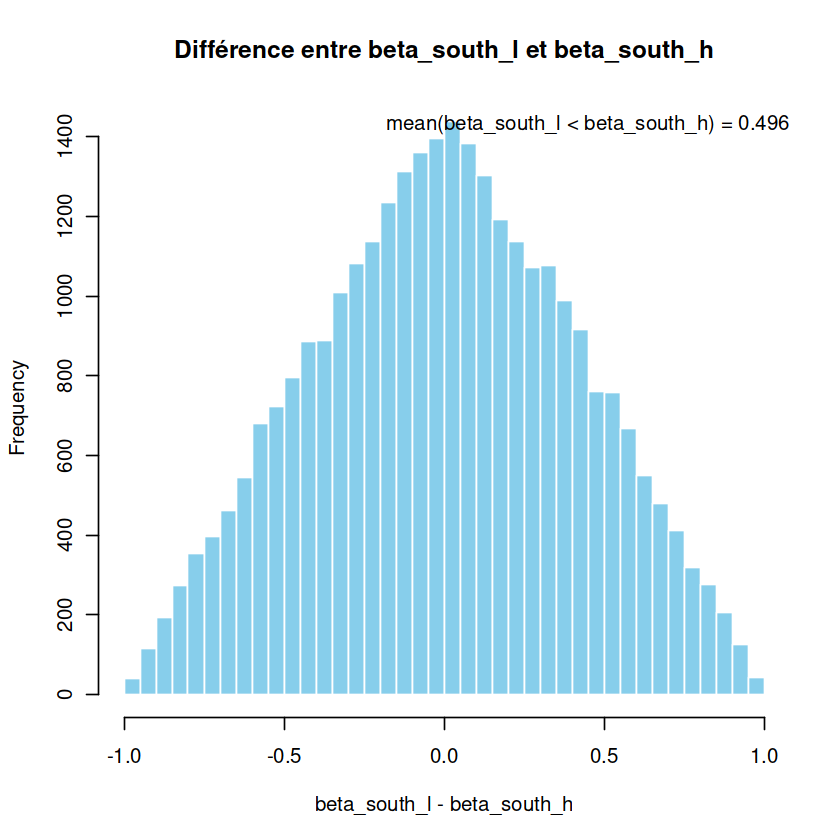

In [12]:
analyze_mcmc_difference(jags_samples_south, "beta_south_l", "beta_south_h")

Il est difficile de démontrer que la localisation géographique dans le sud a un impact distinct et fort sur les salaires bas ou élevés, car les valeurs des betas sont proches de zéro, ce qui suggère une faible relation. Les intervalles de crédibilité incluant 0 confirment que l'effet de la région Sud sur le salaire n'est pas statistiquement significatif.

## MCMC 

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


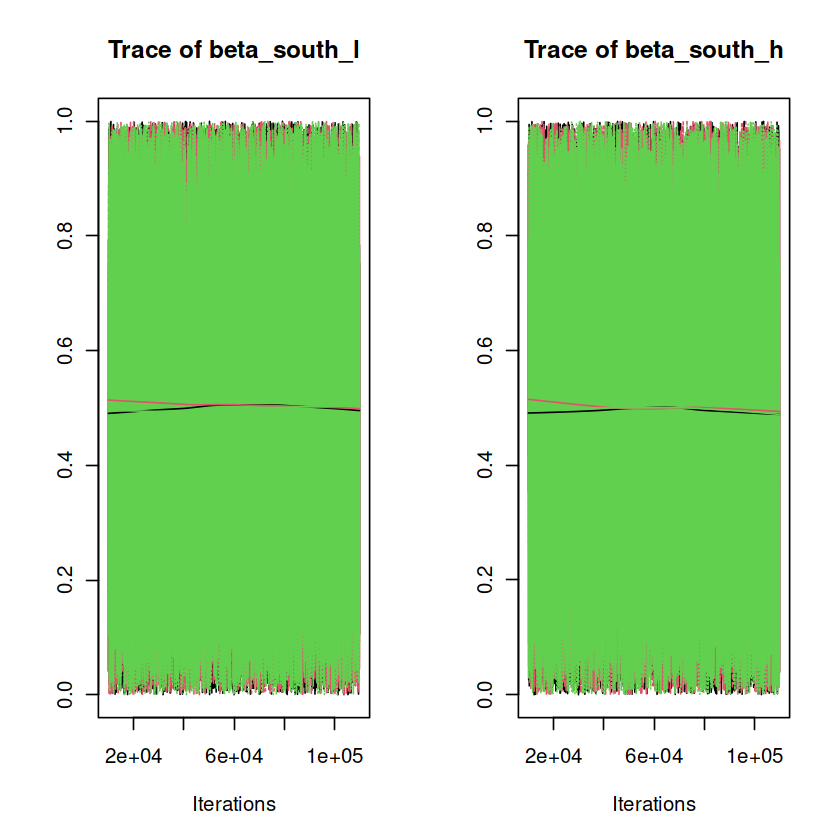

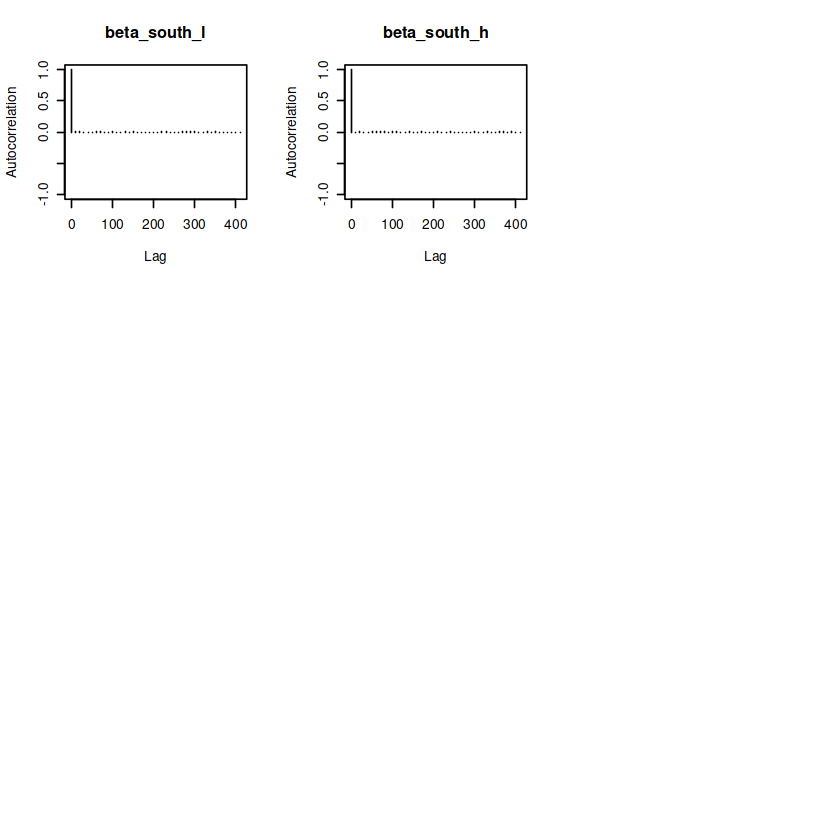

In [13]:
plot_mcmc(jags_samples_south)

Les résultats des modèles sur les données réelles et les données fictives sont similaires. Les deux ensembles montrent une bonne convergence (avec des valeurs PSRF proches de 1)

## Fake data check

Warning message:
“`rbernoulli()` was deprecated in purrr 1.0.0.”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4675  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4834  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.344   2.000   2.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.213   1.000   2.000 

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 5000 iterations...
Running the model for 100000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation

JAGS model summary statistics from 30000 samples (thin = 10; chains = 3; adapt+burnin = 10000):
                                                                            
              Lower95  Median Upper95    Mean      SD Mode     MCerr MC%ofSD
beta_south_l 0.047

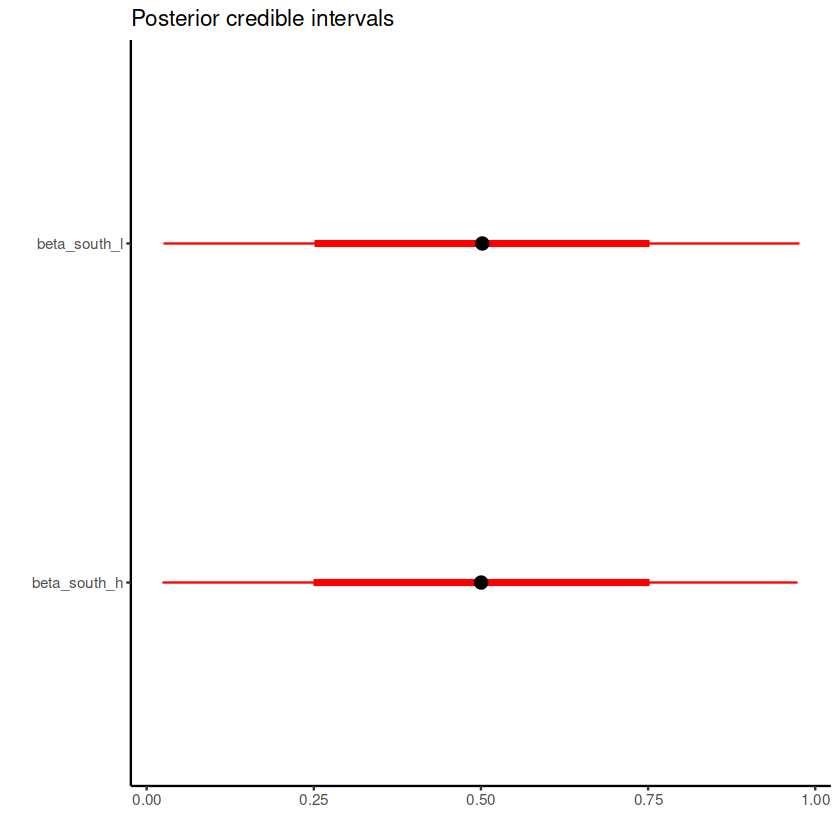

In [14]:
generate_fake_data <- function(n1, n2) {
  beta_south_l_fake <- 0.5
  beta_south_h_fake <- 0.5
  
  # Générer des données factices à partir de la distribution de bernouilli
  # Convert logical to numeric (0/1) values
  y1_fake <- as.numeric(rbernoulli(n1, beta_south_l_fake))
  y2_fake <- as.numeric(rbernoulli(n2, beta_south_h_fake))
  
  return(list(y1_fake = y1_fake, y2_fake = y2_fake))
}

# Générer des données factices à partir des échantillons postérieurs
fake_data <- generate_fake_data(length(south_l), length(south_h))

# Comparer les données factices avec les données réelles
summary(fake_data$y1_fake)
summary(fake_data$y2_fake)
summary(y1_south)
summary(y2_south)

data_list <- list(y1 = fake_data$y1_fake, 
                 y2 = fake_data$y2_fake, 
                 n1 = length(fake_data$y1_fake), 
                 n2 = length(fake_data$y2_fake))

# Compiling and producing posterior samples from the model.
jags_samples_south2 <- run.jags(model = model_string_south,  # Fixed model string name
                              data = data_list, 
                              monitor = c("beta_south_l", "beta_south_h"),
                              n.chains = 3,
                              adapt = 5000,
                              burnin = 5000,
                              sample = 10000,
                              thin = 10)

# Plotting and summarizing the posterior distribution
print(jags_samples_south2)
plot_credible_intervals(jags_samples_south2)

## Conclusion

* Convergence MCMC : les chaînes semblent osciller autour d'une valeur centrale, ce qui est un bon signe de convergence. elles sont bien mélangées et ne montrent pas de tendance systématique, ce qui est un autre indcateur positif de convergence.
Cela suggère que les résultats du modèle peuvent être considérés comme fiables (les distributions postérieurs des coefficients beta_south_l et beta_south_h sont fiables)
* Fake Data Check : Les médianes et moyennes des paramètres beta_south_1 et beta_south_h sont très proches entre les données réelles et fictives, autour de 0.5.Cela suggère que le modèle se comporte de manière similaire dans les deux cas. Les intervalles crédibles à 95% sont larges et se chevauchent largement, ce qui indique une incertitude importante dans l'estimation des paramètres.

# Variable unionmember

<img src="image-20250330-174853.png" width="" align="" />

## Vraisemblance

Etant donné que "unionmember" est une variable binaire (Non-Member, Member), une distribution de Bernoulli est appropriée pour modéliser cette variable avec des priors de loi beta (1,1). 
$$
X_{i,s} \mid \beta_{union,s}\sim B(\beta_{union,s}) \\ 
$$
avec $s \in \{l,h\}$

## Choix du prior

priors :
$$ 
\beta_{union,s} ∼ Beta(1,1)
$$

avec $s \in \{l,h\}$

## Implémentation en Jags

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 5000 iterations...
Running the model for 100000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation

JAGS model summary statistics from 30000 samples (thin = 10; chains = 3; adapt+burnin = 10000):
                                                                             
               Lower95  Median Upper95    Mean      SD Mode     MCerr MC%ofSD
beta_union_l 0.0

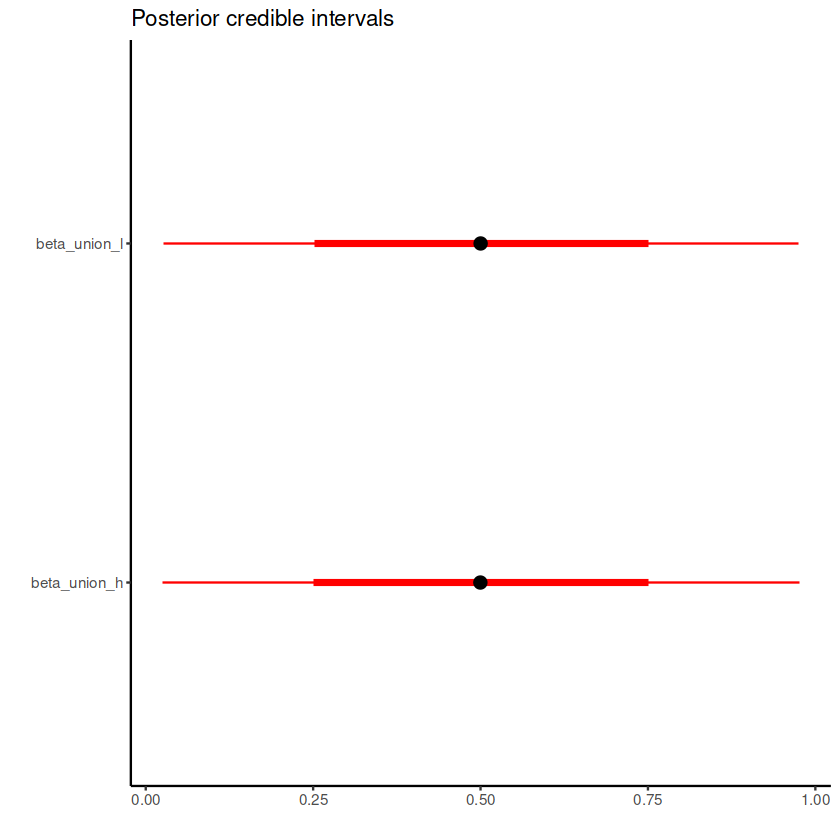

In [15]:
# Get data for each wage level 
union_l <- wage_data$unionmember[wage_data$wage_level == 0]
union_h <- wage_data$unionmember[wage_data$wage_level == 1]

# Convert to numeric vectors
y1_union <- as.numeric(union_l)
y2_union <- as.numeric(union_h)

# Set up data list
data_list <- list(y1 = y1_union, y2 = y2_union, n1 = length(y1_union), n2 = length(y2_union))

# Define model
model_string_union <- "
model {
  # Priors
  beta_union_l ~ dbeta(1, 1)
  beta_union_h ~ dbeta(1, 1)
  
  # Likelihood
  for (i in 1:n1) {
    y1_union[i] ~ dbern(beta_union_l)
  }
  
  for (i in 1:n2) {
    y2_union[i] ~ dbern(beta_union_h)
  }
}
"

# Run JAGS model with more iterations and samples
jags_samples_union <- run.jags(
  model = model_string_union,
  data = data_list,
  monitor = c("beta_union_l", "beta_union_h"),
  n.chains = 3,
  adapt = 5000,
  burnin = 5000,
  sample = 10000,
  thin = 10
)

# Print summary
print(jags_samples_union)
# Plot credible intervals
plot_credible_intervals(jags_samples_union)


[1] 0.5003333

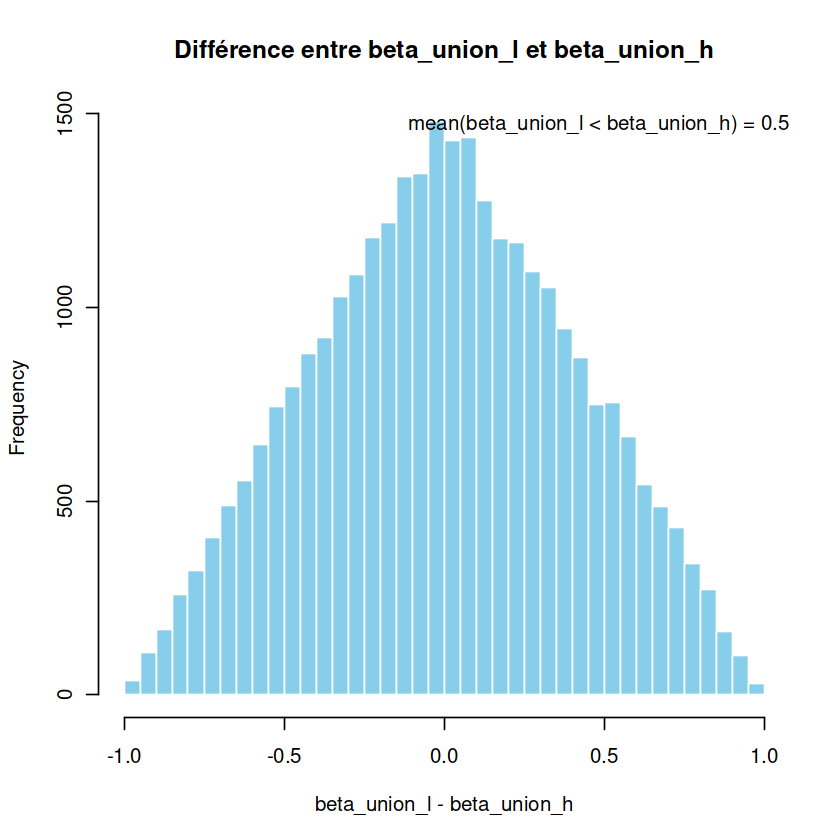

In [16]:
analyze_mcmc_difference(jags_samples_union, "beta_union_l", "beta_union_h")

De même que pour la variable south, il est difficile de démontrer que l'appartenance à un syndicat a un impact distinct et fort sur les salaires bas ou élevés, car les valeurs des betas sont proches de zéro, ce qui suggère une faible relation. Les intervalles de crédibilité incluant 0 renforcent cette conclusion

## MCMC

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


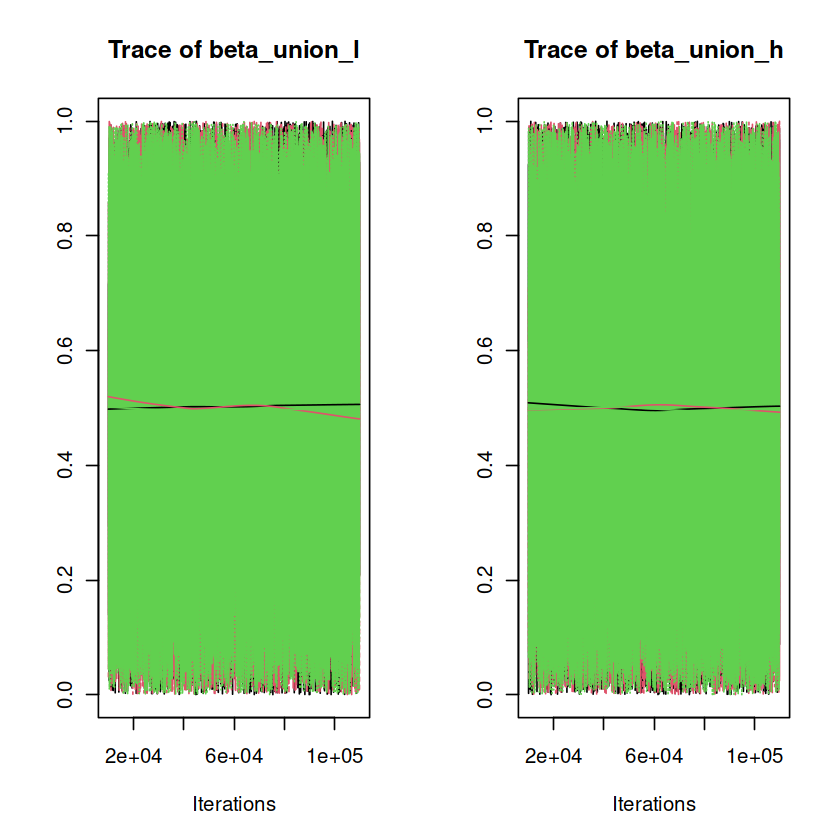

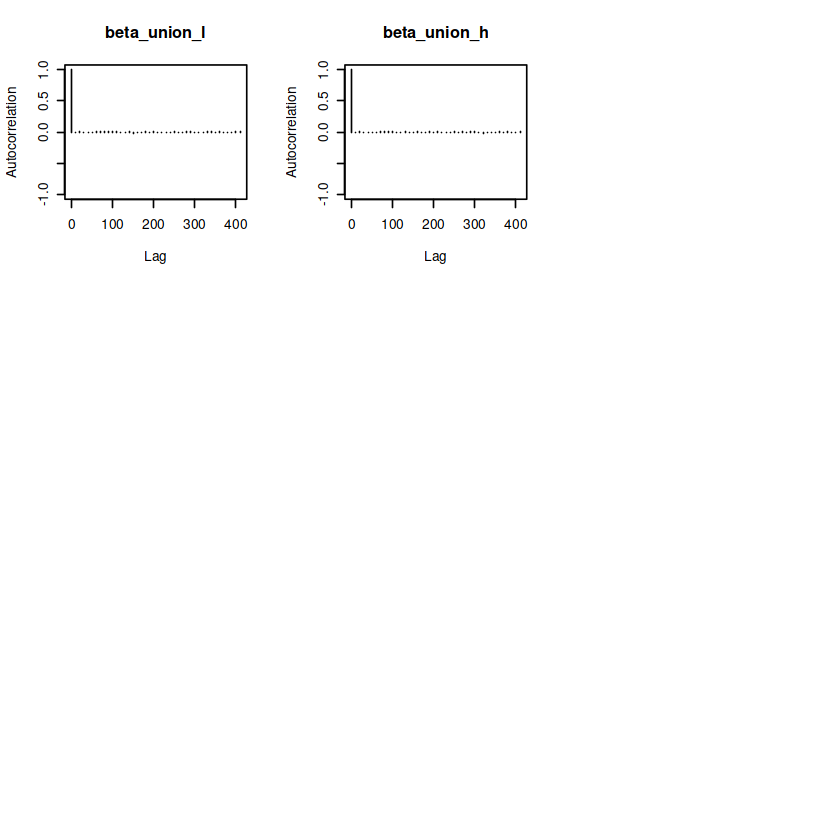

In [17]:
plot_mcmc(jags_samples_union) 

## Fake Check Data

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   0.517   1.000   1.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4834  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.115   1.000   2.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    1.00    1.28    2.00    2.00 

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 5000 iterations...
Running the model for 100000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation

JAGS model summary statistics from 30000 samples (thin = 10; chains = 3; adapt+burnin = 10000):
                                                                             
               Lower95  Median Upper95    Mean      SD Mode     MCerr MC%ofSD
beta_union_l  0.

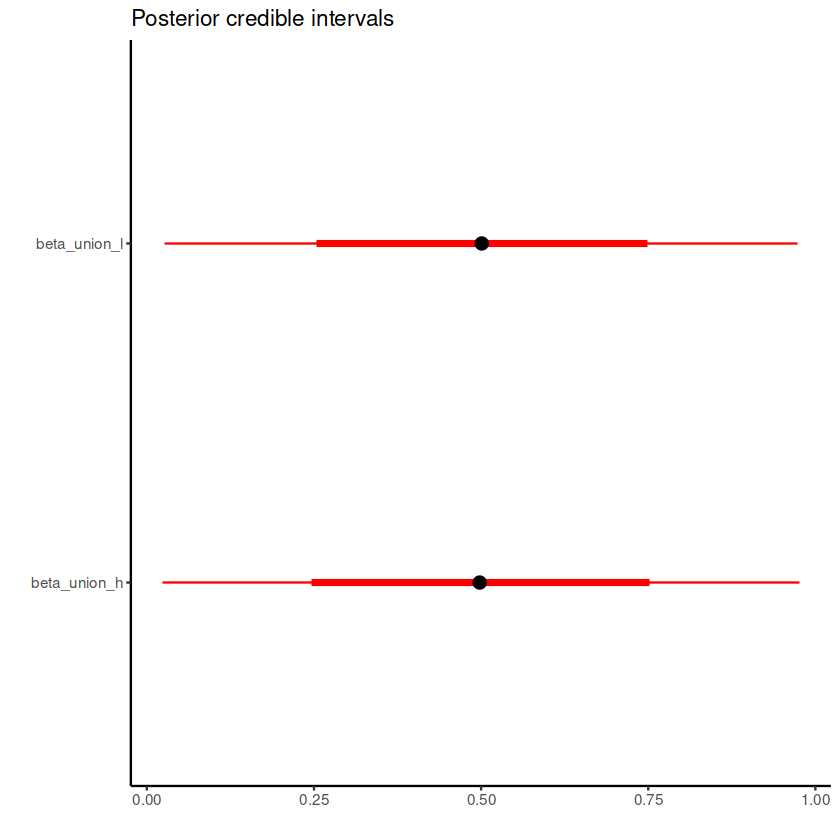

In [18]:
generate_fake_data <- function(n1, n2) {
  beta_union_l_fake <- 0.5
  beta_union_h_fake <- 0.5
  
  # Générer des données factices à partir de la distribution de bernouilli
  # Convert logical to numeric (0/1) values
  y1_fake <- as.numeric(rbernoulli(n1, beta_union_l_fake))
  y2_fake <- as.numeric(rbernoulli(n2, beta_union_h_fake))
  
  return(list(y1_fake = y1_fake, y2_fake = y2_fake))
}

# Générer des données factices à partir des échantillons postérieurs
fake_data <- generate_fake_data(length(union_l), length(union_h))

# Comparer les données factices avec les données réelles
summary(fake_data$y1_fake)
summary(fake_data$y2_fake)
summary(y1_union)
summary(y2_union)

data_list <- list(y1 = fake_data$y1_fake, 
                 y2 = fake_data$y2_fake, 
                 n1 = length(fake_data$y1_fake), 
                 n2 = length(fake_data$y2_fake))

# Compiling and producing posterior samples from the model.
jags_samples_union2 <- run.jags(model = model_string_union,  # Fixed model string name
                              data = data_list, 
                              monitor = c("beta_union_l", "beta_union_h"),
                              n.chains = 3,
                              adapt = 5000,
                              burnin = 5000,
                              sample = 10000,
                              thin = 10)

# Plotting and summarizing the posterior distribution
print(jags_samples_union2)
# Plot credible_interval
plot_credible_intervals(jags_samples_union2)

# Conclusion

* Intervalle crédible :  les IC sont extrêmement larges, ce qui indique une incertitude importante sur l'estimation de l'effet.
* Convergence MCMC : les trajectoires de chaines se chevauchent et restent stationnaires après un certain nombre d'itérations, cela suggère que l'espace des paramètres a été correctement exploré et que les estimations postérieures sont fiables.
* Fake Check Data : Les médianes et moyennes des paramètres beta_union_l et beta_union_h sont très proches de 0.5 dans tous les cas, ce qui suggère que le modèle attribue un effet neutre (ni positif ni négatif) au facteur "syndicat".

 

# Variable Age

On observe que l'age des individus est fortement correle avec l'experience professionnelle, ce qui fait sens puisque plus l'age est grand, plus l'experience professionnelle est longue. Pour éviter une instabilité des estimations, nous supprimons écartons la variable Age.

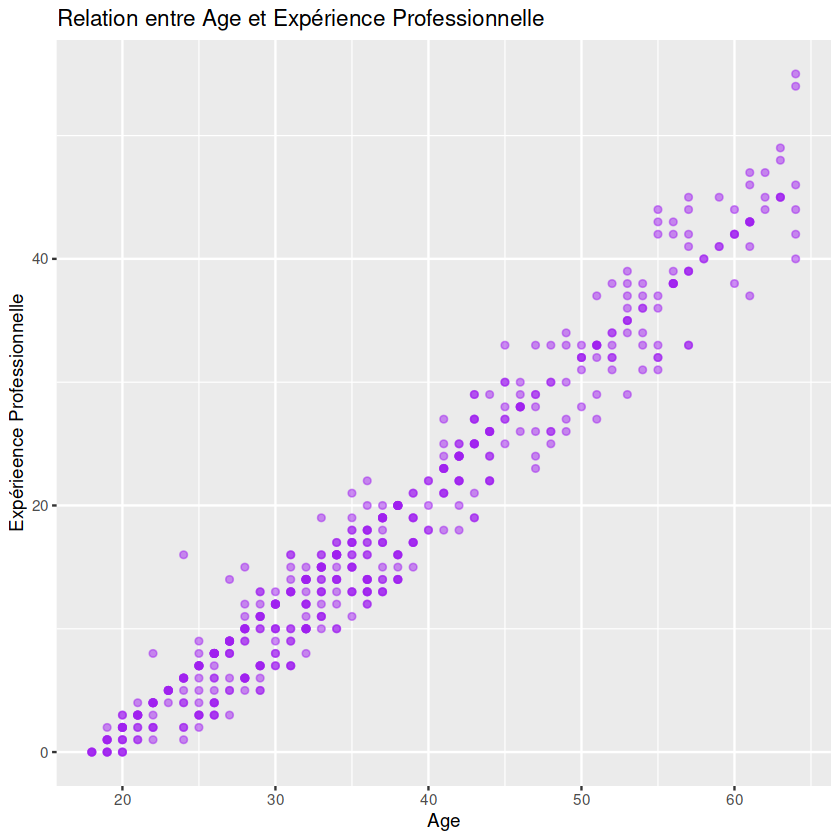

In [19]:
ggplot(wage_data, aes(x=age, y=workexp)) +
  geom_point(alpha=0.5, color="purple") +
  labs(title="Relation entre Age et Expérience Professionnelle", x="Age", y="Expérieence Professionnelle")

# Variable Work experience

<img src="image-20250330-163826.png" width="" align="" />

## Vraisemblance

Une distribution normale semble appropriée pour modéliser les années d'expérience au travail, car les données suivent une forme de cloche.

$X_{i,s} | \beta_{workexp,s} \sim \mathcal{Normal}(\beta_{workexp,s})$

Avec $\beta_{workexp,s} = (\mu_s, \sigma_s)$ et $ s \in \{l,h\}$

## Choix du prior

$\mu_s \sim \mathcal{Uniform}(0, 30)$ 
$\sigma_s \sim \mathcal{Uniform}(0, 50)$

## Implémentation en JAGS

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 10000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 4 variables....
Finished running the simulation



JAGS model summary statistics from 30000 samples (chains = 3; adapt+burnin = 2000):
                                                                        
        Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD SSeff
mu_l    0.89886 15.098  29.283 15.035  8.621   --  0.04962     0.6 30186
sigma_l   2.227  24.87  49.655 25.053 14.469   -- 0.082806     0.6 30533
mu_h    0.23281 14.955  28.701 14.981 8.6588   -- 0.049665     0.6 30396
sigma_h  2.3282  24.94  49.812 24.971 14.449   -- 0.083419     0.6 30000
                          
             AC.10    psrf
mu_l     0.0072317 0.99998
sigma_l  0.0070198       1
mu_h     0.0067934  1.0001
sigma_h -0.0014596 0.99999

Total time taken: 0.4 seconds


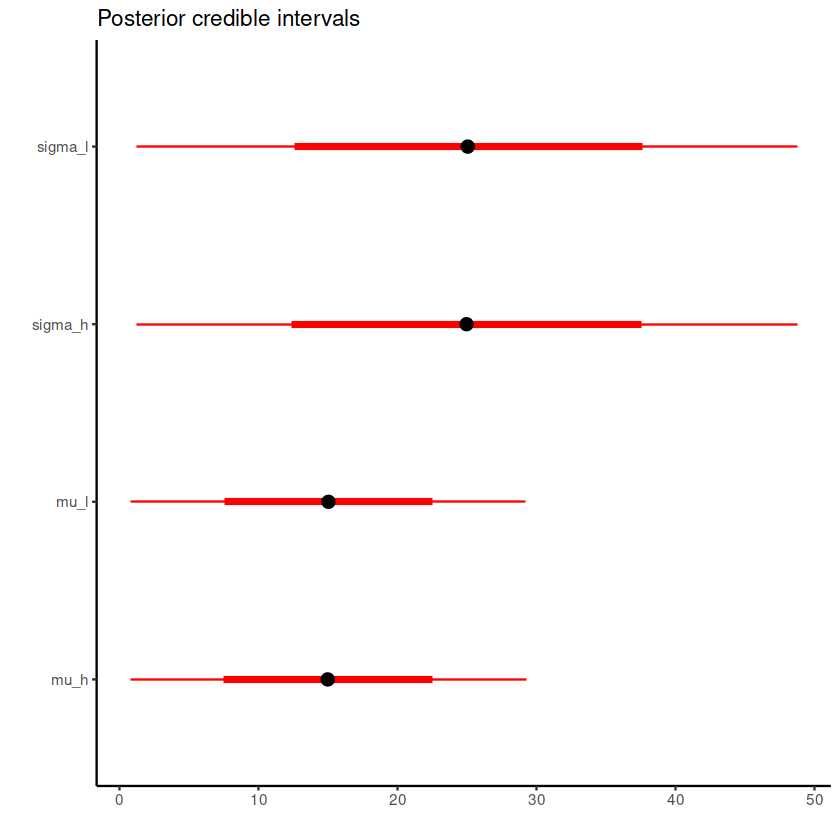

In [20]:
model_string_workexp <- "
model {

  mu_l ~ dunif(0, 30)
  sigma_l ~ dunif(0, 50)
  precision_l <- 1/sigma_l^2

  mu_h ~ dunif(0, 30)
  sigma_h ~ dunif(0, 50)
  precision_h <- 1/sigma_h^2
  
  for (i in 1:n1) {
    y1_workexp[i] ~ dnorm(mu_l, precision_l)
  }
  
  for (i in 1:n2) {
    y2_workexp[i] ~ dnorm(mu_h, precision_h)
  }

  
}
"

# Définition des données
y1_workexp <- wage_data$workexp[wage_data$wage_level == 0]
y2_workexp <- wage_data$workexp[wage_data$wage_level == 1]
data_list <- list(y1 = y1_workexp, y2 = y2_workexp, n1 = length(y1_workexp), n2 = length(y2_workexp))



# Compiling and producing posterior samples from the model.
jags_samples_workexp <- run.jags(model = model_string_workexp, data = data_list, monitor = c("mu_l", "sigma_l", "mu_h", "sigma_h"), n.chains = 3, adapt = 1000, burnin = 1000, thin = 1)

# Plotting and summarizing the posterior distribution
jags_samples_workexp
plot_credible_intervals(jags_samples_workexp)

[1] 0.4973

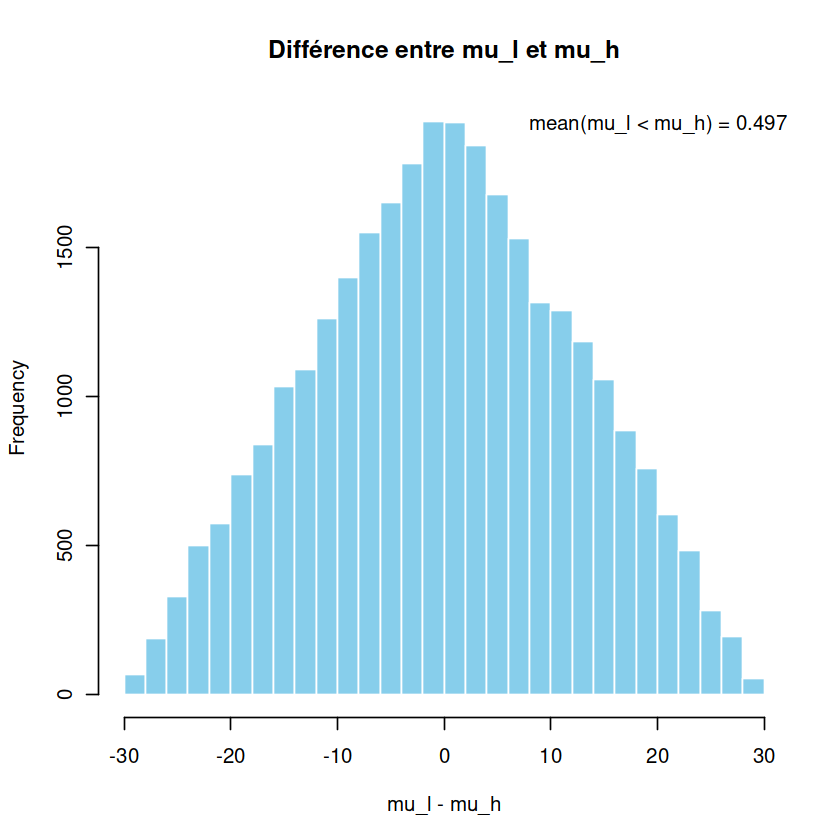

In [21]:
analyze_mcmc_difference(jags_samples_workexp, "mu_l", "mu_h")

Les individus ayant un salaire inférieur à la moyenne ont en moyenne plus d'expérience professionnelle que ceux ayant un salaire supérieur à la moyenne.

## MCMC

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


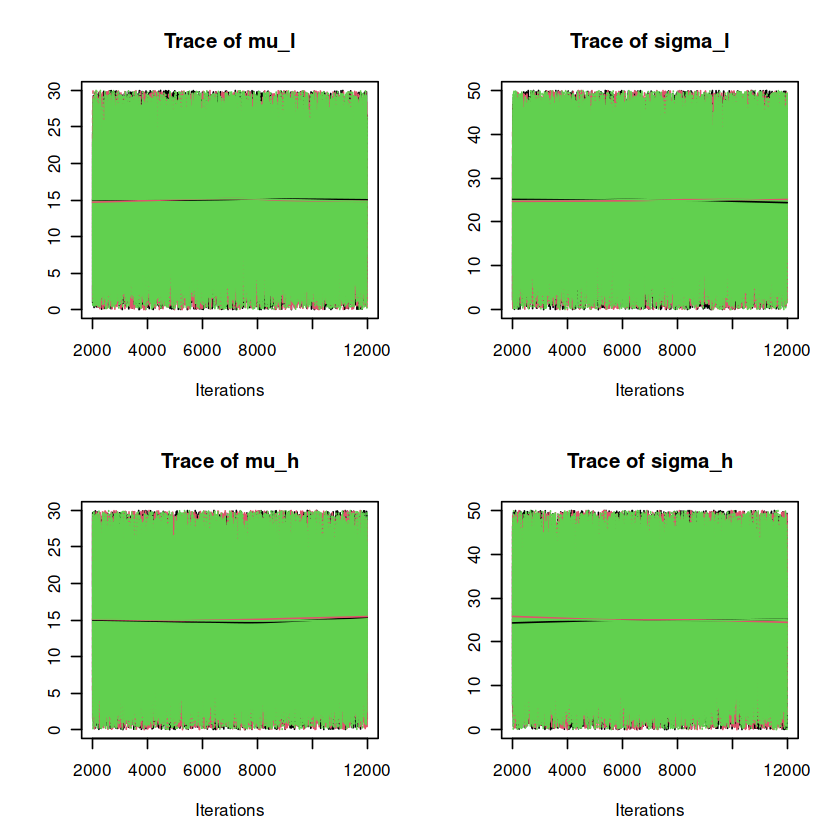

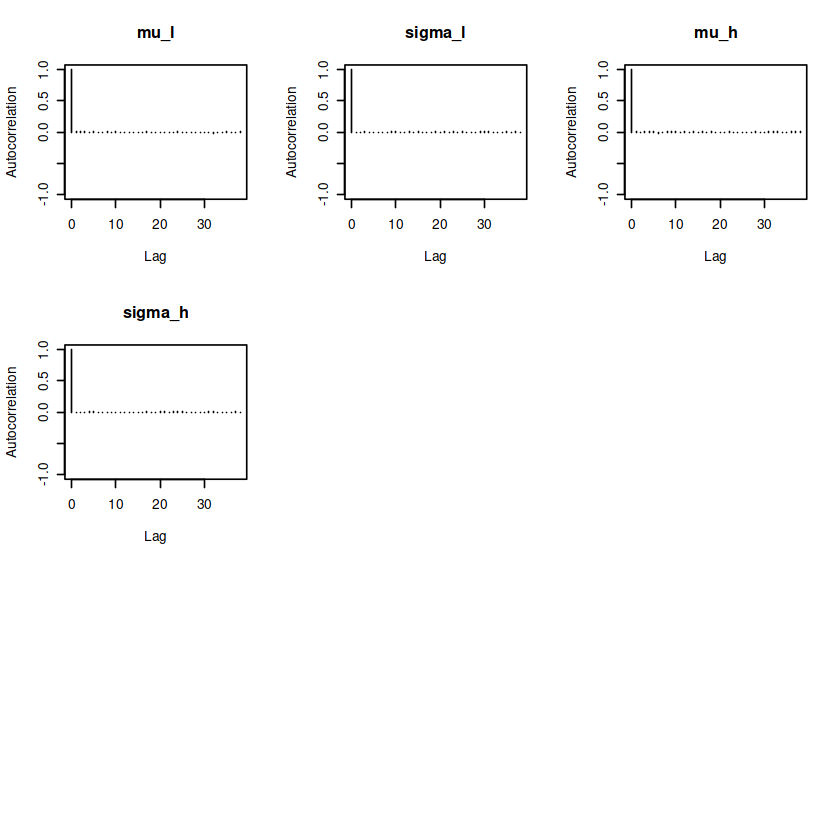

In [22]:
plot_mcmc(jags_samples_workexp)

## Fake data check

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-60.723  -4.688  14.479  13.228  29.913  73.145 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-54.406  -2.994  12.892  13.481  30.615  81.114 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.00   14.00   16.72   25.00   55.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   11.00   16.00   19.51   28.00   46.00 

Warning message:
“No initial value blocks found and n.chains not specified: 2 chains were used”
Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 4000 iterations...
Running the model for 10000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 4 variables....
Finished running the simulation



JAGS model summary statistics from 20000 samples (chains = 2; adapt+burnin = 5000):
                                                                        
        Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD SSeff
mu_l    0.15266 14.987  28.578 15.003 8.6384   -- 0.061082     0.7 20000
sigma_l  1.4628 25.202  48.687 25.012 14.371   --  0.10036     0.7 20503
mu_h    0.08807  14.87  28.553 14.951 8.6399   -- 0.062981     0.7 18819
sigma_h   1.282  24.98  48.759 25.001 14.426   --  0.10125     0.7 20298
                          
             AC.10    psrf
mu_l     0.0035391 0.99996
sigma_l -0.0013089  1.0001
mu_h     -0.010981 0.99997
sigma_h -0.0029849  1.0001

Total time taken: 0.2 seconds


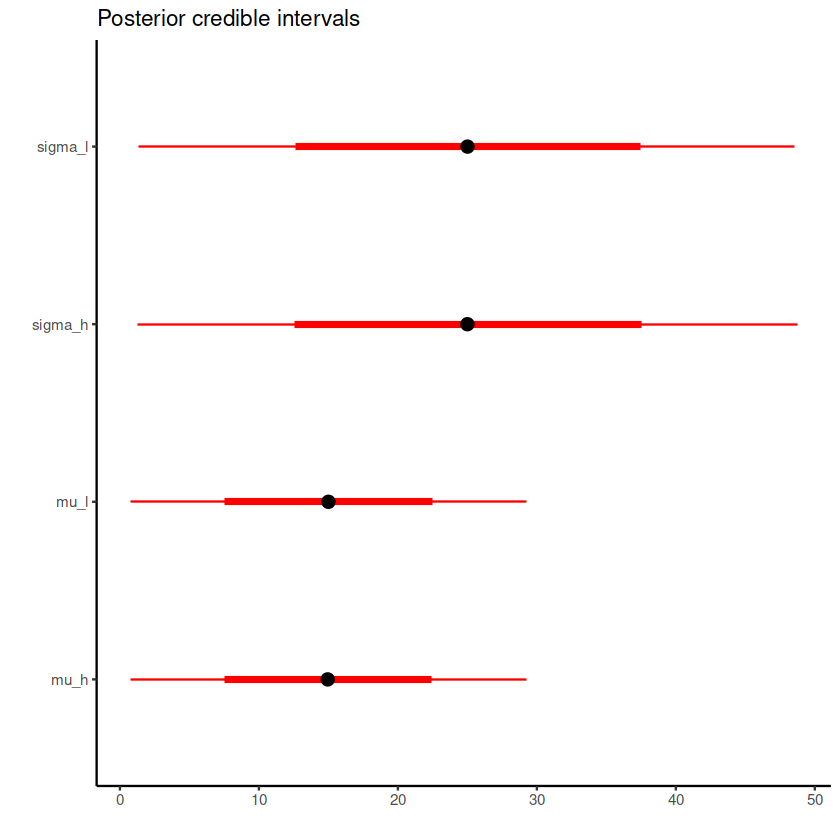

In [23]:
generate_fake_data <- function(n1, n2) {
    mu_l_fake <- 15
    sigma_l_fake <- 25
    mu_h_fake <- 15
    sigma_h_fake <- 24
  
  # Générer des données factices à partir de la distribution de Poisson
  y1_fake <- rnorm(n1, mu_l_fake, sigma_l_fake)
  y2_fake <- rnorm(n2, mu_h_fake, sigma_h_fake)
  
  return(list(y1_fake = y1_fake, y2_fake = y2_fake))
}

# Générer des données factices à partir des échantillons postérieurs
fake_data <- generate_fake_data(length(y1_workexp), length(y2_workexp))

# Comparer les données factices avec les données réelles
summary(fake_data$y1_fake)
summary(fake_data$y2_fake)
summary(y1_workexp)
summary(y2_workexp)

data_list <- list(y1 = fake_data$y1_fake, y2 = fake_data$y2_fake, n1 = length(fake_data$y1_fake), n2 = length(fake_data$y2_fake))


# Compiling and producing posterior samples from the model.
jags_samples_workexp2 <- run.jags(model = model_string_workexp, data = data_list, monitor = c("mu_l", "sigma_l", "mu_h", "sigma_h"))

# Plotting and summarizing the posterior distribution
jags_samples_workexp2
plot_credible_intervals(jags_samples_workexp2)

# Variable female

<img src="image-20250330-165243.png" width="" align="" />

## Vraisemblance

Chaque observation suit une loi de Bernoulli :

$X_{i,s} \sim \text{Bernoulli}(\beta_{female,s})$

avec $ s \in \{l,h\}$


## Choix du Prior

$\beta_{female,l} \sim \mathcal{Beta}(173, 151)$
$\beta_{female,h} \sim \mathcal{Beta}(74, 134)$

## Implémentation en JAGS

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 5000 iterations...
Running the model for 100000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation

JAGS model summary statistics from 30000 samples (thin = 10; chains = 3; adapt+burnin = 10000):
                                                                              
              Lower95  Median Upper95    Mean       SD Mode      MCerr MC%ofSD
beta_female_l 

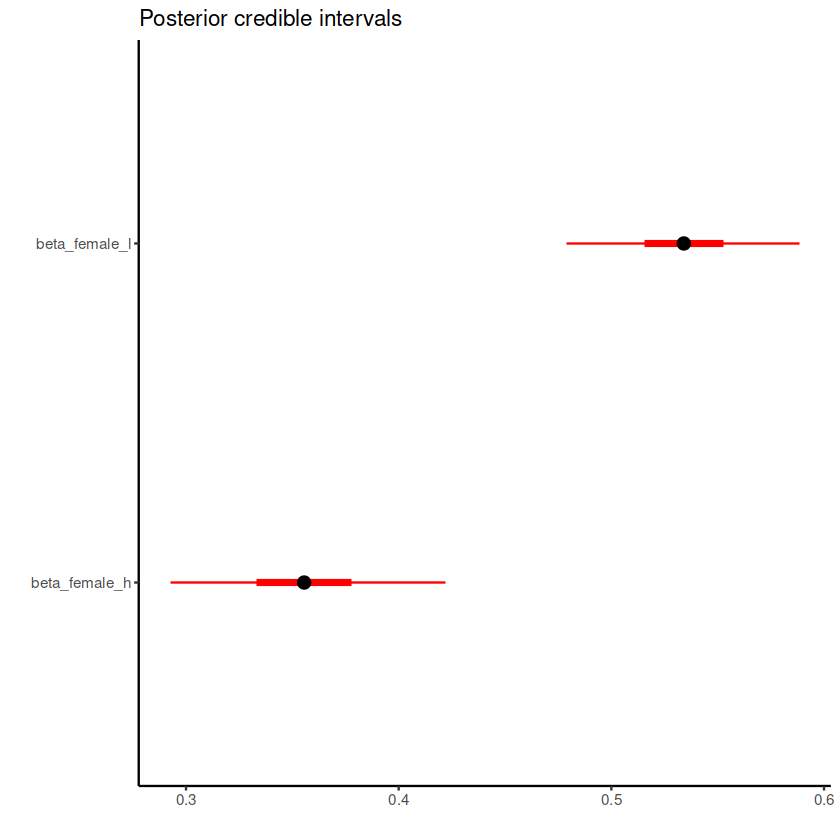

In [24]:
# Get data for each wage level 
female_l <- wage_data$female[wage_data$wage_level == 0]
female_h <- wage_data$female[wage_data$wage_level == 1]

# Convert to numeric vectors
y1_female <- as.numeric(female_l)
y2_female <- as.numeric(female_h)

# Set up data list
data_list <- list(y1 = y1_female, y2 = y2_female, n1 = length(y1_female), n2 = length(y2_female))

# Define model
model_string_female <- "
model {
  # Priors
  beta_female_l ~ dbeta(173, 151)
  beta_female_h ~ dbeta(74, 134)
  
  # Likelihood
  for (i in 1:n1) {
    y1_female[i] ~ dbern(beta_female_l)
  }
  
  for (i in 1:n2) {
    y2_female[i] ~ dbern(beta_female_h)
  }
}
"

# Run JAGS model with more iterations and samples
jags_samples_female <- run.jags(
  model = model_string_female,
  data = data_list,
  monitor = c("beta_female_l", "beta_female_h"),
  n.chains = 3,
  adapt = 5000,
  burnin = 5000,
  sample = 10000,
  thin = 10
)

# Print summary
print(jags_samples_female)
# Plot credible intervals
plot_credible_intervals(jags_samples_female)

[1] 0

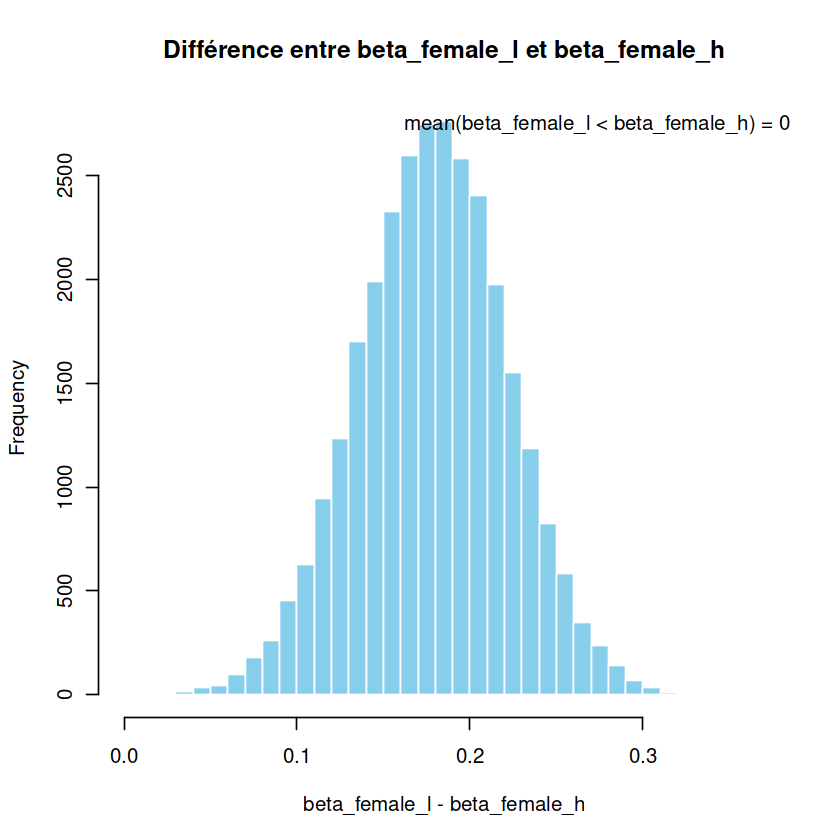

In [25]:
analyze_mcmc_difference(jags_samples_female, "beta_female_l", "beta_female_h")

L'effet d'être une femme est plus fort pour les bas salaires que pour les hauts salaires.

## MCMC

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


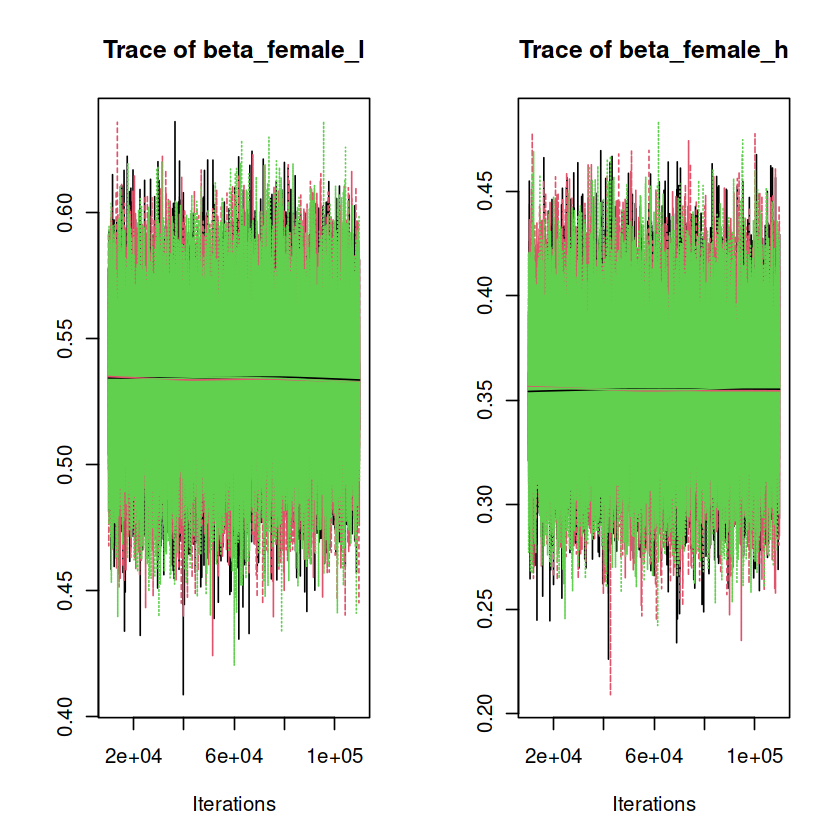

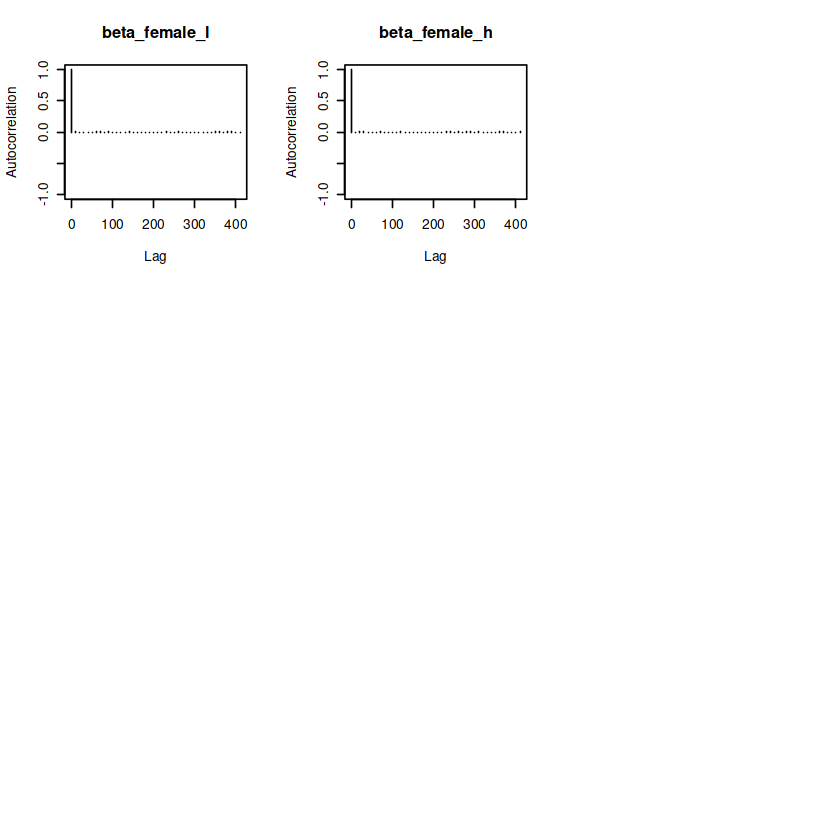

In [26]:
plot_mcmc(jags_samples_female)

## Fake data check

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4737  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4976  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.529   2.000   2.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.351   2.000   2.000 

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 5000 iterations...
Running the model for 100000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation

JAGS model summary statistics from 30000 samples (thin = 10; chains = 3; adapt+burnin = 10000):
                                                                              
              Lower95  Median Upper95    Mean       SD Mode      MCerr MC%ofSD
beta_female_l 

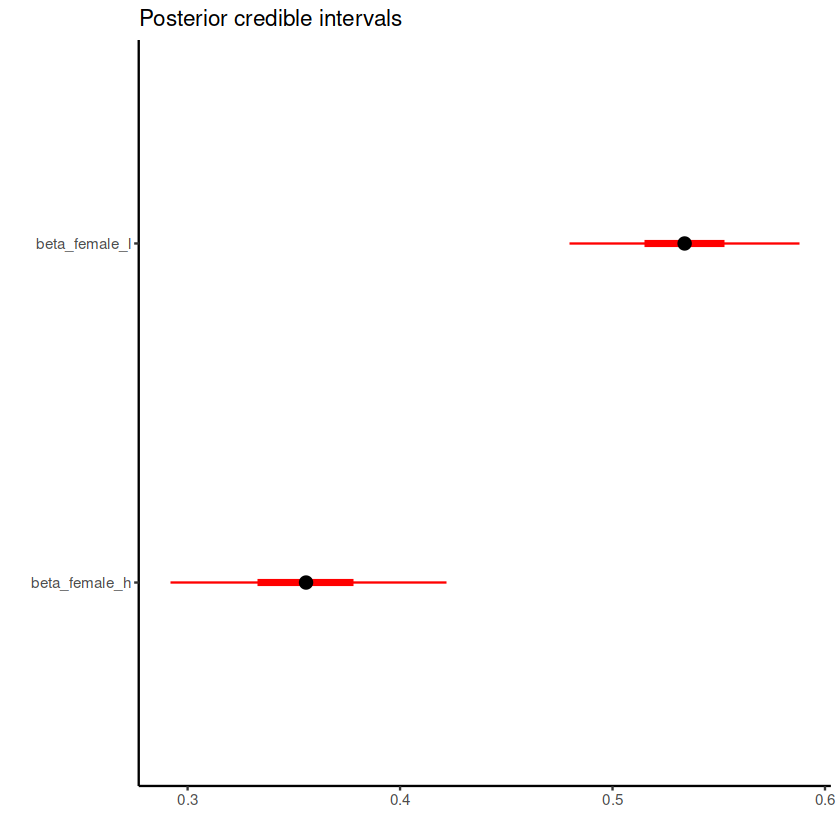

In [27]:
generate_fake_data <- function(n1, n2) {
  beta_female_l_fake <- 0.5
  beta_female_h_fake <- 0.5
  
  # Générer des données factices à partir de la distribution de bernouilli
  # Convert logical to numeric (0/1) values
  y1_fake <- as.numeric(rbernoulli(n1, beta_female_l_fake))
  y2_fake <- as.numeric(rbernoulli(n2, beta_female_h_fake))
  
  return(list(y1_fake = y1_fake, y2_fake = y2_fake))
}

# Générer des données factices à partir des échantillons postérieurs
fake_data <- generate_fake_data(length(female_l), length(female_h))

# Comparer les données factices avec les données réelles
summary(fake_data$y1_fake)
summary(fake_data$y2_fake)
summary(y1_female)
summary(y2_female)

data_list <- list(y1 = fake_data$y1_fake, 
                 y2 = fake_data$y2_fake, 
                 n1 = length(fake_data$y1_fake), 
                 n2 = length(fake_data$y2_fake))

# Compiling and producing posterior samples from the model.
jags_samples_female2 <- run.jags(model = model_string_female,  # Fixed model string name
                              data = data_list, 
                              monitor = c("beta_female_l", "beta_female_h"),
                              n.chains = 3,
                              adapt = 5000,
                              burnin = 5000,
                              sample = 10000,
                              thin = 10)

# Plotting and summarizing the posterior distribution
print(jags_samples_female2)
plot_credible_intervals(jags_samples_female2)

## Conclusion

### Interprétation

- 🔹 **`beta_female_l`** : Le modèle estime à **53.5 %** la probabilité que la femme classée comme ayant un **salaire faible** soit effectivement dans ce cas.
- 🔹 **`beta_female_h`** : La probabilité estimée d’un **salaire élevé** pour la deuxième femme est de **35.9 %**, ce qui reflète une **plus grande incertitude**.

### Convergence

- Tous les diagnostics sont bons :
  - MC%ofSD < 1 %
  - PSRF proche de 1
  - Taille effective > 14 000

Cela indique que les chaînes MCMC ont bien convergé.

# Variable Married

<img src="image-20250330-164951.png" width="" align="" />

## Vraisemblance


Etant donné que "married" est une variable binaire (Single, Married), une distribution de Bernoulli est appropriée pour modéliser cette variable. La fonction de vraisemblance pour une variable de Bernoulli est donnée par :

$X_{i,s} \sim \text{Bernoulli}(\beta_{married,s})$ avec $s \in \{l,h\}$



## Choix du Prior

En ce qui concerne le choix du prior, la distribution Beta est couramment utilisée comme prior conjugué pour une distribution de Bernoulli.

Pour le choix des paramètres du prior et à partir de l’histogramme, on considère :

$\beta_{married,l} \sim \mathcal{Beta}(191, 131)$ 
$\beta_{married,l} \sim \mathcal{Beta}(161, 61)$ 

## Implémentation en JAGS

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y1" in data”
Warning message in rjags::jags.model(model, data = dataenv, n.chains = length(runjags.object$end.state), :
“Unused variable "y2" in data”
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation



JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                               
               Lower95  Median Upper95    Mean       SD Mode      MCerr MC%ofSD
beta_married_l 0.53939 0.59328 0.64536 0.59307 0.027132   -- 0.00021018     0.8
beta_married_h 0.66559 0.72578 0.78445 0.72517  0.03034   -- 0.00025518     0.8
                                      
               SSeff      AC.10   psrf
beta_married_l 16663 -0.0098907 1.0001
beta_married_h 14136  -0.015737 1.0001

Total time taken: 0.1 seconds


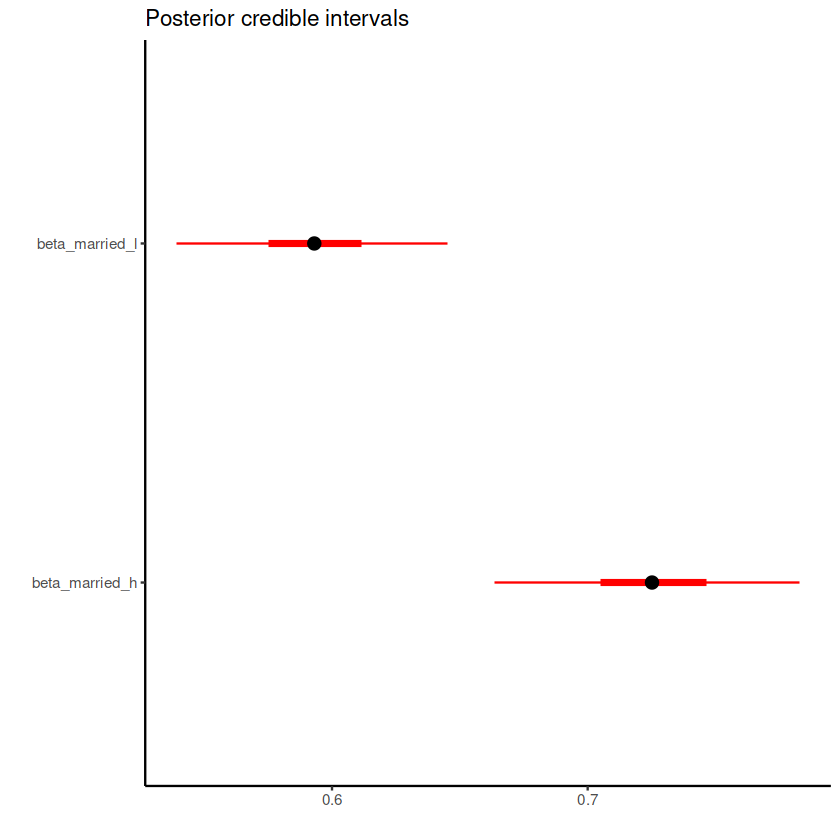

In [28]:
# ------------------------------
# 1. Définir le modèle JAGS (avec priors informatifs)
# ------------------------------
model_string_married <- "
model {

  # Priors inspirés des données observées
  beta_married_l ~ dbeta(191, 131)  # pour salaire < moyenne
  beta_married_h ~ dbeta(161, 61)   # pour salaire ≥ moyenne

  # Vraisemblance
  for (i in 1:n1) {
    y1_married[i] ~ dbern(beta_married_l)
  }

  for (i in 1:n2) {
    y2_married[i] ~ dbern(beta_married_h)
  }
} 
"

# ------------------------------
# 2. Préparer les données
# ------------------------------
# Convertir la variable 'married' en binaire (1 = Married, 0 = Single)
wage_data$married <- as.numeric(wage_data$married == "Married")

# Séparer selon le niveau de salaire
married_l <- wage_data$married[wage_data$wage_level == 0]  # faible salaire
married_h <- wage_data$married[wage_data$wage_level == 1]  # haut salaire

# Convertir en vecteur numérique
y1_married <- as.numeric(married_l)
y2_married <- as.numeric(married_h)

# Créer la liste des données
data_list_married <- list(
  y1 = y1_married,
  y2 = y2_married,
  n1 = length(married_l),
  n2 = length(married_h)
)

# ------------------------------
# 3. Exécuter le modèle
# ------------------------------

jags_samples_married <- run.jags(
  model = model_string_married,
  data = data_list_married,
  monitor = c("beta_married_l", "beta_married_h"),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000,
  thin = 1
)


# ------------------------------
# 4. Résultats
# ------------------------------
jags_samples_married
plot_credible_intervals(jags_samples_married)



[1] 0.9989333

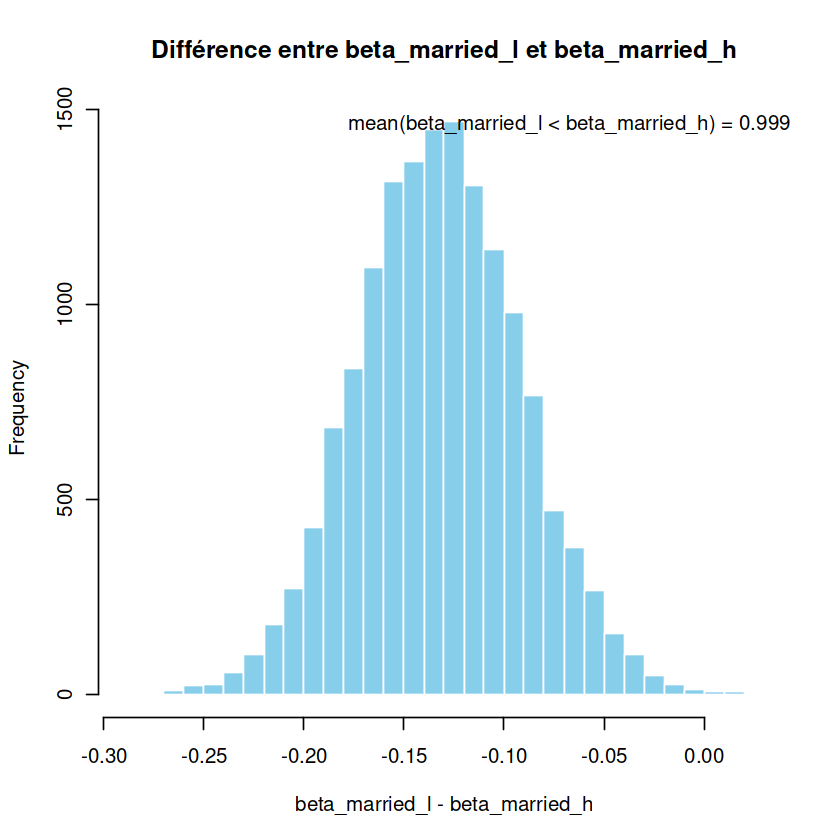

In [29]:
analyze_mcmc_difference(jags_samples_married, "beta_married_l", "beta_married_h")

être marié est fortement associé à un salaire plus élevé dans le modèle.

## MCMC

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


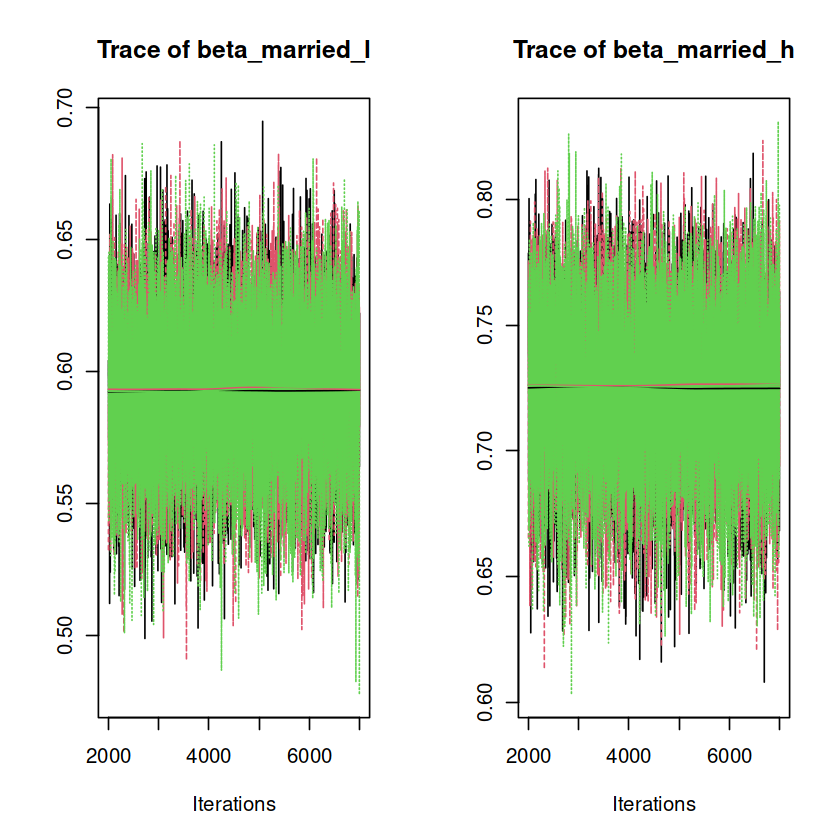

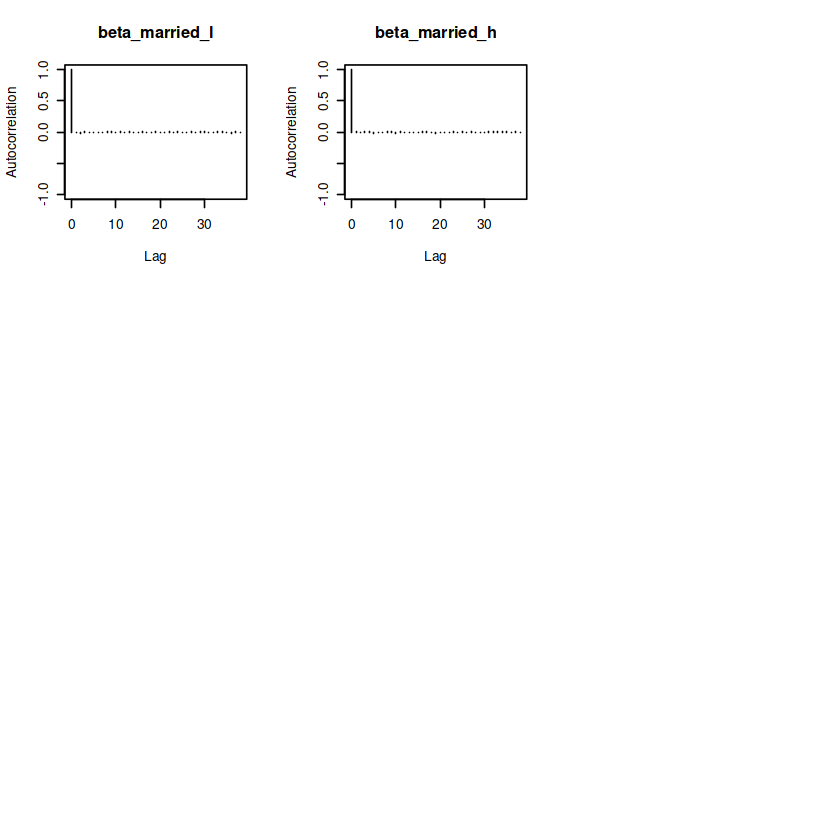

In [30]:
plot_mcmc(jags_samples_married)

## Fake data check

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.5975  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.7441  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.6006  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.7393  1.0000  1.0000 

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation



JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                               
               Lower95  Median Upper95    Mean       SD Mode      MCerr MC%ofSD
beta_married_l 0.55632 0.59541 0.63273 0.59537 0.019417   -- 0.00015854     0.8
beta_married_h 0.69319 0.73463 0.77535 0.73421 0.021098   -- 0.00017227     0.8
                                       
               SSeff      AC.10    psrf
beta_married_l 15000 -0.0074439  1.0001
beta_married_h 15000  0.0093249 0.99998

Total time taken: 0.2 seconds


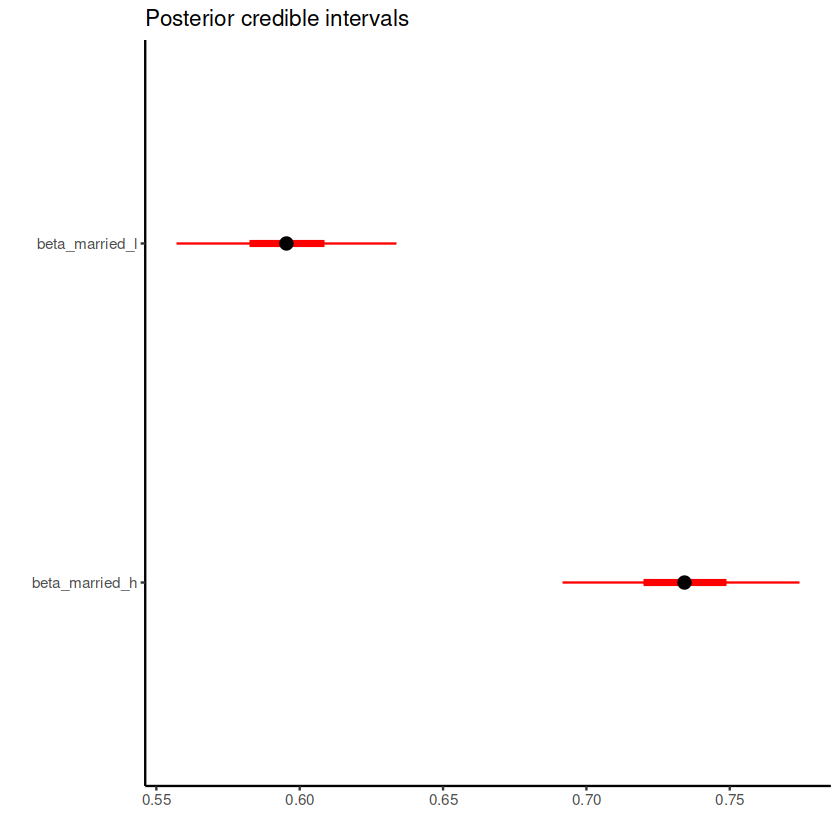

In [31]:
# ------------------------------
# 1. Générer des données factices de statut marital par niveau de salaire
# ------------------------------
generate_fake_married_data <- function(n_low, n_high, p_low = 0.59, p_high = 0.73) {
  # Générer pour les faibles salaires
  y1 <- rbinom(n_low, 1, p_low)

  # Générer pour les hauts salaires
  y2 <- rbinom(n_high, 1, p_high)

  return(list(y1 = y1, y2 = y2))
}


# ------------------------------
# 2. Generate fake data
# ------------------------------

n1 <- length(married_l)
n2 <- length(married_h)

set.seed(123)
fake <- generate_fake_married_data(n1, n2)

data_list_fake_married <- list(
  y1 = fake$y1,
  y2 = fake$y2,
  n1 = n1,
  n2 = n2
)

# Comparer les données factices avec les données réelles
summary(fake$y1)
summary(fake$y2)
summary(y1_married)
summary(y2_married)

# ------------------------------
# 3. JAGS model (adjusted for married)
# ------------------------------
model_string_married <- "
model {
  # Priors basés sur l'histogramme
  beta_married_l ~ dbeta(191, 131)
  beta_married_h ~ dbeta(161, 61)

  # Vraisemblance Bernoulli pour chaque groupe
  for (i in 1:n1) {
    y1[i] ~ dbern(beta_married_l)
  }

  for (i in 1:n2) {
    y2[i] ~ dbern(beta_married_h)
  }
}
"


# ------------------------------
# 4. Run the model
# ------------------------------

jags_samples_married2 <- run.jags(
  model = model_string_married,
  data = data_list_fake_married,
  monitor = c("beta_married_l", "beta_married_h"),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000
)


# ------------------------------
# 5. Examine results
# ------------------------------
jags_samples_married2
plot_credible_intervals(jags_samples_married2)


## Conclusion

### Interprétation

- Parmi les individus ayant un **salaire inférieur à la moyenne**, la probabilité d’être marié est estimée à **59,5 %**, avec un intervalle de crédibilité à 95 % entre **55,9 % et 63,4 %**.
  
- Pour les individus ayant un **salaire supérieur ou égal à la moyenne**, cette probabilité est plus élevée : **73,3 %**, avec un intervalle de crédibilité entre **69,3 % et 77,5 %**.

---

### Convergence MCMC

- Tous les diagnostics sont bons :
  - MC%ofSD < 1 %
  - PSRF ≈ 1
  - Taille effective > 14 000

Les chaînes ont bien convergé : les résultats sont fiables et interprétables.

# Variable ethnicity

<img src="image-20250330-170259.png" width="" align="" />

## Vraisemblance

$$
X_{k,s}|\beta_{k,s} \sim \text{Poisson}(\beta_{k,s})
$$

Avec k représente la catégorie de ethnicity (individu White, individu Other, individu Hisp).

## Choix du prior


$$
\begin{align*}
\beta_{\text{White}, \ell} &\sim \text{Gamma}(9, 0.1) \\
\beta_{\text{White}, h} &\sim \text{Gamma}(18, 0.1) \\
\\
\beta_{\text{Other}, \ell} &\sim \text{Gamma}(4.5, 0.1) \\
\beta_{\text{Other}, h} &\sim \text{Gamma}(3, 0.1) \\
\\
\beta_{\text{Hispanic}, \ell} &\sim \text{Gamma}(2.5, 0.1) \\
\beta_{\text{Hispanic}, h} &\sim \text{Gamma}(1, 0.1)
\end{align*}
$$



## Implémentation en JAGS

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 6 variables....
Finished running the simulation

JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                          
                Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD
beta_white_l     210.98 238.62  268.11 239.09 14.791   --  0.11962     0.8
beta_white_h     160.15 185.22  211.37 185.58 13.045   --  0.10742     0.8
beta_other_l     34.548 46.478  59.588 46.759 6.4656   -- 0.053293     0.8
beta_other_h     12.709 20.626  29.384 20.904 4.3227   -- 0.035295     0.8
beta_hispani

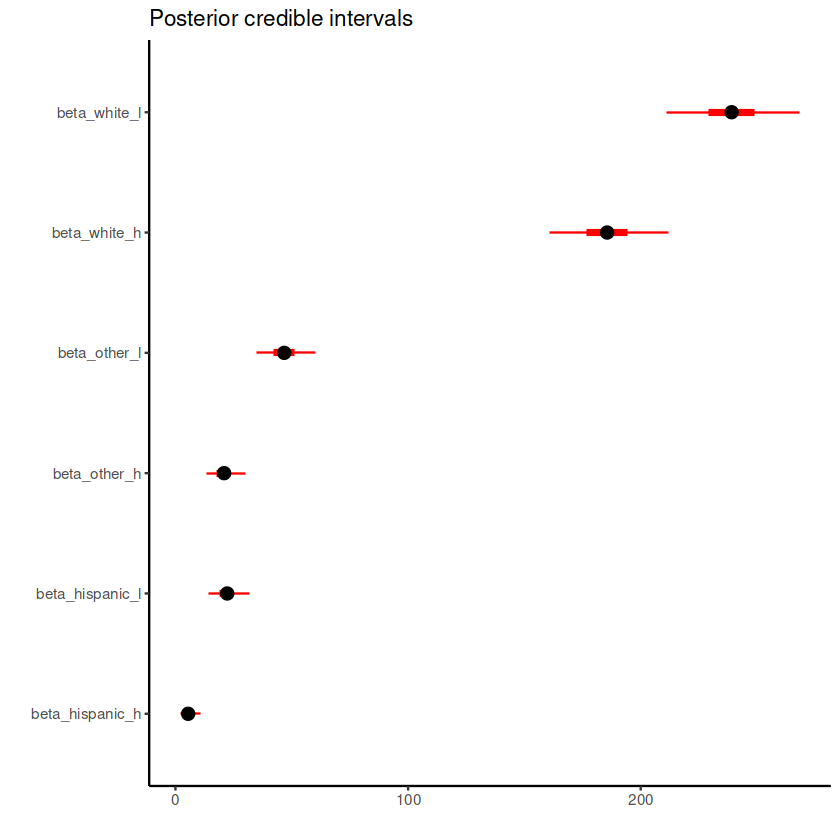

In [32]:
# ------------------------------
# 1. Préparer les données (agrégation par ethnie)
# ------------------------------
# Liste des groupes ethniques
eth_groups <- c("White", "Other", "Hispanic")

# Comptes par groupe ethnique et niveau de salaire
counts_l <- sapply(eth_groups, function(e) sum(wage_data$wage_level == 0 & wage_data$ethnicity == e))
counts_h <- sapply(eth_groups, function(e) sum(wage_data$wage_level == 1 & wage_data$ethnicity == e))

# Liste des données à passer à JAGS
data_list_ethnicity <- list(
  y_l = counts_l,
  y_h = counts_h
)
# ------------------------------
# 2. Définir le modèle JAGS avec noms explicites
# ------------------------------
model_string_ethnicity <- "
model {
  # Vraisemblance
  y_l_white    ~ dpois(beta_white_l)
  y_h_white    ~ dpois(beta_white_h)

  y_l_other    ~ dpois(beta_other_l)
  y_h_other    ~ dpois(beta_other_h)

  y_l_hispanic ~ dpois(beta_hispanic_l)
  y_h_hispanic ~ dpois(beta_hispanic_h)

  # Priors
  beta_white_l    ~ dgamma(9, 0.1)
  beta_white_h    ~ dgamma(18, 0.1)

  beta_other_l    ~ dgamma(4.5, 0.1)
  beta_other_h    ~ dgamma(3, 0.1)

  beta_hispanic_l ~ dgamma(2.5, 0.1)
  beta_hispanic_h ~ dgamma(1, 0.1)
}
"

# Adapter les noms pour coller à ceux du modèle
data_list_ethnicity_named <- list(
  y_l_white    = counts_l["White"],
  y_h_white    = counts_h["White"],
  y_l_other    = counts_l["Other"],
  y_h_other    = counts_h["Other"],
  y_l_hispanic = counts_l["Hispanic"],
  y_h_hispanic = counts_h["Hispanic"]
)
# ------------------------------
# 3. Exécuter le modèle
# ------------------------------

library(runjags)

jags_samples_ethnicity <- run.jags(
  model = model_string_ethnicity,
  data = data_list_ethnicity_named,
  monitor = c(
    "beta_white_l", "beta_white_h",
    "beta_other_l", "beta_other_h",
    "beta_hispanic_l", "beta_hispanic_h"
  ),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000
)

# ------------------------------
# 4. Résultats
# ------------------------------
print(jags_samples_ethnicity)
plot_credible_intervals(jags_samples_ethnicity)

[1] 0.003266667

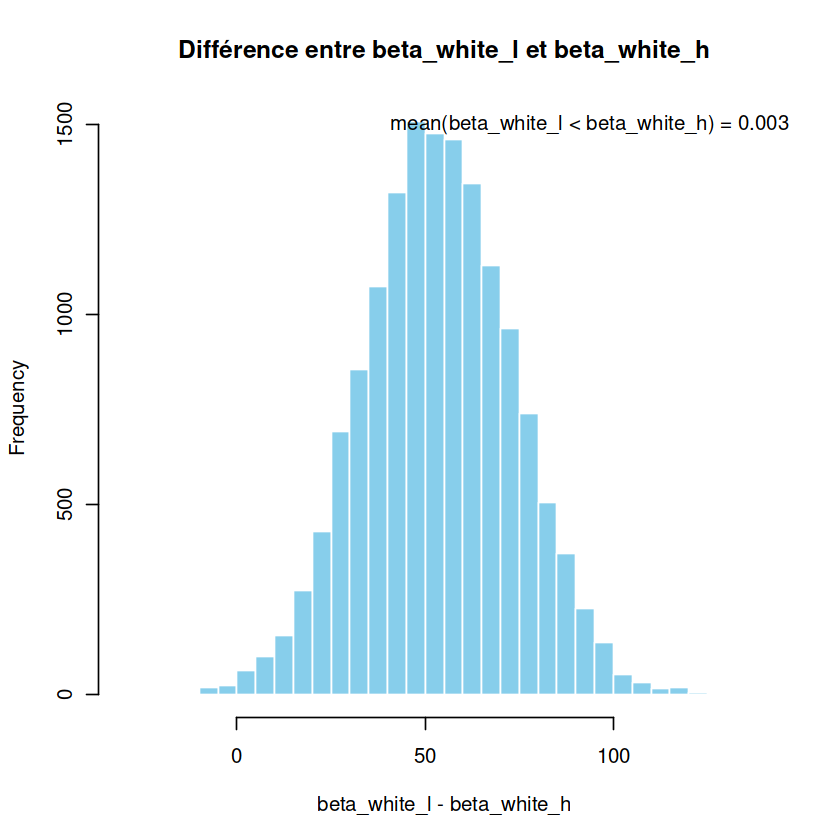

[1] 0.0002666667

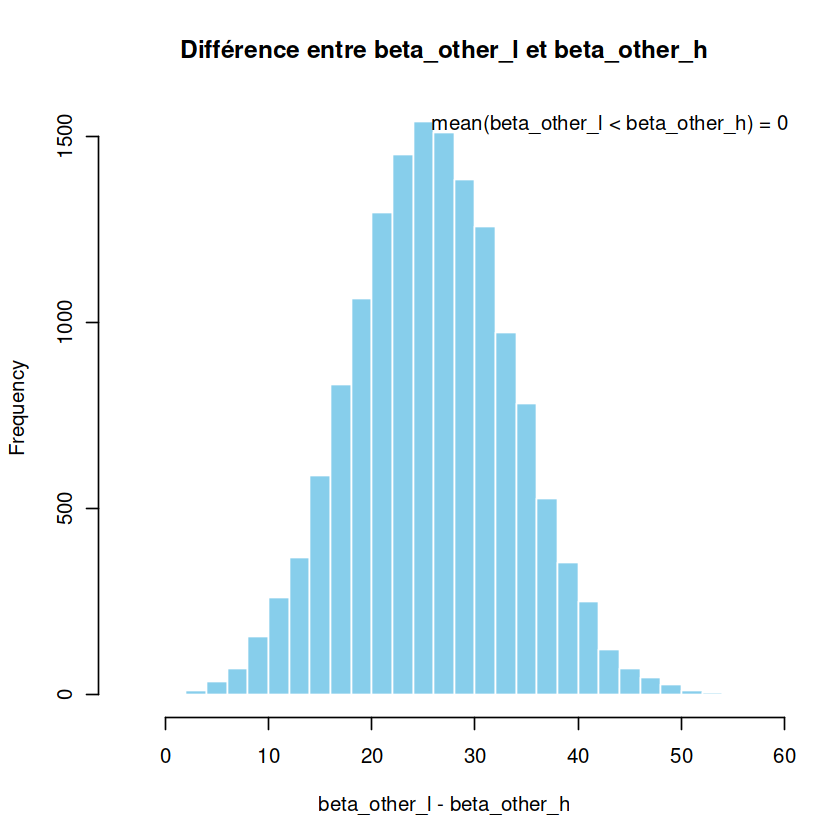

[1] 0.0002666667

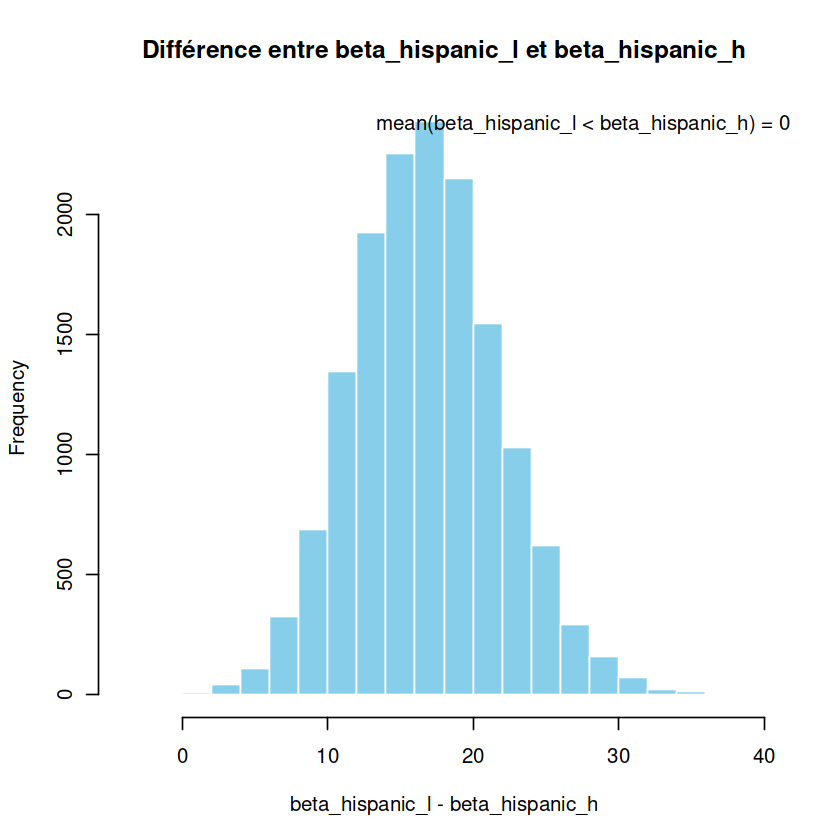

In [33]:
analyze_mcmc_difference(jags_samples_ethnicity,"beta_white_l","beta_white_h")
analyze_mcmc_difference(jags_samples_ethnicity,"beta_other_l","beta_other_h")
analyze_mcmc_difference(jags_samples_ethnicity,"beta_hispanic_l","beta_hispanic_h")

Les minorités ethniques sont significativement désavantagées en termes d'accès aux hauts salaires. Ce modèle met en évidence une forte inégalité salariale selon l’ethnicité, avec un effet particulièrement marqué pour les Hispaniques et autres minorités non blanches.

## MCMC

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


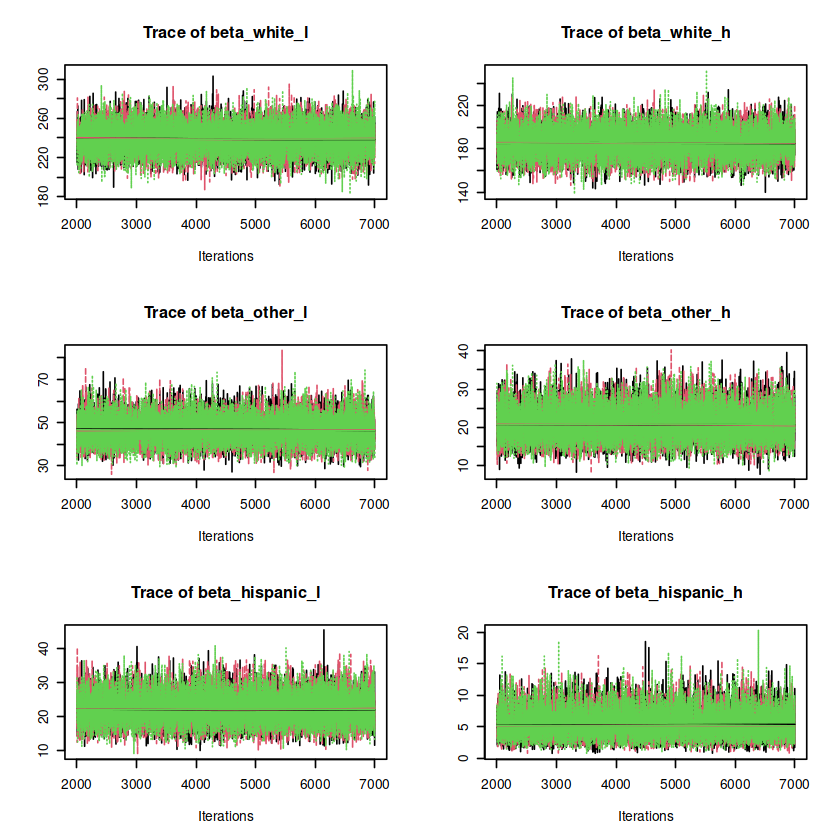

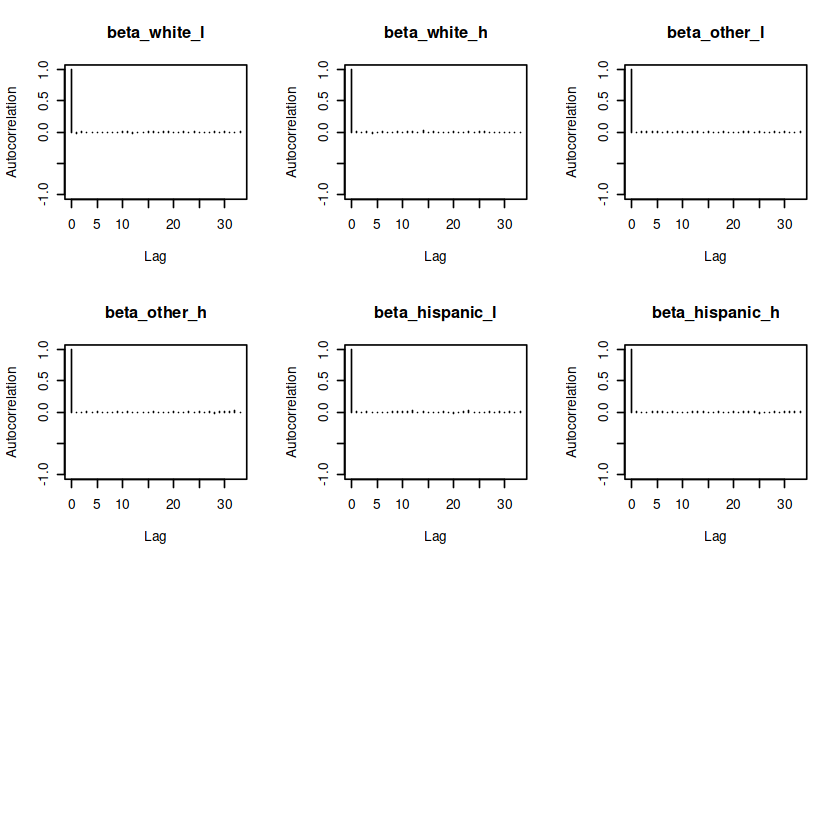

In [34]:
plot_mcmc(jags_samples_ethnicity)

## Fake data check

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 6 variables....
Finished running the simulation

JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                          
                Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD
beta_white_l     67.513 84.097  101.87 84.451 8.8149   -- 0.071974     0.8
beta_white_h     168.57  193.2  220.31 193.53  13.28   --  0.11076     0.8
beta_other_l     23.284 33.861   45.13 34.154 5.5879   -- 0.045625     0.8
beta_other_h     20.261 29.787  40.435 30.065 5.1759   -- 0.042261     0.8
beta_hispani

Lower95    Median    Upper95   Mean      SD        Mode
beta_white_l     67.513307  84.09664 101.86857  84.45147  8.814921 NA  
beta_white_h    168.573242 193.19695 220.30789 193.53067 13.280379 NA  
beta_other_l     23.284205  33.86088  45.13029  34.15405  5.587936 NA  
beta_other_h     20.261225  29.78699  40.43456  30.06467  5.175875 NA  
beta_hispanic_l  22.181158  32.04363  43.07115  32.33035  5.422779 NA  
beta_hispanic_h   4.966552  10.53947  17.05029  10.87574  3.173653 NA  
                MCerr      MC%ofSD SSeff AC.10        psrf     
beta_white_l    0.07197353 0.8     15000 -0.002926084 0.9999633
beta_white_h    0.11075510 0.8     14378  0.002078255 0.9999836
beta_other_l    0.04562531 0.8     15000  0.007848953 0.9999987
beta_other_h    0.04226084 0.8     15000 -0.008242909 0.9999616
beta_hispanic_l 0.04391075 0.8     15251 -0.001394103 0.9999565
beta_hispanic_h 0.02591277 0.8     15000 -0.003113175 1.0000770

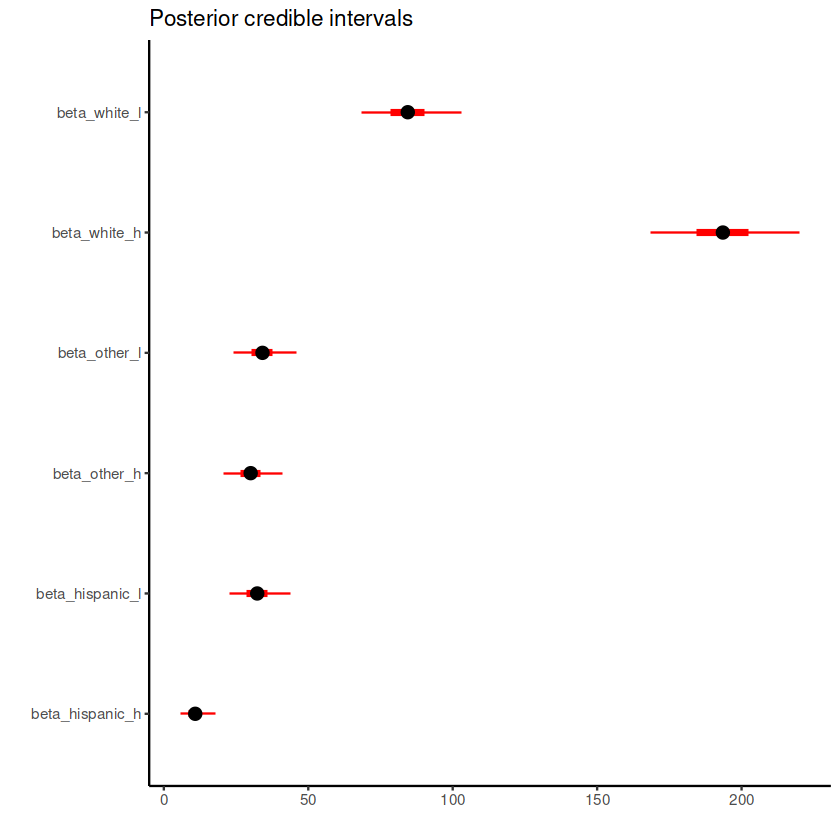

In [35]:
# ------------------------------
# 1. Generate fake Poisson wage counts by ethnicity and wage level
# ------------------------------
generate_fake_poisson_data <- function() {
  # Expected beta values (based on visual estimates)
  beta_white_l <- 90
  beta_white_h <- 180
  beta_other_l <- 45
  beta_other_h <- 30
  beta_hispanic_l <- 25
  beta_hispanic_h <- 10

  # Simulate counts from Poisson
  y_l_white    <- rpois(1, beta_white_l)
  y_h_white    <- rpois(1, beta_white_h)
  y_l_other    <- rpois(1, beta_other_l)
  y_h_other    <- rpois(1, beta_other_h)
  y_l_hispanic <- rpois(1, beta_hispanic_l)
  y_h_hispanic <- rpois(1, beta_hispanic_h)

  return(list(
    y_l_white = y_l_white,
    y_h_white = y_h_white,
    y_l_other = y_l_other,
    y_h_other = y_h_other,
    y_l_hispanic = y_l_hispanic,
    y_h_hispanic = y_h_hispanic
  ))
}

set.seed(123)
fake <- generate_fake_poisson_data()

data_list_fake <- list(
  y_l_white    = fake$y_l_white,
  y_h_white    = fake$y_h_white,
  y_l_other    = fake$y_l_other,
  y_h_other    = fake$y_h_other,
  y_l_hispanic = fake$y_l_hispanic,
  y_h_hispanic = fake$y_h_hispanic
)

model_string_ethnicity <- "
model {
  # Likelihood
  y_l_white    ~ dpois(beta_white_l)
  y_h_white    ~ dpois(beta_white_h)

  y_l_other    ~ dpois(beta_other_l)
  y_h_other    ~ dpois(beta_other_h)

  y_l_hispanic ~ dpois(beta_hispanic_l)
  y_h_hispanic ~ dpois(beta_hispanic_h)

  # Priors based on previous visual inspection
  beta_white_l    ~ dgamma(9, 0.1)
  beta_white_h    ~ dgamma(18, 0.1)
  
  beta_other_l    ~ dgamma(4.5, 0.1)
  beta_other_h    ~ dgamma(3, 0.1)

  beta_hispanic_l ~ dgamma(2.5, 0.1)
  beta_hispanic_h ~ dgamma(1, 0.1)
}
"

jags_samples_ethnicity_fake <- run.jags(
  model = model_string_ethnicity,
  data = data_list_fake,
  monitor = c(
    "beta_white_l", "beta_white_h",
    "beta_other_l", "beta_other_h",
    "beta_hispanic_l", "beta_hispanic_h"
  ),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000
)

print(jags_samples_ethnicity_fake)
plot_credible_intervals(jags_samples_ethnicity_fake)
summary(jags_samples_ethnicity_fake)

## Conclusion

Ce tableau compare la valeur moyenne estimée de \( \beta \), c’est-à-dire **le nombre moyen d’individus par groupe ethnique** selon le niveau de salaire.

| Groupe ethnique | Niveau salaire | \( \beta\) réel | \( \beta \) simulé | Écart absolu |
|----------------|---------------|----------------|----------------|--------------|
| White         | < Moyenne     | 239.14         | 84.52          |   154.62     |
| White         | ≥ Moyenne     | 185.35         | 193.52         |   8.17       |
| Other         | < Moyenne     | 46.80          | 34.08          |   12.72      |
| Other         | ≥ Moyenne     | 20.95          | 30.00          |   9.05       |
| Hispanic      | < Moyenne     | 22.33          | 32.19          |   9.86       |
| Hispanic      | ≥ Moyenne     | 5.44           | 10.87          |   5.43       |

---

### Interprétation

- **beta_white_h** (White, salaire élevé) est **bien capturé** par les données simulées : la moyenne simulée (193.52) est proche de la valeur réelle (185.35).

- **beta_white_l** (White, salaire faible) est **largement sous-estimé** dans les données factices (~84 vs 239 réels). Cela montre que les données simulées **ne reflètent pas bien la distribution réelle** des salaires faibles chez les individus blancs.

- **beta_hispanic_h** et **beta_other_h** sont


# Variable sector

<img src="image-20250330-170309.png" width="" align="" />

## Vraisemblance

$$
X_{k, s} | \beta_{k, s} \sim \text{Poisson}(\beta_{k, s})
$$

avec $ s \in \{ \ell, h \} $

## Choix du prior

$$
\begin{aligned}
\beta_{\text{Construction}, \ell} &\sim \text{Gamma}(1, 0.1) & \quad \beta_{\text{Construction}, h} &\sim \text{Gamma}(1, 0.1) \\
\beta_{\text{Manufacturing}, \ell} &\sim \text{Gamma}(3, 0.1) & \quad \beta_{\text{Manufacturing}, h} &\sim \text{Gamma}(3, 0.1) \\
\beta_{\text{Other}, \ell} &\sim \text{Gamma}(13, 0.1) & \quad \beta_{\text{Other}, h} &\sim \text{Gamma}(15, 0.1)
\end{aligned}
$$

## Implémentation en JAGS

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 6 variables....
Finished running the simulation

JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                               
                     Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD
beta_l_Construction   5.2116 10.649  17.143 10.942 3.1232   -- 0.025112     0.8
beta_h_Construction   6.5842 12.405  19.695  12.72  3.404   -- 0.027794     0.8
beta_l_Manufacturing  35.887 47.948  61.467 48.231 6.5597   --  0.05356     0.8
beta_h_Manufacturing  34.314 46.937  59.676 47.249 6.4952   --

Lower95    Median    Upper95   Mean      SD        Mode
beta_l_Construction    5.211634  10.64893  17.14269  10.94213  3.123242 NA  
beta_h_Construction    6.584229  12.40516  19.69456  12.72046  3.404033 NA  
beta_l_Manufacturing  35.886633  47.94808  61.46657  48.23134  6.559736 NA  
beta_h_Manufacturing  34.313707  46.93737  59.67583  47.24859  6.495249 NA  
beta_l_Other         221.912188 249.89115 280.54630 250.12463 15.035809 NA  
beta_h_Other         126.953003 148.95276 171.94333 149.30970 11.685796 NA  
                     MCerr      MC%ofSD SSeff AC.10        psrf    
beta_l_Construction  0.02511201 0.8     15469 -0.014547281 1.000087
beta_h_Construction  0.02779381 0.8     15000 -0.015559539 1.000062
beta_l_Manufacturing 0.05356002 0.8     15000 -0.008567141 1.000154
beta_h_Manufacturing 0.05347818 0.8     14752 -0.010906689 1.000130
beta_l_Other         0.12276687 0.8     15000  0.009336107 1.000043
beta_h_Other         0.09461939 0.8     15253 -0.009026613 1.000105

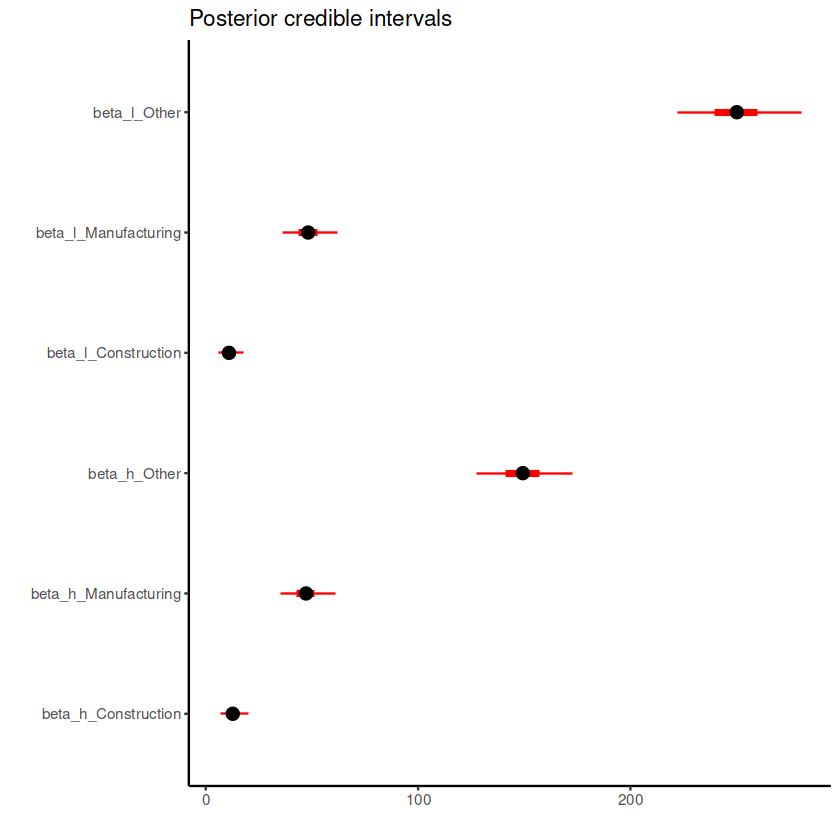

In [36]:
# Compter les individus par secteur et niveau de salaire
counts_l <- table(wage_data$sector[wage_data$wage_level == 0])
counts_h <- table(wage_data$sector[wage_data$wage_level == 1])

# Préparer les données pour JAGS
data_list_sector <- list(
  y_l_Construction   = as.numeric(counts_l["Construction"]),
  y_h_Construction   = as.numeric(counts_h["Construction"]),
  y_l_Manufacturing  = as.numeric(counts_l["Manufacturing"]),
  y_h_Manufacturing  = as.numeric(counts_h["Manufacturing"]),
  y_l_Other          = as.numeric(counts_l["Other"]),
  y_h_Other          = as.numeric(counts_h["Other"])
)
model_string_sector <- "
model {
  # Likelihood
  y_l_Construction   ~ dpois(beta_l_Construction)
  y_h_Construction   ~ dpois(beta_h_Construction)

  y_l_Manufacturing  ~ dpois(beta_l_Manufacturing)
  y_h_Manufacturing  ~ dpois(beta_h_Manufacturing)

  y_l_Other          ~ dpois(beta_l_Other)
  y_h_Other          ~ dpois(beta_h_Other)

  # Priors (adjusted from histogram)
  beta_l_Construction   ~ dgamma(1, 0.1)
  beta_h_Construction   ~ dgamma(1, 0.1)

  beta_l_Manufacturing  ~ dgamma(3, 0.1)
  beta_h_Manufacturing  ~ dgamma(3, 0.1)

  beta_l_Other          ~ dgamma(13, 0.1)
  beta_h_Other          ~ dgamma(15, 0.1)
}
"
library(runjags)

jags_samples_sector <- run.jags(
  model = model_string_sector,
  data = data_list_sector,
  monitor = c(
    "beta_l_Construction", "beta_h_Construction",
    "beta_l_Manufacturing", "beta_h_Manufacturing",
    "beta_l_Other", "beta_h_Other"
  ),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000
)
print(jags_samples_sector)
plot_credible_intervals(jags_samples_sector)
summary(jags_samples_sector)


[1] 0.6542667

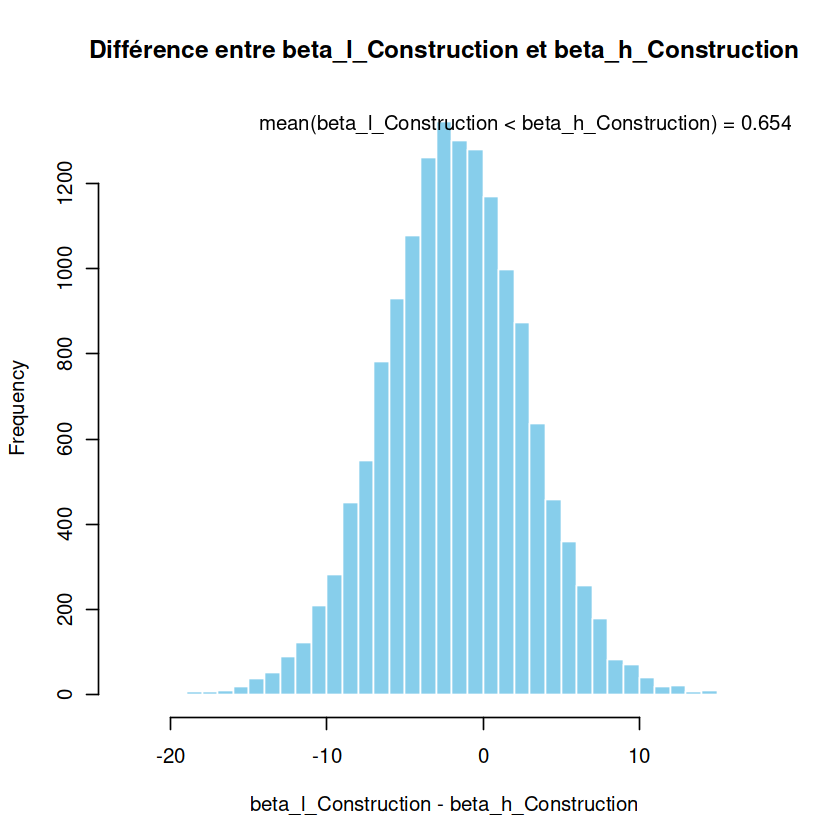

[1] 0.4556667

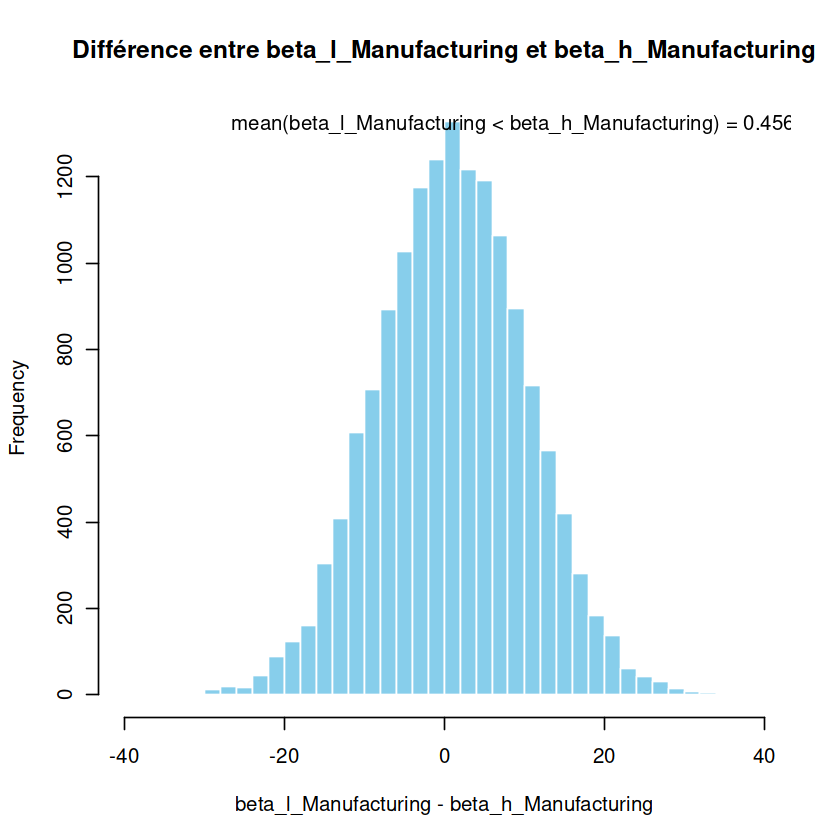

[1] 0

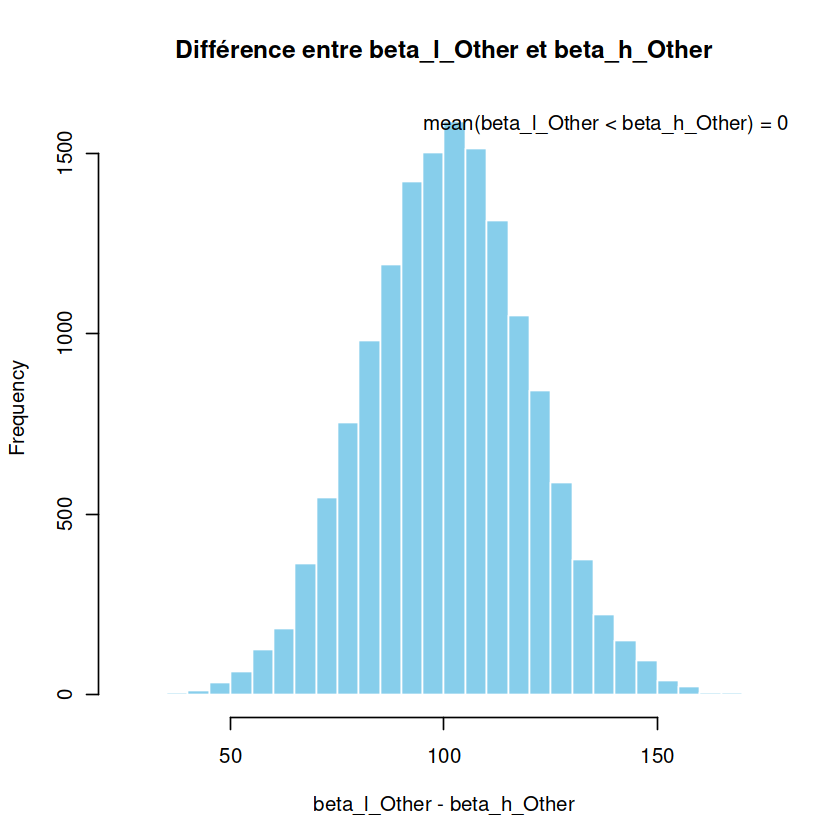

In [37]:
analyze_mcmc_difference(jags_samples_sector,'beta_l_Construction','beta_h_Construction')

analyze_mcmc_difference(jags_samples_sector,'beta_l_Manufacturing','beta_h_Manufacturing')

analyze_mcmc_difference(jags_samples_sector,'beta_l_Other','beta_h_Other')

Le secteur de la construction offre une meilleure répartition des salaires, avec une proportion notable de hauts salaires.

Le secteur manufacturier semble relativement équilibré.

Les autres secteurs (services, agriculture, etc.) présentent une forte concentration de bas salaires, ce qui suggère une précarité plus importante.

## MCMC

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


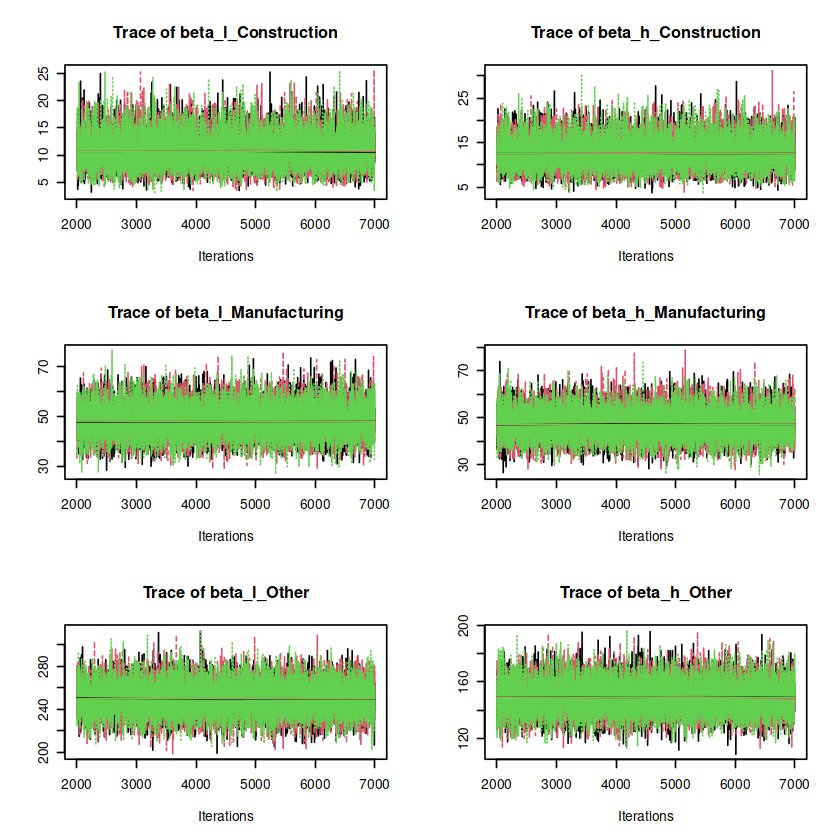

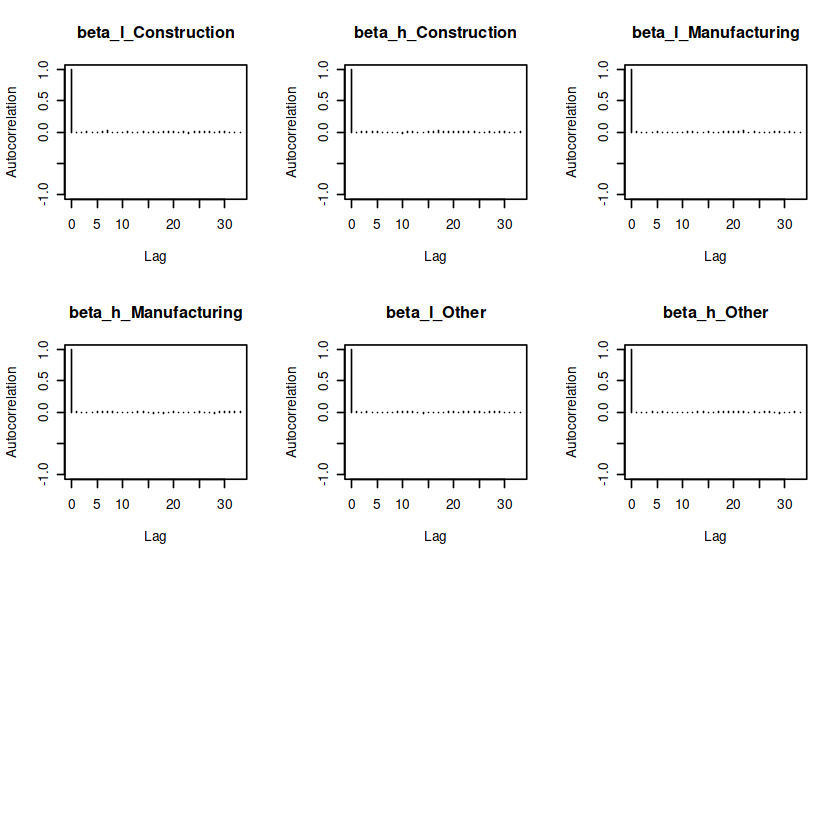

In [38]:
plot_mcmc(jags_samples_sector)

## Fake data check

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 6 variables....
Finished running the simulation

JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                               
                     Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD
beta_l_Construction   3.2308 7.8754  13.662 8.1819 2.7414   -- 0.022726     0.8
beta_h_Construction   4.0396 8.7542  14.972 9.0705 2.8658   -- 0.023219     0.8
beta_l_Manufacturing   26.44 37.043  48.848 37.329 5.8193   -- 0.047515     0.8
beta_h_Manufacturing  19.784 29.723  39.983 30.005 5.2395   --

Lower95    Median     Upper95   Mean       SD        Mode
beta_l_Construction    3.230801   7.875372  13.66160   8.181871  2.741396 NA  
beta_h_Construction    4.039605   8.754172  14.97164   9.070453  2.865762 NA  
beta_l_Manufacturing  26.440308  37.043382  48.84829  37.328832  5.819346 NA  
beta_h_Manufacturing  19.784434  29.723431  39.98301  30.005014  5.239531 NA  
beta_l_Other         109.700256 130.647413 152.28933 130.888968 10.951707 NA  
beta_h_Other         144.889388 168.672570 193.26306 169.058816 12.415469 NA  
                     MCerr      MC%ofSD SSeff AC.10        psrf    
beta_l_Construction  0.02272553 0.8     14552  0.004336786 1.000157
beta_h_Construction  0.02321926 0.8     15233 -0.002922789 1.000123
beta_l_Manufacturing 0.04751476 0.8     15000  0.001624024 1.000147
beta_h_Manufacturing 0.04278059 0.8     15000  0.003023794 1.000034
beta_l_Other         0.08942031 0.8     15000  0.008046264 1.000237
beta_h_Other         0.10137188 0.8     15000  0.003219979 1.000094

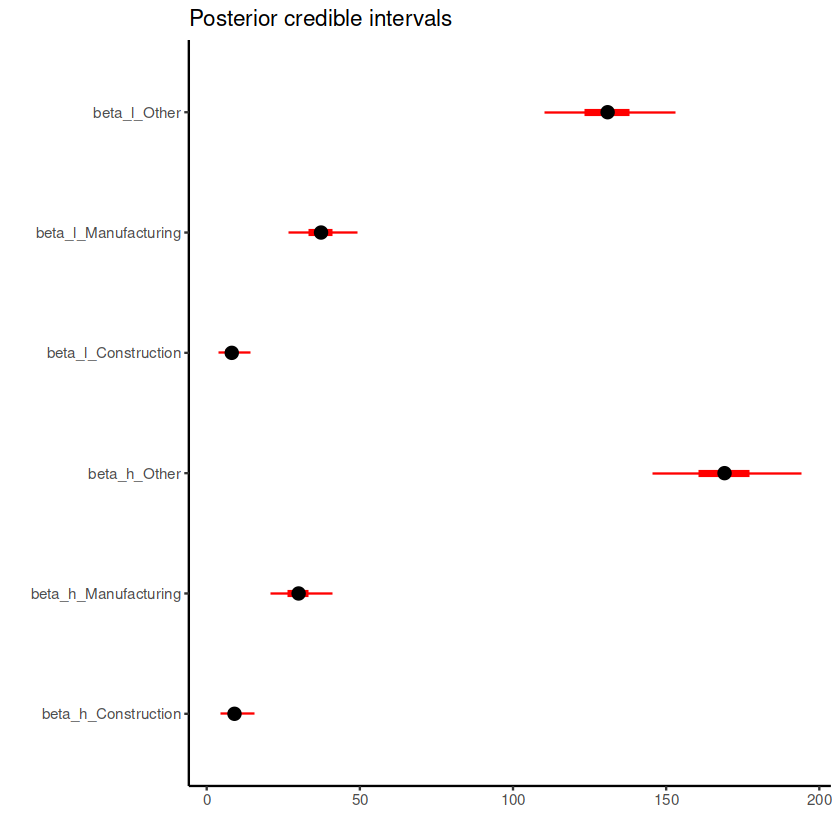

In [39]:
generate_fake_sector_data <- function() {
  list(
    y_l_Construction   = rpois(1, 10),
    y_h_Construction   = rpois(1, 10),
    y_l_Manufacturing  = rpois(1, 30),
    y_h_Manufacturing  = rpois(1, 30),
    y_l_Other          = rpois(1, 130),
    y_h_Other          = rpois(1, 150)
  )
}


set.seed(123)
fake_sector <- generate_fake_sector_data()

data_list_sector_fake <- fake_sector
jags_samples_sector_fake <- run.jags(
  model = model_string_sector,
  data = data_list_sector_fake,
  monitor = c(
    "beta_l_Construction", "beta_h_Construction",
    "beta_l_Manufacturing", "beta_h_Manufacturing",
    "beta_l_Other", "beta_h_Other"
  ),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000
)
print(jags_samples_sector_fake)
plot_credible_intervals(jags_samples_sector_fake)
summary(jags_samples_sector_fake)


## Conclusion

Ce tableau compare les valeurs moyennes estimées de \( \lambda \) obtenues avec les données réelles et les données simulées.

| Secteur        | Salaire       | \( \lambda \) réel | \( \lambda \) simulé | Écart absolu |
|---------------|--------------|--------------------|----------------------|--------------|
| Construction   | < Moyenne     | 10.91              | 8.20                 | 2.71         |
| Construction   | ≥ Moyenne     | 12.76              | 9.08                 | 3.68         |
| Manufacturing  | < Moyenne     | 48.18              | 37.17                | 11.01        |
| Manufacturing  | ≥ Moyenne     | 47.27              | 29.98                | 17.29        |
| Other         | < Moyenne     | 250.01             | 131.07               |   118.94     |
| Other         | ≥ Moyenne     | 148.97             | 169.02               |   20.05      |

---

### Analyse

- Les valeurs simulées sont **cohérentes** pour le secteur **Construction**, bien qu'un léger écart subsiste.
- Pour **Manufacturing**, les données simulées **sous-estiment** de manière notable les comptes réels, surtout pour les hauts salaires.
- Dans le cas du secteur **Other**, les \( \lambda \) simulés **sous-estiment fortement** les bas salaires (131 vs 250), mais surestiment légèrement les hauts salaires.
- Toutefois, le modèle reproduit **globalement bien les tendances** observées.

---

### Conclusion

Les **priors utilisés sont raisonnables**, mais pour améliorer la précision :
- On peut **ajuster les hyperparamètres Gamma** pour mieux capturer les distributions réelles, notamment dans le secteur "Other".
- Une **meilleure prise en compte de l'hétérogénéité** des secteurs améliorerait encore la modélisation.


# Variable occupation

<img src="image-20250330-170318.png" width="" align="" />

## Vraisemblance

$$
X_{k, \ell} | \beta_{k, s} \sim \text{Poisson}(\beta_{k, s})
$$

Avec $ s \in \{ \ell, h \}$

## Choix du prior

$$
\begin{aligned}
\beta_{\text{Clerical}, \ell} &\sim \text{Gamma}(4, 0.1) & \quad \beta_{\text{Clerical}, h} &\sim \text{Gamma}(3, 0.1) \\
\beta_{\text{Management}, \ell} &\sim \text{Gamma}(2, 0.1) & \quad \beta_{\text{Management}, h} &\sim \text{Gamma}(3, 0.1) \\
\beta_{\text{Other}, \ell} &\sim \text{Gamma}(4, 0.1) & \quad \beta_{\text{Other}, h} &\sim \text{Gamma}(6, 0.1) \\
\beta_{\text{Professional}, \ell} &\sim \text{Gamma}(3.5, 0.1) & \quad \beta_{\text{Professional}, h} &\sim \text{Gamma}(3.5, 0.1) \\
\beta_{\text{Sales}, \ell} &\sim \text{Gamma}(1.5, 0.1) & \quad \beta_{\text{Sales}, h} &\sim \text{Gamma}(1, 0.1) \\
\beta_{\text{Service}, \ell} &\sim \text{Gamma}(3.5, 0.1) & \quad \beta_{\text{Service}, h} &\sim \text{Gamma}(1.5, 0.1)
\end{aligned}
$$

## Implémentation en JAGS

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 12 variables....
Finished running the simulation

JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                         
                       Lower95 Median Upper95   Mean     SD Mode    MCerr
beta_l_Clerical         7.3741 36.782  81.041 40.157 20.273   --  0.16027
beta_h_Clerical         2.9942 26.746  64.943 30.233 17.628   --   0.1423
beta_l_Management      0.38083 16.719  47.286 20.006 14.112   --  0.11523
beta_h_Management       3.9008 26.475  63.632 29.779  17.03   --  0.13778
beta_l_Other     

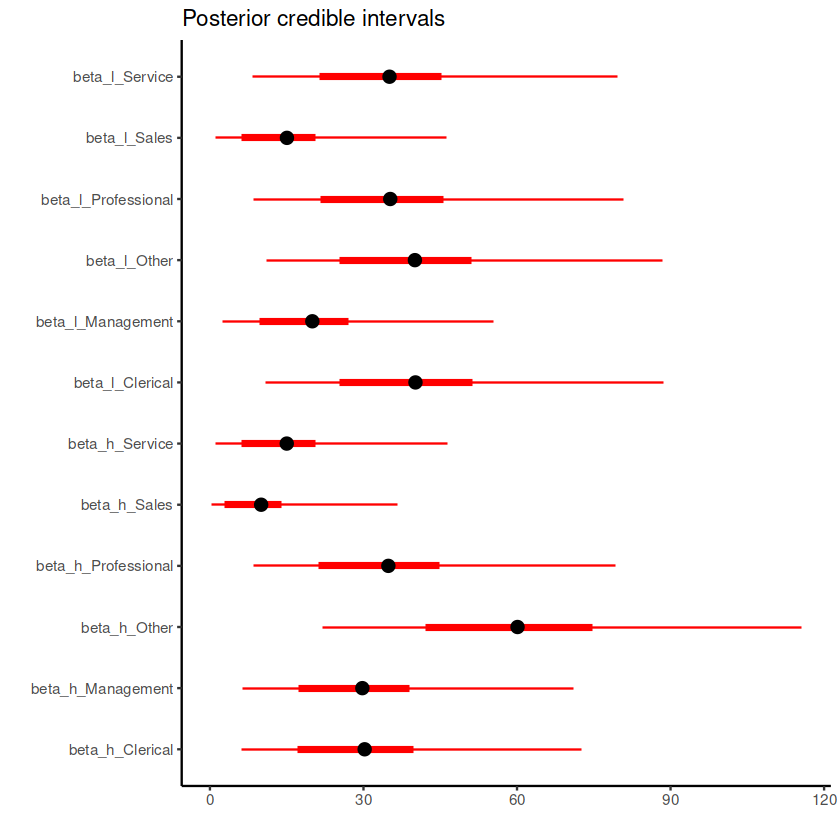

In [40]:
# Liste des groupes occupation
occupation_groups <- unique(wage_data$occupation)

# Comptes par groupe et niveau de salaire
counts_l <- sapply(occupation_groups, function(g) sum(wage_data$wage_level == 0 & wage_data$occupation == g))
counts_h <- sapply(occupation_groups, function(g) sum(wage_data$wage_level == 1 & wage_data$occupation == g))

# Créer la liste des données nommées
data_list_occupation <- list(
  y_l_Clerical     = counts_l["Clerical"],
  y_h_Clerical     = counts_h["Clerical"],
  y_l_Management   = counts_l["Management"],
  y_h_Management   = counts_h["Management"],
  y_l_Other        = counts_l["Other"],
  y_h_Other        = counts_h["Other"],
  y_l_Professional = counts_l["Professional"],
  y_h_Professional = counts_h["Professional"],
  y_l_Sales        = counts_l["Sales"],
  y_h_Sales        = counts_h["Sales"],
  y_l_Service      = counts_l["Service"],
  y_h_Service      = counts_h["Service"]
)

model_string_occupation <- "
model {
  # Likelihoods
  y_l_Clerical     ~ dpois(beta_l_Clerical)
  y_h_Clerical     ~ dpois(beta_h_Clerical)

  y_l_Management   ~ dpois(beta_l_Management)
  y_h_Management   ~ dpois(beta_h_Management)

  y_l_Other        ~ dpois(beta_l_Other)
  y_h_Other        ~ dpois(beta_h_Other)

  y_l_Professional ~ dpois(beta_l_Professional)
  y_h_Professional ~ dpois(beta_h_Professional)

  y_l_Sales        ~ dpois(beta_l_Sales)
  y_h_Sales        ~ dpois(beta_h_Sales)

  y_l_Service      ~ dpois(beta_l_Service)
  y_h_Service      ~ dpois(beta_h_Service)

  # Priors (vagues, à adapter si tu veux en fonction des counts observés)
  beta_l_Clerical     ~ dgamma(4, 0.1)
  beta_h_Clerical     ~ dgamma(3, 0.1)

  beta_l_Management   ~ dgamma(2, 0.1)
  beta_h_Management   ~ dgamma(3, 0.1)

  beta_l_Other        ~ dgamma(4, 0.1)
  beta_h_Other        ~ dgamma(6, 0.1)

  beta_l_Professional ~ dgamma(3.5, 0.1)
  beta_h_Professional ~ dgamma(3.5, 0.1)

  beta_l_Sales        ~ dgamma(1.5, 0.1)
  beta_h_Sales        ~ dgamma(1, 0.1)

  beta_l_Service      ~ dgamma(3.5, 0.1)
  beta_h_Service      ~ dgamma(1.5, 0.1)

}
"
library(runjags)

jags_samples_occupation <- run.jags(
  model = model_string_occupation,
  data = data_list_occupation,
  monitor = c(
    "beta_l_Clerical", "beta_h_Clerical",
    "beta_l_Management", "beta_h_Management",
    "beta_l_Other", "beta_h_Other",
    "beta_l_Professional", "beta_h_Professional",
    "beta_l_Sales", "beta_h_Sales",
    "beta_l_Service", "beta_h_Service"
  ),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000
)
print(jags_samples_occupation)
plot_credible_intervals(jags_samples_occupation)



[1] 0.1605333

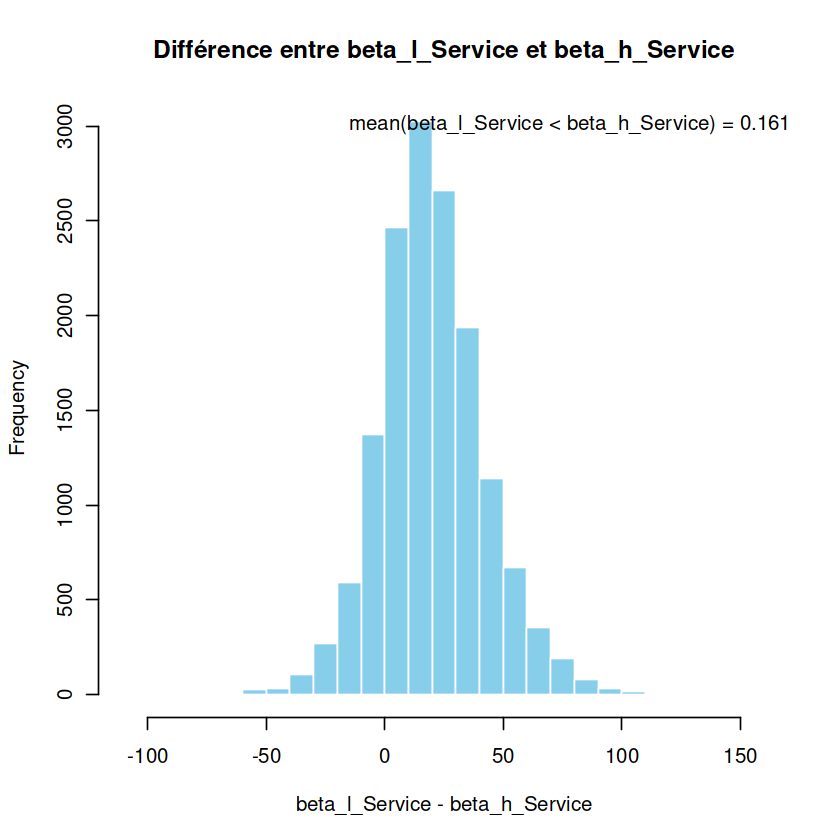

[1] 0.3519333

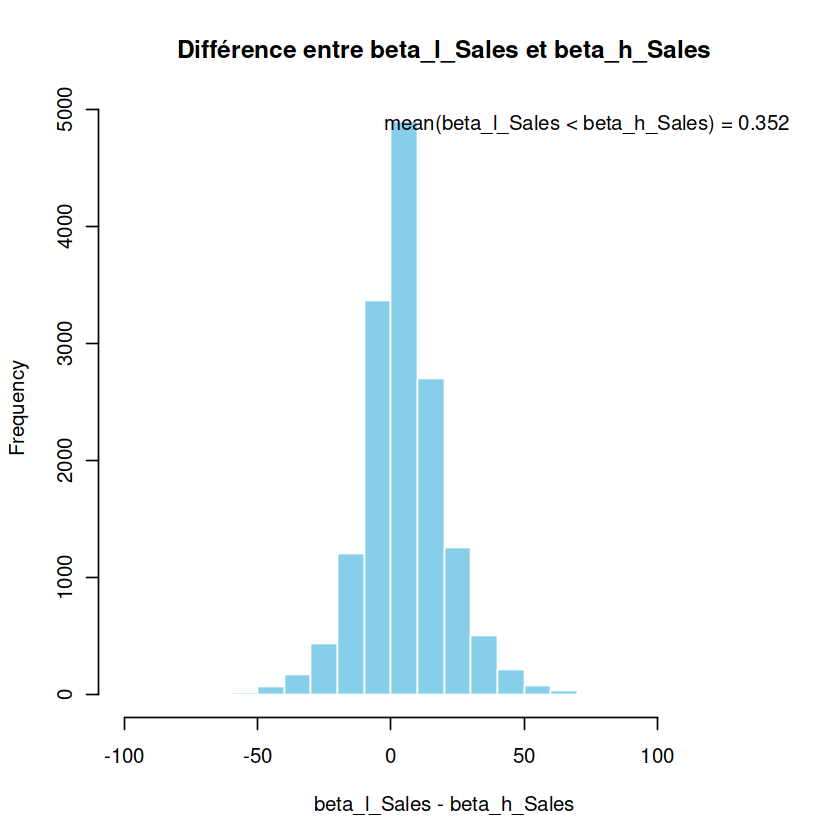

[1] 0.4932

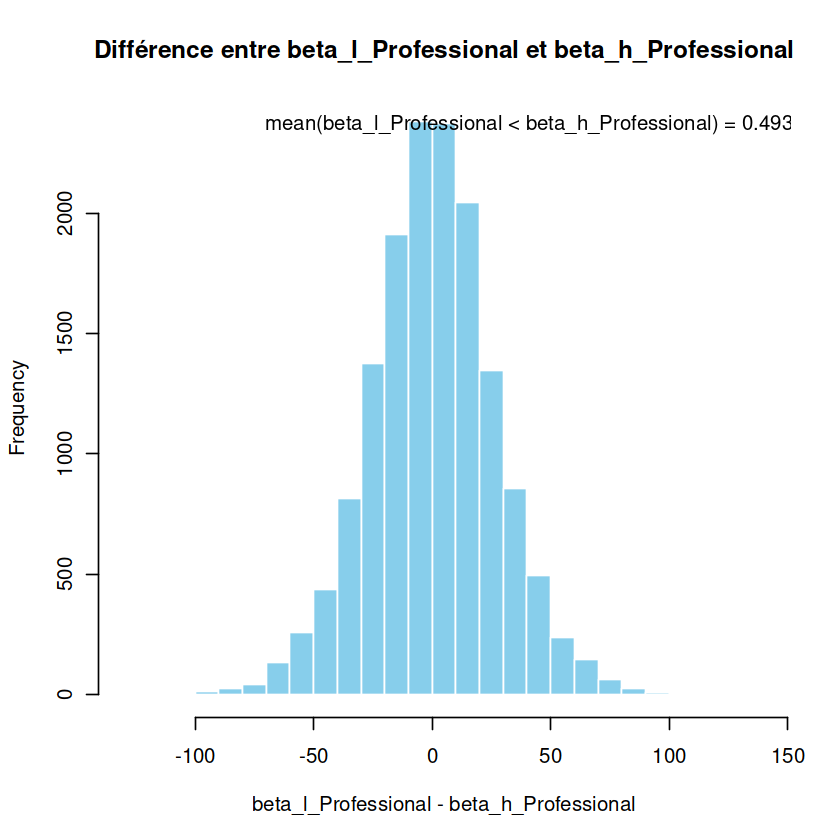

[1] 0.744

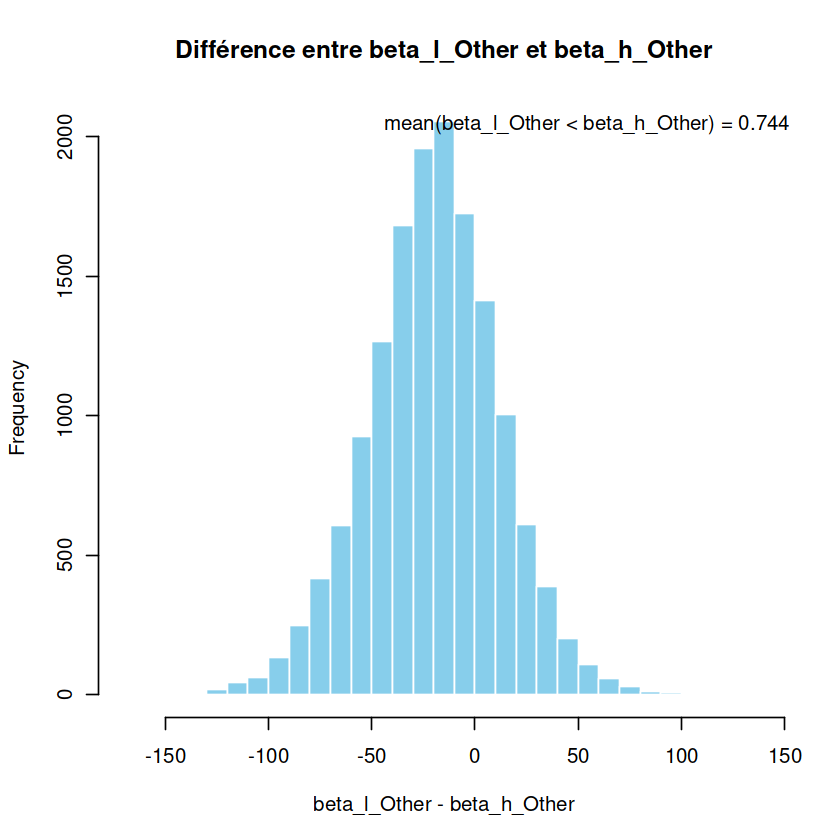

[1] 0.6826667

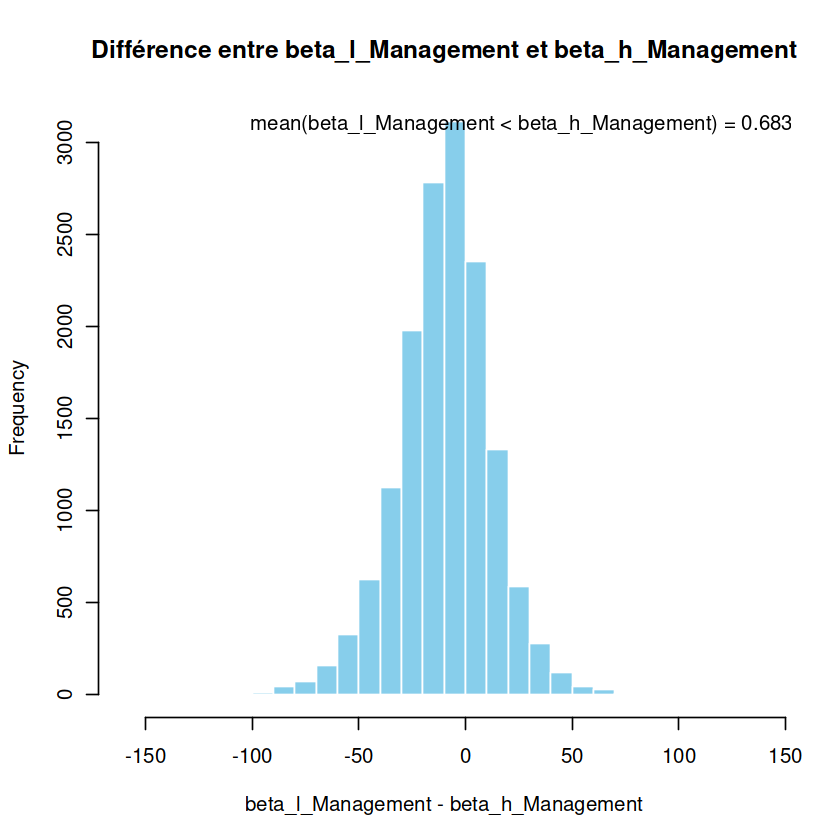

[1] 0.3494

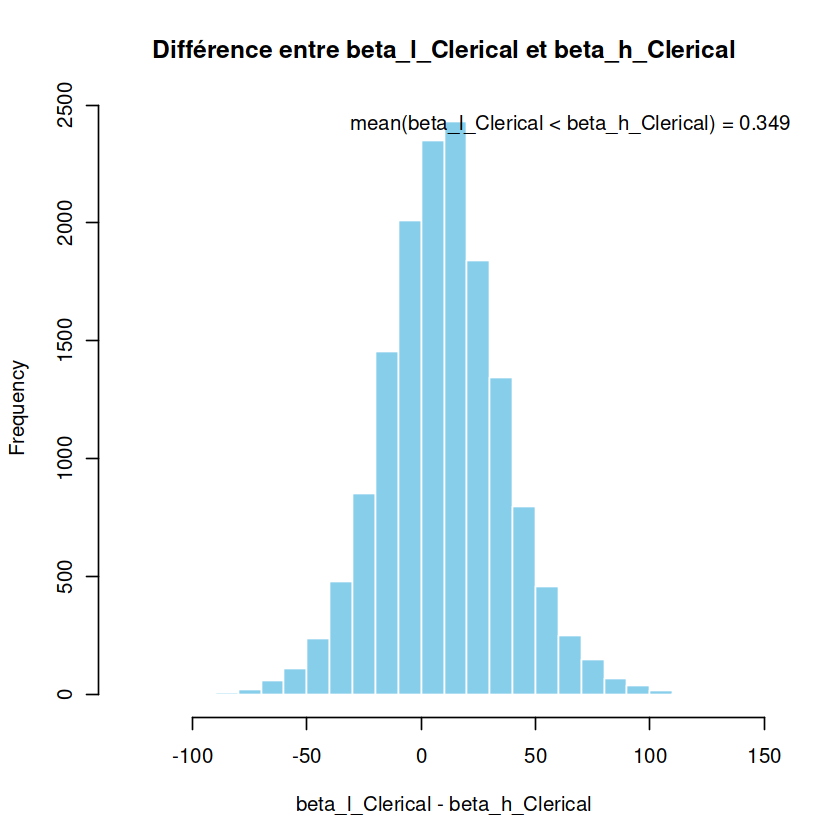

In [41]:
analyze_mcmc_difference(jags_samples_occupation, "beta_l_Service", "beta_h_Service")
analyze_mcmc_difference(jags_samples_occupation, "beta_l_Sales", "beta_h_Sales")
analyze_mcmc_difference(jags_samples_occupation, "beta_l_Professional", "beta_h_Professional")
analyze_mcmc_difference(jags_samples_occupation, "beta_l_Other", "beta_h_Other")
analyze_mcmc_difference(jags_samples_occupation, "beta_l_Management", "beta_h_Management")
analyze_mcmc_difference(jags_samples_occupation, "beta_l_Clerical", "beta_h_Clerical")


Les écarts sont plus prononcés dans les professions Management et Other, où les hauts salaires sont significativement plus élevés que les bas salaires. En revanche, Professional et Clerical montrent moins de différence. L'occupation semble donc jouer un rôle différencié selon le secteur en matière d’inégalité salariale.

## MCMC

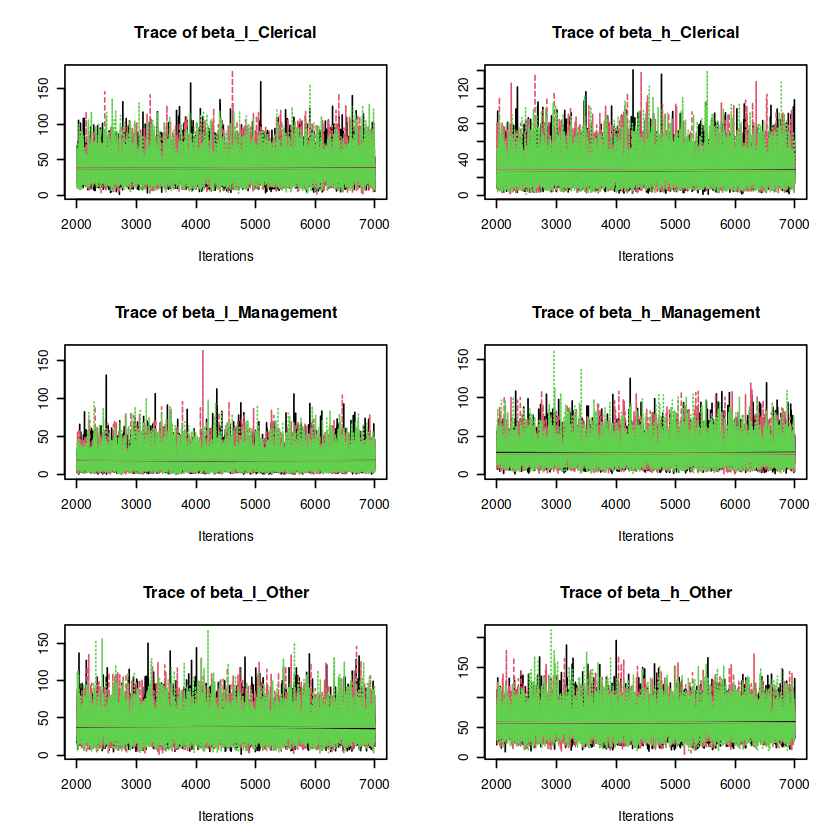

Warning message in as.mcmc.runjags(x):
“Combining the 3 mcmc chains together”


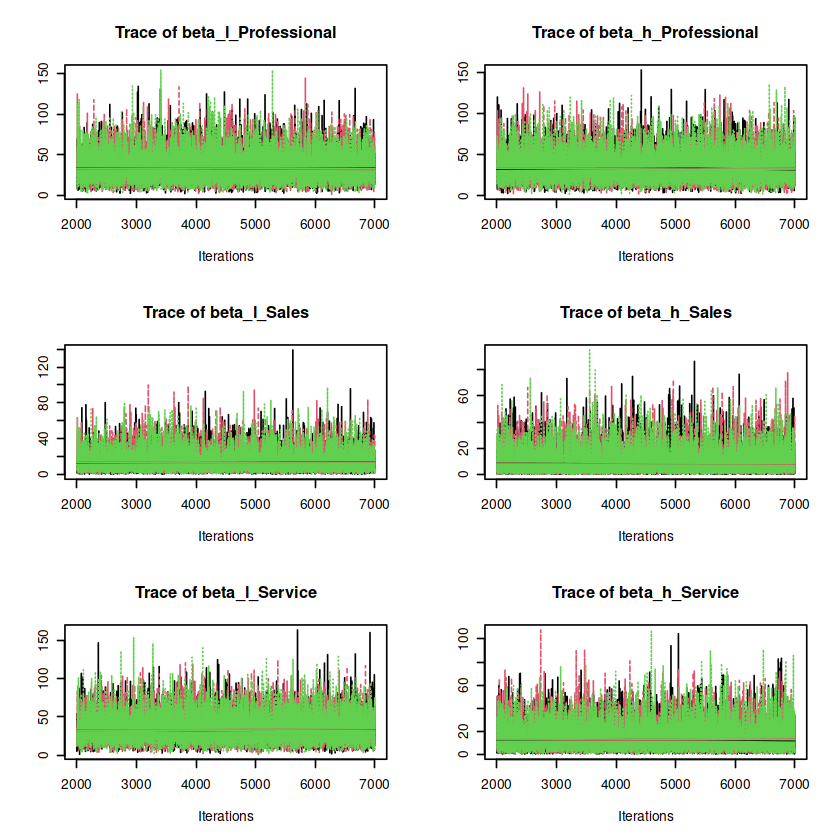

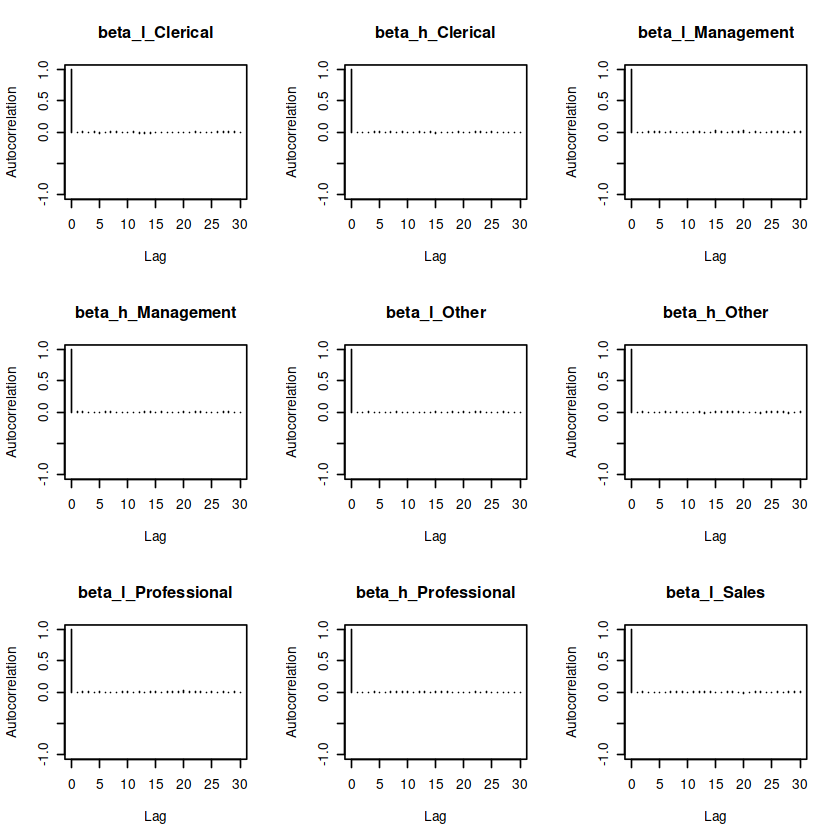

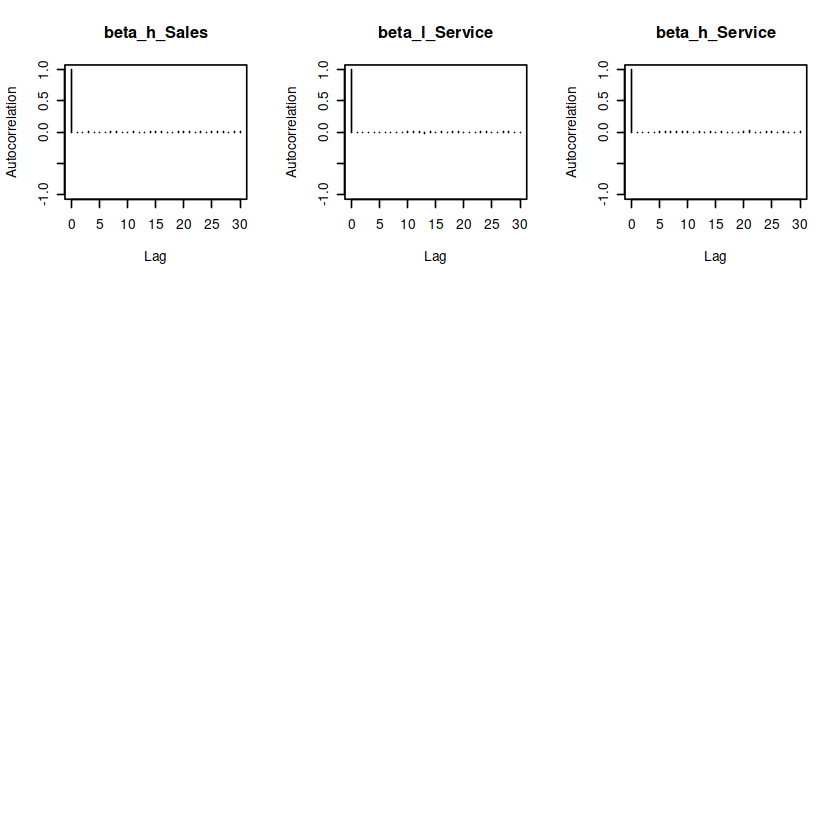

In [42]:
plot_mcmc(jags_samples_occupation)

## Fake data check

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 1000 iterations...
Running the model for 5000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 12 variables....
Finished running the simulation

JAGS model summary statistics from 15000 samples (chains = 3; adapt+burnin = 2000):
                                                                              
                    Lower95 Median Upper95   Mean     SD Mode    MCerr MC%ofSD
beta_l_Clerical      25.737 36.007  48.042 36.335 5.7483   -- 0.046935     0.8
beta_h_Clerical      24.573 35.091  46.498 35.415 5.6165   -- 0.045175     0.8
beta_l_Management    6.3858 12.478  19.371 12.769 3.4032   -- 0.027787     0.8
beta_h_Management    20.175 29.746  40.465 30.057 5.2225   -- 0.04

Lower95   Median   Upper95  Mean     SD       Mode
beta_l_Clerical     25.736701 36.00684 48.04155 36.33543 5.748303 NA  
beta_h_Clerical     24.572653 35.09059 46.49845 35.41540 5.616518 NA  
beta_l_Management    6.385814 12.47847 19.37101 12.76913 3.403163 NA  
beta_h_Management   20.175201 29.74619 40.46489 30.05694 5.222519 NA  
beta_l_Other        36.135116 48.67031 62.24073 49.07403 6.701605 NA  
beta_h_Other        48.598781 62.35007 77.77141 62.72245 7.559897 NA  
beta_l_Professional 18.036463 27.47727 37.46989 27.73917 5.031061 NA  
beta_h_Professional 15.810859 24.66140 34.34597 25.03437 4.796855 NA  
beta_l_Sales        10.969042 18.34214 26.96172 18.61887 4.131515 NA  
beta_h_Sales         5.090097 10.60864 17.18018 10.92288 3.175802 NA  
beta_l_Service      25.575586 36.53821 47.93774 36.85264 5.786741 NA  
beta_h_Service       8.035547 14.77539 22.23710 15.02804 3.718740 NA  
                    MCerr      MC%ofSD SSeff AC.10        psrf     
beta_l_Clerical     0.04693470 0.8     15000  0.003459225 1.0001641
beta_h_Clerical     0.04517503 0.8     15457 -0.009622138 1.0001472
beta_l_Management   0.02778671 0.8     15000 -0.018027191 0.9999779
beta_h_Management   0.04139349 0.8     15918 -0.001856285 0.9999471
beta_l_Other        0.05496710 0.8     14865  0.006309578 0.9999437
beta_h_Other        0.06223060 0.8     14758 -0.005556792 1.0001487
beta_l_Professional 0.04107844 0.8     15000 -0.002842297 1.0000637
beta_h_Professional 0.04021328 0.8     14229  0.006191599 0.9999812
beta_l_Sales        0.03373368 0.8     15000 -0.003934507 1.0002937
beta_h_Sales        0.02632283 0.8     14556  0.003449612 1.0000929
beta_l_Service      0.04680817 0.8     15284 -0.002385422 1.0002462
beta_h_Service      0.03036339 0.8     15000  0.007253724 1.0000140

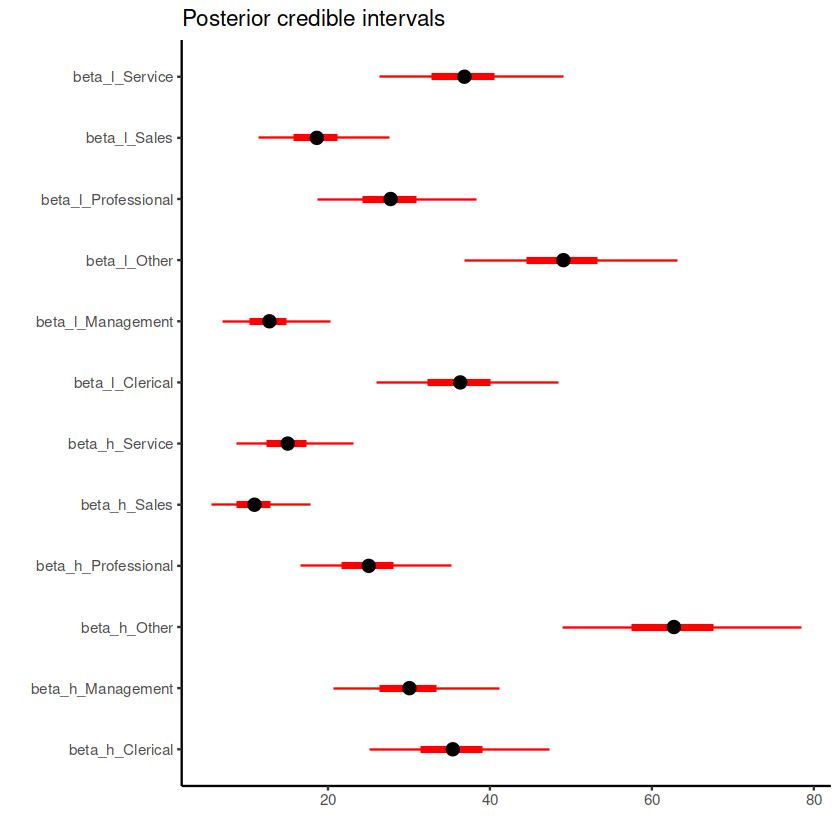

In [43]:
# ------------------------------
# 1. Generate fake Poisson wage counts by occupation and wage level
# ------------------------------
generate_fake_poisson_occupation <- function() {
  # Expected beta values based on the occupation graph
  beta_clerical_l     <- 40
  beta_clerical_h     <- 30
  beta_management_l   <- 20
  beta_management_h   <- 30
  beta_other_l        <- 40
  beta_other_h        <- 60
  beta_professional_l <- 35
  beta_professional_h <- 35
  beta_sales_l        <- 15
  beta_sales_h        <- 10
  beta_service_l      <- 35
  beta_service_h      <- 15

  # Simulate Poisson counts
  list(
    y_l_Clerical     = rpois(1, beta_clerical_l),
    y_h_Clerical     = rpois(1, beta_clerical_h),
    y_l_Management   = rpois(1, beta_management_l),
    y_h_Management   = rpois(1, beta_management_h),
    y_l_Other        = rpois(1, beta_other_l),
    y_h_Other        = rpois(1, beta_other_h),
    y_l_Professional = rpois(1, beta_professional_l),
    y_h_Professional = rpois(1, beta_professional_h),
    y_l_Sales        = rpois(1, beta_sales_l),
    y_h_Sales        = rpois(1, beta_sales_h),
    y_l_Service      = rpois(1, beta_service_l),
    y_h_Service      = rpois(1, beta_service_h)
  )
}

set.seed(123)
fake_occ <- generate_fake_poisson_occupation()

data_list_fake_occupation <- fake_occ
model_string_occupation <- "
model {
  # Likelihoods
  y_l_Clerical     ~ dpois(beta_l_Clerical)
  y_h_Clerical     ~ dpois(beta_h_Clerical)

  y_l_Management   ~ dpois(beta_l_Management)
  y_h_Management   ~ dpois(beta_h_Management)

  y_l_Other        ~ dpois(beta_l_Other)
  y_h_Other        ~ dpois(beta_h_Other)

  y_l_Professional ~ dpois(beta_l_Professional)
  y_h_Professional ~ dpois(beta_h_Professional)

  y_l_Sales        ~ dpois(beta_l_Sales)
  y_h_Sales        ~ dpois(beta_h_Sales)

  y_l_Service      ~ dpois(beta_l_Service)
  y_h_Service      ~ dpois(beta_h_Service)

  # Priors (based on the graph)
  beta_l_Clerical     ~ dgamma(4, 0.1)
  beta_h_Clerical     ~ dgamma(3, 0.1)

  beta_l_Management   ~ dgamma(2, 0.1)
  beta_h_Management   ~ dgamma(3, 0.1)

  beta_l_Other        ~ dgamma(4, 0.1)
  beta_h_Other        ~ dgamma(6, 0.1)

  beta_l_Professional ~ dgamma(3.5, 0.1)
  beta_h_Professional ~ dgamma(3.5, 0.1)

  beta_l_Sales        ~ dgamma(1.5, 0.1)
  beta_h_Sales        ~ dgamma(1, 0.1)

  beta_l_Service      ~ dgamma(3.5, 0.1)
  beta_h_Service      ~ dgamma(1.5, 0.1)
}
"
library(runjags)

jags_samples_occupation_fake <- run.jags(
  model = model_string_occupation,
  data = data_list_fake_occupation,
  monitor = c(
    "beta_l_Clerical", "beta_h_Clerical",
    "beta_l_Management", "beta_h_Management",
    "beta_l_Other", "beta_h_Other",
    "beta_l_Professional", "beta_h_Professional",
    "beta_l_Sales", "beta_h_Sales",
    "beta_l_Service", "beta_h_Service"
  ),
  n.chains = 3,
  adapt = 1000,
  burnin = 1000,
  sample = 5000
)
print(jags_samples_occupation_fake)
plot_credible_intervals(jags_samples_occupation_fake)
summary(jags_samples_occupation_fake)


## Conclusion

Ce tableau compare la valeur moyenne estimée de \( \beta \), c’est-à-dire **le nombre moyen d’individus par catégorie d’occupation** selon le niveau de salaire.

| Occupation     | Salaire       | \( \beta\) réel | \( \beta \) simulé | Écart absolu |
|---------------|--------------|----------------|----------------|--------------|
| Clerical      | < Moyenne    | 40.03          | 36.37          | 3.66         |
| Clerical      | ≥ Moyenne    | 30.17          | 35.39          | 5.22         |
| Management    | < Moyenne    | 19.73          | 12.75          | 6.98         |
| Management    | ≥ Moyenne    | 29.97          | 30.06          |   0.09       |
| Other         | < Moyenne    | 40.04          | 48.99          | 8.95         |
| Other         | ≥ Moyenne    | 60.01          | 62.67          | 2.66         |
| Professional  | < Moyenne    | 34.85          | 27.75          | 7.10         |
| Professional  | ≥ Moyenne    | 35.19          | 24.99          | 10.20        |
| Sales         | < Moyenne    | 14.94          | 18.67          | 3.73         |
| Sales         | ≥ Moyenne    | 9.96           | 10.89          | 0.93         |
| Service       | < Moyenne    | 34.88          | 36.82          | 1.94         |
| Service       | ≥ Moyenne    | 15.12          | 15.00          |   0.12       |

---

### Observations

- **Très bonne cohérence** pour `Service` et `Management` : les données factices reproduisent presque parfaitement les valeurs réelles.
- **Bonne approximation** pour `Sales`, `Clerical`, `Other`, avec de faibles écarts.
- **Sous-estimation marquée** pour `Professional`, particulièrement dans la tranche des hauts salaires.
- **Légère sous-estimation** pour `Management` dans la tranche basse.

---

### Conclusion

Les données simulées **reproduisent bien la structure réelle**, avec des écarts modérés pour certaines catégories.  
Le modèle et les **priors Gamma ajustés à partir des fréquences visuelles** montrent une **bonne performance générale**,  
bien qu’un ajustement des paramètres pour `Professional` pourrait améliorer la précision.


# Références

## Références sur les statistiques bayésiennes  

1. Stats with R. *The Basics of Bayesian Statistics*. Disponible à : [https://statswithr.github.io/book/the-basics-of-bayesian-statistics.html](https://statswithr.github.io/book/the-basics-of-bayesian-statistics.html)  

2. Kruschke, J. *Bayesian Analysis in R*. Disponible à : [https://nyu-cdsc.github.io/learningr/assets/kruschke_bayesian_in_R.pdf](https://nyu-cdsc.github.io/learningr/assets/kruschke_bayesian_in_R.pdf)  

3. Vehtari, A. *Regression and Other Stories — Examples*. Disponible à : [https://avehtari.github.io/ROS-Examples/index.html](https://avehtari.github.io/ROS-Examples/index.html)  

4. Barlaz, M. *Bayesian Portfolio*. Disponible à : [https://marissabarlaz.github.io/portfolio/bayesian/](https://marissabarlaz.github.io/portfolio/bayesian/)  

5. Davis-Ross, K. *Bayesian Reasoning and Methods*. Disponible à : [https://bookdown.org/kevin_davisross/bayesian-reasoning-and-methods/mean.html](https://bookdown.org/kevin_davisross/bayesian-reasoning-and-methods/mean.html)  


6. BayesBall. *Bayesian Multiple Regression and Logistic Models*. Disponible à : [https://bayesball.github.io/BOOK/bayesian-multiple-regression-and-logistic-models.html](https://bayesball.github.io/BOOK/bayesian-multiple-regression-and-logistic-models.html)  
